In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prophet import Prophet

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics


## Lectura y limpieza de datos
- lectura del .csv
- vista de los tipos de datos en DF original
- Creacion del df_todos que es identico al original, pero solo con las 4 columnas importantes

DF hasta noviembre (entrenamiento)
DF del mes de noviembre (testeo)
- Luego se crean otros 2 DF partiendo de las 2 anteriores:
  -  con las sumatorias de las ventas por dia



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.float_format', '{:.4f}'.format)


In [ ]:
# si se importa desde Drive
file_path = '/content/drive/MyDrive/DIPLOMADO/Proy_Final/datos/tabla_11_modif_top10ventas_nov.csv'
# si se importa subiendo el archivo
# file_name = "tabla_11_modif_top10ventas_nov.csv"
df = pd.read_csv(file_path)
df.head()

CodigoSucursal  CodigoDepartamento CodigoEstado TipoMovimiento  \
0              11                   1           AC            SVE   
1              11                   1           AC            SVE   
2              11                   1           AC            SVE   
3              11                   1           AC            SVE   
4              11                   1           AC            SVE   

  DescripcionMovimiento  NumeroMovimiento  NumeroCorrelativo  \
0   VENTA COMPUTARIZADA          18112965                  0   
1   VENTA COMPUTARIZADA          18112956                  1   
2   VENTA COMPUTARIZADA          18112954                  0   
3   VENTA COMPUTARIZADA          18112950                  1   
4   VENTA COMPUTARIZADA          18112946                  3   

       FechaMovimiento       NombreProducto UnidadMedida  CantidadSalida  \
0  2018-11-18 07:39:58  PIERNA MUSLO OFERTA           KG          0.0000   
1  2018-11-18 07:29:54  PIERNA MUSLO OFERTA           KG          0.0000   
2  2018-11-18 07:27:44  PIERNA MUSLO OFERTA           KG          0.0000   
3  2018-11-18 07:22:43               CUELLO           KG          0.0000   
4  2018-11-18 07:18:22               CUELLO           KG          0.0000   

   PesoSalida  MontoBase  PrecioUnitario  CostoUnitario  MontoReferencia  \
0      1.3800    19.3200         12.8800        12.8800           2.7756   
1      1.2006    16.8360         12.8800        12.8800           2.4187   
2      5.5200    77.2800         12.8800        12.8800          11.1035   
3      0.6026     2.1160          3.2200         3.2200           0.3036   
4      0.9706     3.4040          3.2200         3.2200           0.4894   

  NombreGrupo  year  month  
0     TROZADO  2018     11  
1     TROZADO  2018     11  
2     TROZADO  2018     11  
3     TROZADO  2018     11  
4     TROZADO  2018     11

In [ ]:
df['FechaMovimiento'] = pd.to_datetime(df['FechaMovimiento'])
df['year'] = df['FechaMovimiento'].dt.year
df.dtypes

CodigoSucursal                    int64
CodigoDepartamento                int64
CodigoEstado                     object
TipoMovimiento                   object
DescripcionMovimiento            object
NumeroMovimiento                  int64
NumeroCorrelativo                 int64
FechaMovimiento          datetime64[ns]
NombreProducto                   object
UnidadMedida                     object
CantidadSalida                  float64
PesoSalida                      float64
MontoBase                       float64
PrecioUnitario                  float64
CostoUnitario                   float64
MontoReferencia                 float64
NombreGrupo                      object
year                              int64
month                             int64
dtype: object

In [ ]:
df_todo = df[['NombreProducto',
              'FechaMovimiento',
              'MontoBase',
              'year'
              ]]

In [ ]:
#df_todo = df_todo.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo.sort_values(by='FechaMovimiento', inplace=True)

<ipython-input-8-3f20b1242116>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo.sort_values(by='FechaMovimiento', inplace=True)


In [ ]:
# Filtrar los registros de noviembre 2023
df_noviembre = df_todo[(df_todo['FechaMovimiento'] >= '2023-11-01') & (df_todo['FechaMovimiento'] <= '2023-12-01')]

# Restar los registros de noviembre del conjunto original
df_todo_hasta_nov = df_todo[df_todo['FechaMovimiento'] < '2023-11-01']

df_todo = df_todo[df_todo['FechaMovimiento'] < '2023-12-01']

In [ ]:
print("todo ", df_todo.shape)
print("sin noviembre ", df_todo_hasta_nov.shape)
print("noviembre 2023 ", df_noviembre.shape)

todo  (286438, 4)
sin noviembre  (281330, 4)
noviembre 2023  (5108, 4)


In [ ]:
df_noviembre.head()

NombreProducto     FechaMovimiento  MontoBase  year
60400                     CUELLO 2023-11-01 07:34:33   124.6140  2023
60399                  RABADILLA 2023-11-01 07:36:36    14.1496  2023
281789  POLLO CON MENUDENCIA H-C 2023-11-01 07:36:36    30.1888  2023
60398               PIERNA MUSLO 2023-11-01 07:38:38   189.1888  2023
281788  POLLO CON MENUDENCIA H-C 2023-11-01 07:39:29    96.2624  2023

## EVALUACION

In [ ]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        # Filtrar valores donde y_true es distinto de 0
        non_zero_indices = np.where(y_true != 0)
        y_true, y_pred = np.array(y_true)[non_zero_indices], np.array(y_pred)[non_zero_indices]

        if len(y_true) == 0:
            # Si no hay valores válidos, retornar un valor especial (por ejemplo, np.nan)
            return np.nan

        # Calcular MAPE solo para los valores válidos
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Contar valores reales y omitidos
    total_dias = len(y_true)
    dias_reales = np.sum(y_true != 0)
    dias_omitidos = total_dias - dias_reales

    print('Evaluation metric results:  ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
    print("---" * 10)
    print(f'Días reales calculados: {dias_reales}')
    print(f'Días omitidos: {dias_omitidos}')
    print(f'Total de días: {total_dias}')
    print("---" * 10)
    print("\n\n")

In [ ]:
def evaluacion_metrica_todos_los_valores(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
print("\n\n")

# 10 Productos


In [ ]:
## Sumar las ventas por día en df_noviembre
# Primero cambiamos la columna ds a datatime
df_noviembre['FechaMovimiento'] = pd.to_datetime(df_noviembre['FechaMovimiento'])
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])
# se quitan las horas de la columna de tiempo
df_noviembre['FechaMovimiento'] = df_noviembre['FechaMovimiento'].dt.date
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
# se suman todas las ventas por dia
# df_noviembre_prophet = df_noviembre.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
# df_todo_hasta_nov_prophet = df_todo_hasta_nov.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

# df_noviembre_prophet = df_noviembre_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
# df_todo_hasta_nov_prophet = df_todo_hasta_nov_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_noviembre.head)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.head)
print(df_todo_hasta_nov.dtypes)
# print("----Prophet----")
# print(df_noviembre_prophet.head)
# print(df_noviembre_prophet.dtypes)
# print(df_todo_hasta_nov_prophet.head)
# print(df_todo_hasta_nov_prophet.dtypes)

<bound method NDFrame.head of                   NombreProducto FechaMovimiento  MontoBase  year
60400                     CUELLO      2023-11-01   124.6140  2023
60399                  RABADILLA      2023-11-01    14.1496  2023
281789  POLLO CON MENUDENCIA H-C      2023-11-01    30.1888  2023
60398               PIERNA MUSLO      2023-11-01   189.1888  2023
281788  POLLO CON MENUDENCIA H-C      2023-11-01    96.2624  2023
...                          ...             ...        ...   ...
286633                   CORAZON      2023-11-30    12.9050  2023
286632                   CORAZON      2023-11-30    12.9050  2023
286631                   CORAZON      2023-11-30    27.7502  2023
286630                   CORAZON      2023-11-30    17.4262  2023
286629                   CORAZON      2023-11-30    15.4860  2023

[5108 rows x 4 columns]>
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
<bound method NDFrame.head of 

In [ ]:
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])

df_todo_hasta_nov_sin_2020 = df_todo_hasta_nov[~(df_todo_hasta_nov['FechaMovimiento'].dt.year == 2020)]

print(df_todo_hasta_nov_sin_2020.head())
print(df_todo_hasta_nov_sin_2020.dtypes)

# se devuelve el tipo object a FechaMovimiento para prophet
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
#df_todo_hasta_nov_sin_2020['FechaMovimiento'] = df_todo_hasta_nov_sin_2020['FechaMovimiento'].dt.date

print("---" *10)
print(df_todo_hasta_nov_sin_2020.head())
print(df_todo_hasta_nov_sin_2020.dtypes)
print(df_todo_hasta_nov_sin_2020.shape)

          NombreProducto FechaMovimiento  MontoBase  year
718  PIERNA MUSLO OFERTA      2018-11-01    19.9640  2018
717            RABADILLA      2018-11-01    17.9400  2018
716            RABADILLA      2018-11-01    10.7640  2018
715  PIERNA MUSLO OFERTA      2018-11-01    38.6400  2018
714  PIERNA MUSLO OFERTA      2018-11-01   338.7440  2018
NombreProducto             object
FechaMovimiento    datetime64[ns]
MontoBase                 float64
year                        int64
dtype: object
------------------------------
          NombreProducto FechaMovimiento  MontoBase  year
718  PIERNA MUSLO OFERTA      2018-11-01    19.9640  2018
717            RABADILLA      2018-11-01    17.9400  2018
716            RABADILLA      2018-11-01    10.7640  2018
715  PIERNA MUSLO OFERTA      2018-11-01    38.6400  2018
714  PIERNA MUSLO OFERTA      2018-11-01   338.7440  2018
NombreProducto             object
FechaMovimiento    datetime64[ns]
MontoBase                 float64
year                 

### Creacion de objetos que contienen 10 DF c/u con los productos mas vendidos

In [ ]:
# Obtener los 10 productos más vendidos
top_10_products = df_todo['NombreProducto'].value_counts().head(10).index

# Crear un diccionario para almacenar los DataFrames divididos
#dfs_de_productos = {}
dfs_de_productos_sin_2020 = {}

# Iterar sobre los productos y dividir el DataFrame
for product in top_10_products:
    # Crear un DataFrame para el producto actual
#    product_df = df_todo[df_todo['NombreProducto'] == product].copy()
    product_df_sin_2020 = df_todo_hasta_nov_sin_2020[df_todo_hasta_nov_sin_2020['NombreProducto'] == product].copy()

    # Opcional: Puedes establecer la columna de fecha como índice si es relevante para tus análisis
    # product_df.set_index('FechaMovimiento', inplace=True)
    # product_df_sin_2020.set_index('FechaMovimiento', inplace=True)
#    product_df.set_index('FechaMovimiento', inplace=True)
    product_df_sin_2020.set_index('FechaMovimiento', inplace=True)


    # Almacenar el DataFrame en el diccionario
#    dfs_de_productos[product] = product_df
    dfs_de_productos_sin_2020[product] = product_df_sin_2020

In [ ]:
# Crear un diccionario para almacenar los DataFrames sumados
dfs_de_productos_sumados = {}

# Iterar sobre los productos en el diccionario original
for product, product_df in dfs_de_productos_sin_2020.items():
    # Sumar las ventas por día sin perder 'NombreProducto' y 'year'
    product_df_sumado = product_df.groupby(['FechaMovimiento', 'NombreProducto', 'year'])['MontoBase'].sum().reset_index()

    # Establecer 'FechaMovimiento' como índice
    #product_df_sumado.set_index('FechaMovimiento', inplace=True)

    # Agregar el DataFrame sumado al nuevo diccionario
    dfs_de_productos_sumados[product] = product_df_sumado


In [ ]:
#print(dfs_de_productos_sin_2020)

#print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'])
print(dfs_de_productos_sin_2020['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sin_2020['POLLO SIN MENUDENCIA H-C'].head)
#print(dfs_de_productos_sumados)


NombreProducto     object
MontoBase         float64
year                int64
dtype: object
<bound method NDFrame.head of                            NombreProducto  MontoBase  year
FechaMovimiento                                           
2018-11-03       POLLO SIN MENUDENCIA H-C    73.6920  2018
2018-11-03       POLLO SIN MENUDENCIA H-C   144.1800  2018
2018-11-03       POLLO SIN MENUDENCIA H-C    22.9620  2018
2018-11-03       POLLO SIN MENUDENCIA H-C    73.2470  2018
2018-11-03       POLLO SIN MENUDENCIA H-C    71.5560  2018
...                                   ...        ...   ...
2023-10-31       POLLO SIN MENUDENCIA H-C    35.4487  2023
2023-10-31       POLLO SIN MENUDENCIA H-C    85.9117  2023
2023-10-31       POLLO SIN MENUDENCIA H-C    62.4780  2023
2023-10-31       POLLO SIN MENUDENCIA H-C   187.4340  2023
2023-10-31       POLLO SIN MENUDENCIA H-C    58.2772  2023

[164820 rows x 3 columns]>


In [ ]:
# Resetear el índice sin incluirlo como columna
#product_df.reset_index(drop=True, inplace=True)

In [ ]:
# Iterar sobre los productos
for product, product_df in dfs_de_productos_sumados.items():
    # Obtener la última fecha en la columna 'FechaMovimiento'
    last_date = product_df['FechaMovimiento'].max()

    # Verificar si la última fecha es diferente al último día de octubre de 2023
    last_day_oct_2023 = pd.to_datetime('2023-10-31')

    if last_date != last_day_oct_2023:
        # Agregar un nuevo registro con venta 0
        new_row = pd.DataFrame([[product, 2023, 0, last_day_oct_2023]], columns=['NombreProducto', 'year', 'MontoBase', 'FechaMovimiento'])

        # Concatenar el nuevo registro al DataFrame existente
        product_df = pd.concat([product_df, new_row])

        # Ordenar el DataFrame por la fecha
        product_df.sort_values(by=['year', 'NombreProducto', 'FechaMovimiento'], inplace=True)

        # Imprimir información sobre el producto
        print(f"Se agregó un registro de venta 0 para el producto {product} en la fecha {last_day_oct_2023}")

    # Establecer 'FechaMovimiento' como índice después de agregar los registros de venta '0'
    product_df.set_index('FechaMovimiento', inplace=True)
    # Actualizar el DataFrame en el diccionario
    dfs_de_productos_sumados[product] = product_df
    # Resetear el índice antes de clonar
    #product_df.reset_index(inplace=True)

Se agregó un registro de venta 0 para el producto POLLO CON MENUDENCIA H-C en la fecha 2023-10-31 00:00:00
Se agregó un registro de venta 0 para el producto TROZADO 1/4 OFERTA en la fecha 2023-10-31 00:00:00
Se agregó un registro de venta 0 para el producto PIERNA MUSLO OFERTA en la fecha 2023-10-31 00:00:00
Se agregó un registro de venta 0 para el producto PARRI-POLLO en la fecha 2023-10-31 00:00:00


In [ ]:
print(dfs_de_productos_sumados)

{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  year  MontoBase
FechaMovimiento                                           
2018-11-03       POLLO SIN MENUDENCIA H-C  2018  7795.8660
2018-11-04       POLLO SIN MENUDENCIA H-C  2018  5278.5900
2018-11-05       POLLO SIN MENUDENCIA H-C  2018  5096.8520
2018-11-06       POLLO SIN MENUDENCIA H-C  2018  3420.9820
2018-11-07       POLLO SIN MENUDENCIA H-C  2018  3968.6880
...                                   ...   ...        ...
2023-10-27       POLLO SIN MENUDENCIA H-C  2023  6026.4036
2023-10-28       POLLO SIN MENUDENCIA H-C  2023  5949.4542
2023-10-29       POLLO SIN MENUDENCIA H-C  2023   374.6544
2023-10-30       POLLO SIN MENUDENCIA H-C  2023 12163.1227
2023-10-31       POLLO SIN MENUDENCIA H-C  2023  7254.2832

[1402 rows x 3 columns], 'CUELLO':                 NombreProducto  year  MontoBase
FechaMovimiento                                
2018-11-01              CUELLO  2018   178.1120
2018-11-02              

In [ ]:
# unique_products = df_todo['NombreProducto'].unique()
# print(unique_products)

In [ ]:
import copy

# Clonar completamente el objeto contenedor de DataFrames sumados
dfs_de_productos_sumados_prophet = copy.deepcopy(dfs_de_productos_sumados)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_prophet in dfs_de_productos_sumados_prophet.items():
    # Cambiar el nombre de las columnas
    product_df_prophet.rename(columns={'MontoBase': 'y'}, inplace=True)

    # Restablecer el índice
    product_df_prophet.reset_index(inplace=True)

    # Cambiar el nombre de la columna 'FechaMovimiento' a 'ds'
    product_df_prophet.rename(columns={'index': 'ds'}, inplace=True)
    product_df_prophet.rename(columns={'FechaMovimiento': 'ds'}, inplace=True)

    # Eliminar la columna 'year'
    product_df_prophet.drop(columns=['year'], inplace=True)

In [ ]:
print(dfs_de_productos_sumados['POLLO CON MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados['POLLO CON MENUDENCIA H-C'].head)

NombreProducto     object
year                int64
MontoBase         float64
dtype: object
<bound method NDFrame.head of                            NombreProducto  year  MontoBase
FechaMovimiento                                           
2019-02-12       POLLO CON MENUDENCIA H-C  2019  3108.9480
2019-02-13       POLLO CON MENUDENCIA H-C  2019   734.9620
2019-04-05       POLLO CON MENUDENCIA H-C  2019  1534.8940
2019-04-21       POLLO CON MENUDENCIA H-C  2019  1586.6920
2019-05-21       POLLO CON MENUDENCIA H-C  2019  1680.4090
...                                   ...   ...        ...
2023-10-26       POLLO CON MENUDENCIA H-C  2023  1070.6789
2023-10-27       POLLO CON MENUDENCIA H-C  2023   633.8758
2023-10-28       POLLO CON MENUDENCIA H-C  2023  4903.6864
2023-10-29       POLLO CON MENUDENCIA H-C  2023  8691.5264
2023-10-31       POLLO CON MENUDENCIA H-C  2023     0.0000

[179 rows x 3 columns]>


In [ ]:
print(dfs_de_productos_sumados_prophet['POLLO CON MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados_prophet['POLLO CON MENUDENCIA H-C'].head)

ds                datetime64[ns]
NombreProducto            object
y                        float64
dtype: object
<bound method NDFrame.head of             ds            NombreProducto         y
0   2019-02-12  POLLO CON MENUDENCIA H-C 3108.9480
1   2019-02-13  POLLO CON MENUDENCIA H-C  734.9620
2   2019-04-05  POLLO CON MENUDENCIA H-C 1534.8940
3   2019-04-21  POLLO CON MENUDENCIA H-C 1586.6920
4   2019-05-21  POLLO CON MENUDENCIA H-C 1680.4090
..         ...                       ...       ...
174 2023-10-26  POLLO CON MENUDENCIA H-C 1070.6789
175 2023-10-27  POLLO CON MENUDENCIA H-C  633.8758
176 2023-10-28  POLLO CON MENUDENCIA H-C 4903.6864
177 2023-10-29  POLLO CON MENUDENCIA H-C 8691.5264
178 2023-10-31  POLLO CON MENUDENCIA H-C    0.0000

[179 rows x 3 columns]>


In [ ]:
for product, product_df in dfs_de_productos_sumados_prophet.items():
    # Crear un modelo de Prophet
    modelo = Prophet()
    print(product_df)

             ds            NombreProducto          y
0    2018-11-03  POLLO SIN MENUDENCIA H-C  7795.8660
1    2018-11-04  POLLO SIN MENUDENCIA H-C  5278.5900
2    2018-11-05  POLLO SIN MENUDENCIA H-C  5096.8520
3    2018-11-06  POLLO SIN MENUDENCIA H-C  3420.9820
4    2018-11-07  POLLO SIN MENUDENCIA H-C  3968.6880
...         ...                       ...        ...
1397 2023-10-27  POLLO SIN MENUDENCIA H-C  6026.4036
1398 2023-10-28  POLLO SIN MENUDENCIA H-C  5949.4542
1399 2023-10-29  POLLO SIN MENUDENCIA H-C   374.6544
1400 2023-10-30  POLLO SIN MENUDENCIA H-C 12163.1227
1401 2023-10-31  POLLO SIN MENUDENCIA H-C  7254.2832

[1402 rows x 3 columns]
             ds NombreProducto        y
0    2018-11-01         CUELLO 178.1120
1    2018-11-02         CUELLO  92.8280
2    2018-11-03         CUELLO 119.6000
3    2018-11-04         CUELLO 101.6600
4    2018-11-05         CUELLO 129.4440
...         ...            ...      ...
1282 2023-10-27         CUELLO 192.3720
1283 2023-10-28    

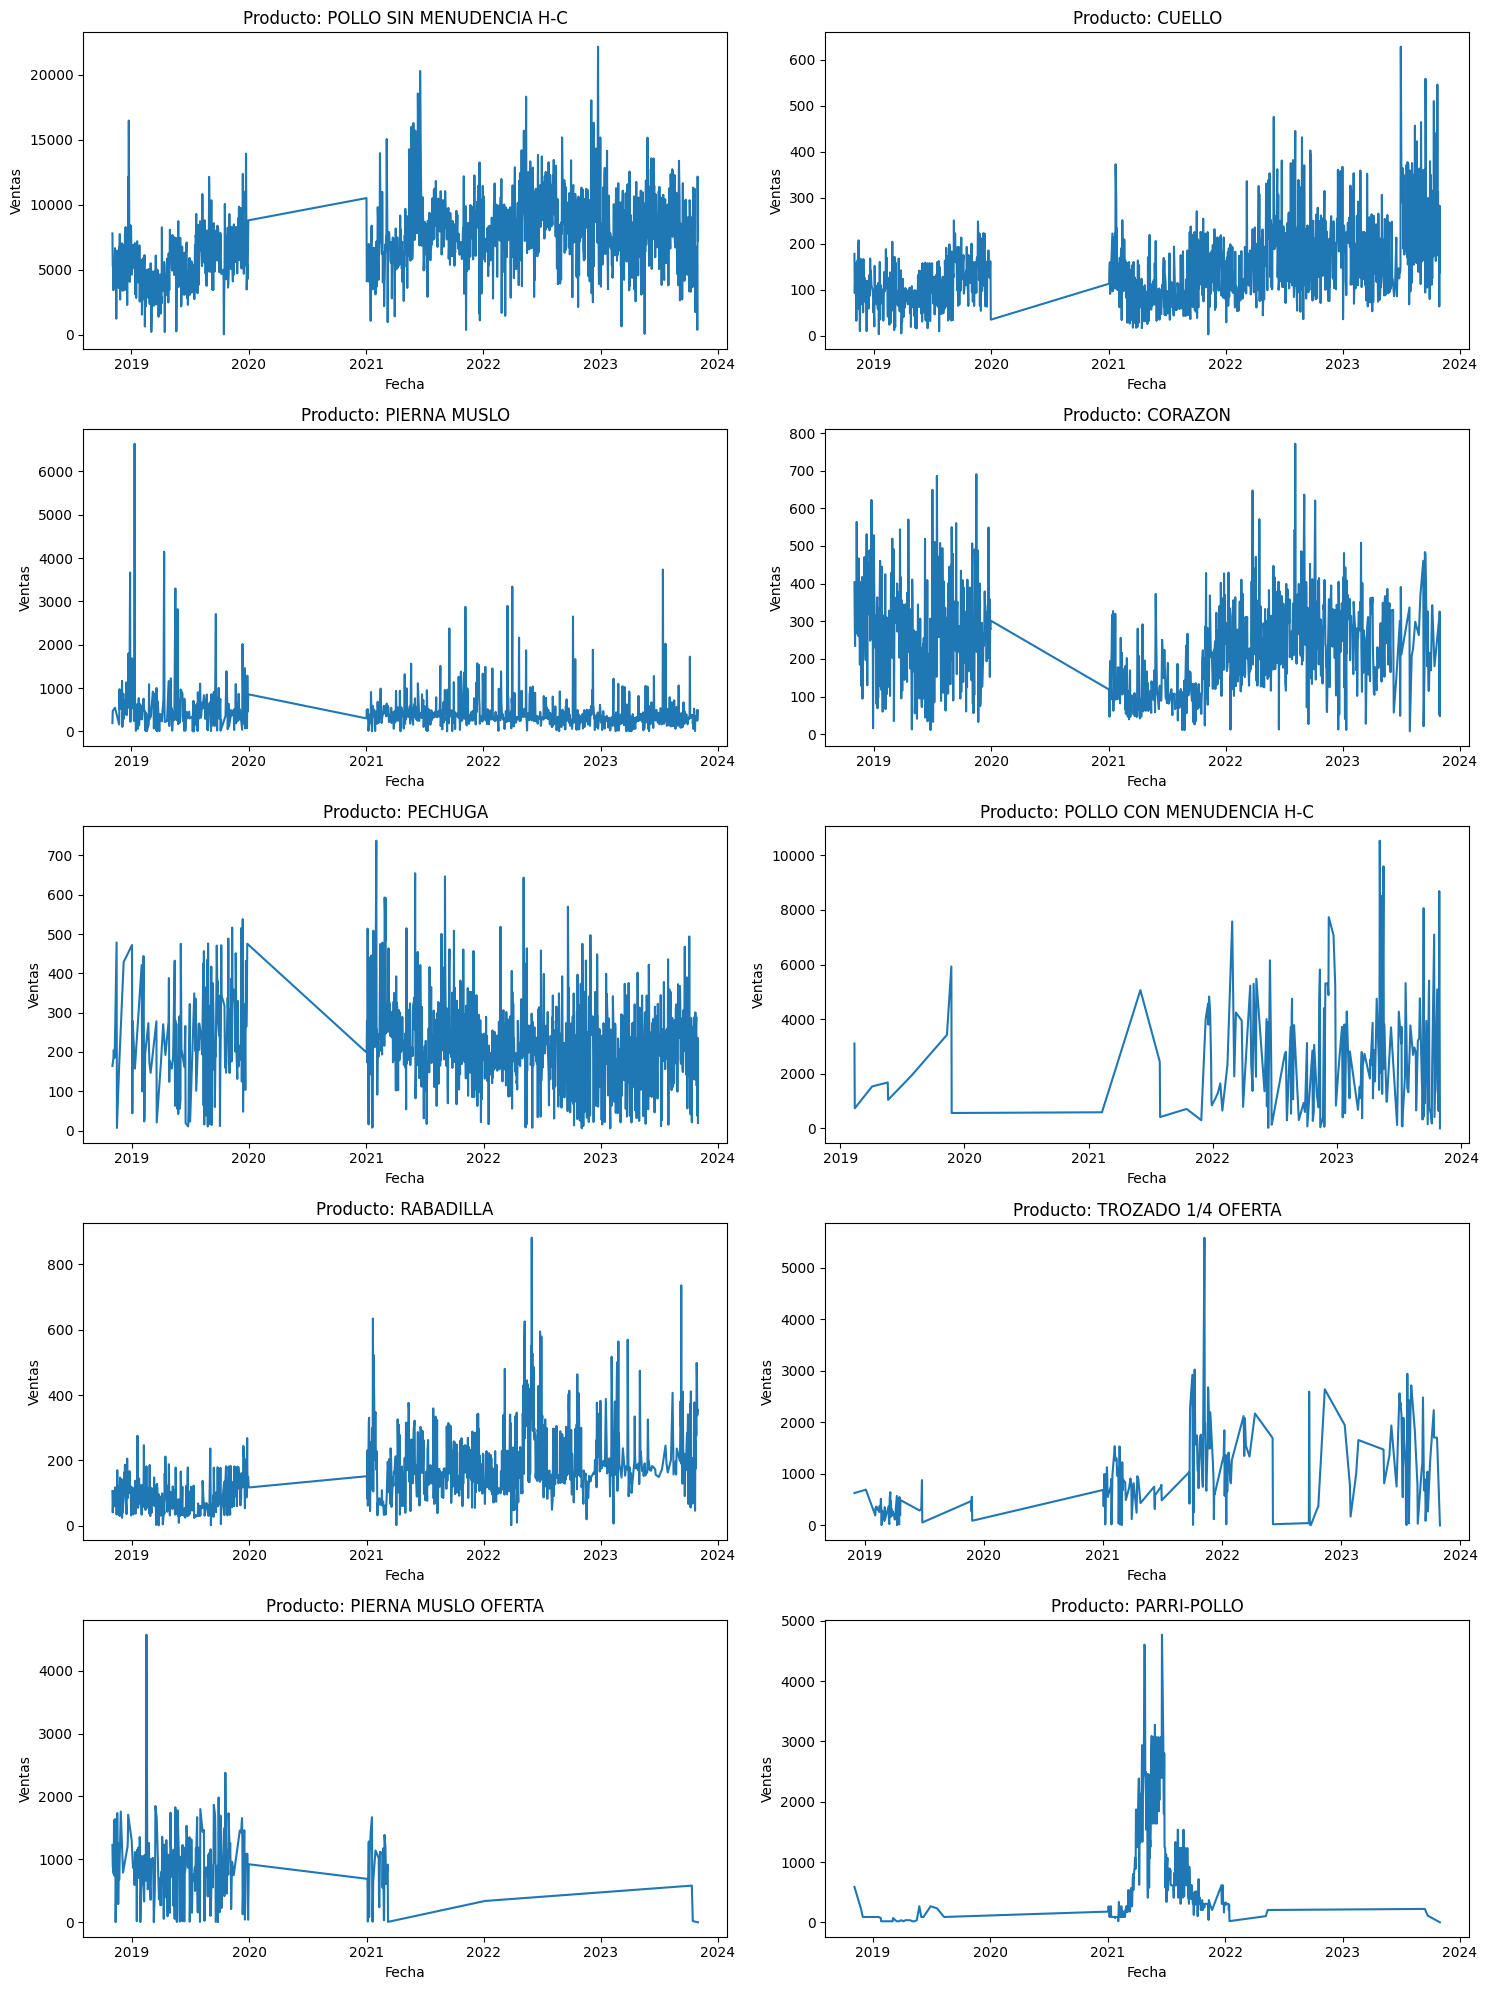

In [ ]:
# Crear una figura y ejes para los gráficos
fig, axs = plt.subplots(5, 2, figsize=(15, 20))  # Cambia el tamaño según sea necesario

# Iterar sobre los productos y sus DataFrames
for i, (product, product_df) in enumerate(dfs_de_productos_sumados_prophet.items()):
    # Calcular las coordenadas de los subgráficos
    row, col = divmod(i, 2)

    # Crear un gráfico de líneas para cada producto
    axs[row, col].plot(product_df['ds'], product_df['y'], label=product)
    axs[row, col].set_title(f'Producto: {product}')
    axs[row, col].set_xlabel('Fecha')
    axs[row, col].set_ylabel('Ventas')

# Ajustar el diseño de la figura
plt.tight_layout()
plt.show()

In [ ]:
for i, df_product in enumerate(dfs_de_productos_sumados):
    print(f"DataFrame {i + 1} - Tipos de Datos:")
    print(dfs_de_productos_sumados[df_product].dtypes)
    print("=" * 30)

DataFrame 1 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 2 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 3 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 4 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 5 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 6 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 7 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 8 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 9 - Tipos de D

### clonar para LSTM y ARIMA


In [ ]:
dfs_de_productos_sumados

{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  year  MontoBase
 FechaMovimiento                                           
 2018-11-03       POLLO SIN MENUDENCIA H-C  2018  7795.8660
 2018-11-04       POLLO SIN MENUDENCIA H-C  2018  5278.5900
 2018-11-05       POLLO SIN MENUDENCIA H-C  2018  5096.8520
 2018-11-06       POLLO SIN MENUDENCIA H-C  2018  3420.9820
 2018-11-07       POLLO SIN MENUDENCIA H-C  2018  3968.6880
 ...                                   ...   ...        ...
 2023-10-27       POLLO SIN MENUDENCIA H-C  2023  6026.4036
 2023-10-28       POLLO SIN MENUDENCIA H-C  2023  5949.4542
 2023-10-29       POLLO SIN MENUDENCIA H-C  2023   374.6544
 2023-10-30       POLLO SIN MENUDENCIA H-C  2023 12163.1227
 2023-10-31       POLLO SIN MENUDENCIA H-C  2023  7254.2832
 
 [1402 rows x 3 columns],
 'CUELLO':                 NombreProducto  year  MontoBase
 FechaMovimiento                                
 2018-11-01              CUELLO  2018   178.1120
 2018-1

In [ ]:
# Clonar completamente el objeto contenedor de DataFrames sumados
dfs_de_productos_sumados_lstm = copy.deepcopy(dfs_de_productos_sumados)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_lstm in dfs_de_productos_sumados_lstm.items():
    # Restablecer el índice
    product_df_lstm.reset_index(inplace=True)

    # Configurar 'FechaMovimiento' como índice
    product_df_lstm.set_index('FechaMovimiento', inplace=True)

    # Preprocesamiento de fechas utilizando el índice
    product_df_lstm['DayOW'] = product_df_lstm.index.dayofweek
    product_df_lstm['Month'] = product_df_lstm.index.month
    product_df_lstm['Year'] = product_df_lstm.index.year

    product_df_lstm.drop(columns=['year'], inplace=True)

    # Ordenar el DataFrame por la fecha (si es necesario)
    product_df_lstm.sort_index(inplace=True)

# Ahora, el índice es 'FechaMovimiento' nuevamente, puedes acceder a la columna
# 'FechaMovimiento' si es necesario después del bucle.

# Ejemplo de acceso después del bucle
# product_df_lstm['FechaMovimiento'] = pd.to_datetime(product_df_lstm['FechaMovimiento'])

In [ ]:
# Clonar completamente el objeto contenedor de DataFrames sumados
dfs_de_productos_sumados_arima = copy.deepcopy(dfs_de_productos_sumados)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_arima in dfs_de_productos_sumados_arima.items():
     # Restablecer el índice
    product_df_arima.reset_index(inplace=True)

    # Configurar 'FechaMovimiento' como índice
    product_df_arima.set_index('FechaMovimiento', inplace=True)

    # Ordenar el DataFrame por la fecha
    product_df_arima.sort_index(inplace=True)
    # Eliminar la columna 'year'
    product_df_arima.drop(columns=['year'], inplace=True)

In [ ]:
print(dfs_de_productos_sumados_arima['PECHUGA'])

                NombreProducto  MontoBase
FechaMovimiento                          
2018-11-02             PECHUGA   164.3120
2018-11-05             PECHUGA   183.5400
2018-11-06             PECHUGA   204.2400
2018-11-09             PECHUGA   185.2880
2018-11-15             PECHUGA   478.6760
...                        ...        ...
2023-10-27             PECHUGA   114.1536
2023-10-28             PECHUGA   157.3936
2023-10-29             PECHUGA    38.0512
2023-10-30             PECHUGA   236.0904
2023-10-31             PECHUGA    19.0256

[1093 rows x 2 columns]


## Noviembre
Antes de empezar con los modelos se debe Almacenar los valores de venta REALES de Noviembre de 2023 para comparar las predicciones de cada Modelo

In [ ]:
# Obtener los 10 productos más vendidos
top_10_products = df_todo['NombreProducto'].value_counts().head(10).index

# Crear un diccionario para almacenar los DataFrames divididos
dfs_de_Noviembre = {}

# Iterar sobre los productos y dividir el DataFrame
for product in top_10_products:
    product_nov = df_noviembre[df_noviembre['NombreProducto'] == product].copy()

    product_nov.set_index('FechaMovimiento', inplace=True)


    # Almacenar el DataFrame en el diccionario
    dfs_de_Noviembre[product] = product_nov

In [ ]:
# Crear un diccionario para almacenar los DataFrames sumados
dfs_noviembre_sumados = {}

# Iterar sobre los productos en el diccionario original
for product, product_df in dfs_de_Noviembre.items():
    # Sumar las ventas por día sin perder 'NombreProducto' y 'year'
    product_df_sumado = product_df.groupby(['FechaMovimiento', 'NombreProducto', 'year'])['MontoBase'].sum().reset_index()

    # Establecer 'FechaMovimiento' como índice
    product_df_sumado.set_index('FechaMovimiento', inplace=True)

    product_df_sumado.drop(columns=['year'], inplace=True)

    # Agregar el DataFrame sumado al nuevo diccionario
    dfs_noviembre_sumados[product] = product_df_sumado

In [ ]:
# Definir el rango de fechas de noviembre
noviembre_range = pd.date_range(start='2023-11-01', end='2023-11-30')

# Iterar sobre los productos en dfs_noviembre_sumados
for product, product_df in dfs_noviembre_sumados.items():
    # Crear un DataFrame con el índice de noviembre
    noviembre_df = pd.DataFrame(index=noviembre_range)

    # Verificar si hay fechas en noviembre que no están en el DataFrame original
    missing_dates = noviembre_df.index.difference(product_df.index)

    print(f"Las fechas que no están en el producto {product} son: {missing_dates}")

    if not missing_dates.empty:
        # Agregar filas con ventas '0' para las fechas faltantes
        new_rows = pd.DataFrame({'NombreProducto': product, 'MontoBase': 0}, index=missing_dates)
        product_df = pd.concat([product_df, new_rows])

        print(f"Se agregaron filas con ventas '0' para el producto {product} en las fechas faltantes.")

    # Ordenar el DataFrame por fecha
    product_df.sort_index(inplace=True)

    # Imprimir información sobre el producto
    print(f"Se agregaron {len(missing_dates)} registros de venta 0 para el producto {product} en noviembre.")

    # Actualizar el DataFrame en el diccionario
    dfs_noviembre_sumados[product] = product_df

Las fechas que no están en el producto POLLO SIN MENUDENCIA H-C son: DatetimeIndex([], dtype='datetime64[ns]', freq='D')
Se agregaron 0 registros de venta 0 para el producto POLLO SIN MENUDENCIA H-C en noviembre.
Las fechas que no están en el producto CUELLO son: DatetimeIndex(['2023-11-09', '2023-11-10', '2023-11-21', '2023-11-22',
               '2023-11-23', '2023-11-24', '2023-11-26', '2023-11-30'],
              dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto CUELLO en las fechas faltantes.
Se agregaron 8 registros de venta 0 para el producto CUELLO en noviembre.
Las fechas que no están en el producto PIERNA MUSLO son: DatetimeIndex(['2023-11-20', '2023-11-25', '2023-11-27', '2023-11-28',
               '2023-11-29', '2023-11-30'],
              dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto PIERNA MUSLO en las fechas faltantes.
Se agregaron 6 registros de venta 0 para el producto PIERNA MUSLO en noviembr

<ipython-input-35-d33dcdf4c47a>:22: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  product_df.sort_index(inplace=True)
<ipython-input-35-d33dcdf4c47a>:22: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  product_df.sort_index(inplace=True)
<ipython-input-35-d33dcdf4c47a>:22: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  product_df.sort_index(inplace=True)
<ipython-input-35-d33dcdf4c47a>:22: FutureW

In [ ]:
# Iterar sobre los productos en dfs_noviembre_sumados
for product, product_df in dfs_noviembre_sumados.items():
    # Convertir el índice a objetos datetime y luego quitar la información de tiempo
    product_df.index = pd.to_datetime(product_df.index).date

    # Imprimir información sobre el producto
    print(f"DataFrame actualizado para el producto {product}:\n{product_df}")

DataFrame actualizado para el producto POLLO SIN MENUDENCIA H-C:
                      NombreProducto  MontoBase
2023-11-01  POLLO SIN MENUDENCIA H-C  3239.2974
2023-11-02  POLLO SIN MENUDENCIA H-C  7098.1327
2023-11-03  POLLO SIN MENUDENCIA H-C  4978.8291
2023-11-04  POLLO SIN MENUDENCIA H-C  4431.8618
2023-11-05  POLLO SIN MENUDENCIA H-C  4541.8035
2023-11-06  POLLO SIN MENUDENCIA H-C  7492.0734
2023-11-07  POLLO SIN MENUDENCIA H-C  7305.7163
2023-11-08  POLLO SIN MENUDENCIA H-C  4343.5560
2023-11-09  POLLO SIN MENUDENCIA H-C  3487.1891
2023-11-10  POLLO SIN MENUDENCIA H-C  1528.0410
2023-11-11  POLLO SIN MENUDENCIA H-C  7330.7520
2023-11-12  POLLO SIN MENUDENCIA H-C  4889.5888
2023-11-13  POLLO SIN MENUDENCIA H-C  7760.8445
2023-11-14  POLLO SIN MENUDENCIA H-C  1427.7825
2023-11-15  POLLO SIN MENUDENCIA H-C  1659.6720
2023-11-16  POLLO SIN MENUDENCIA H-C  4789.3392
2023-11-17  POLLO SIN MENUDENCIA H-C  4469.1706
2023-11-18  POLLO SIN MENUDENCIA H-C  7775.5295
2023-11-19  POLLO SIN M

In [ ]:
print(dfs_noviembre_sumados)

{'POLLO SIN MENUDENCIA H-C':                       NombreProducto  MontoBase
2023-11-01  POLLO SIN MENUDENCIA H-C  3239.2974
2023-11-02  POLLO SIN MENUDENCIA H-C  7098.1327
2023-11-03  POLLO SIN MENUDENCIA H-C  4978.8291
2023-11-04  POLLO SIN MENUDENCIA H-C  4431.8618
2023-11-05  POLLO SIN MENUDENCIA H-C  4541.8035
2023-11-06  POLLO SIN MENUDENCIA H-C  7492.0734
2023-11-07  POLLO SIN MENUDENCIA H-C  7305.7163
2023-11-08  POLLO SIN MENUDENCIA H-C  4343.5560
2023-11-09  POLLO SIN MENUDENCIA H-C  3487.1891
2023-11-10  POLLO SIN MENUDENCIA H-C  1528.0410
2023-11-11  POLLO SIN MENUDENCIA H-C  7330.7520
2023-11-12  POLLO SIN MENUDENCIA H-C  4889.5888
2023-11-13  POLLO SIN MENUDENCIA H-C  7760.8445
2023-11-14  POLLO SIN MENUDENCIA H-C  1427.7825
2023-11-15  POLLO SIN MENUDENCIA H-C  1659.6720
2023-11-16  POLLO SIN MENUDENCIA H-C  4789.3392
2023-11-17  POLLO SIN MENUDENCIA H-C  4469.1706
2023-11-18  POLLO SIN MENUDENCIA H-C  7775.5295
2023-11-19  POLLO SIN MENUDENCIA H-C  7662.2770
2023-11-20 

# PROPHET


## Predecir cada uno de los 10 productos mas vendidos

 Predicciones sin el 2020 de los 10 productos más vendidos

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds            NombreProducto          y
0    2018-11-03  POLLO SIN MENUDENCIA H-C  7795.8660
1    2018-11-04  POLLO SIN MENUDENCIA H-C  5278.5900
2    2018-11-05  POLLO SIN MENUDENCIA H-C  5096.8520
3    2018-11-06  POLLO SIN MENUDENCIA H-C  3420.9820
4    2018-11-07  POLLO SIN MENUDENCIA H-C  3968.6880
...         ...                       ...        ...
1397 2023-10-27  POLLO SIN MENUDENCIA H-C  6026.4036
1398 2023-10-28  POLLO SIN MENUDENCIA H-C  5949.4542
1399 2023-10-29  POLLO SIN MENUDENCIA H-C   374.6544
1400 2023-10-30  POLLO SIN MENUDENCIA H-C 12163.1227
1401 2023-10-31  POLLO SIN MENUDENCIA H-C  7254.2832

[1402 rows x 3 columns]


DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/6lwch1wo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/mnmmd_g3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16062', 'data', 'file=/tmp/tmptqlal1m4/6lwch1wo.json', 'init=/tmp/tmptqlal1m4/mnmmd_g3.json', 'output', 'file=/tmp/tmptqlal1m4/prophet_model6mn4qy03/prophet_model-20240128233602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:36:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:36:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


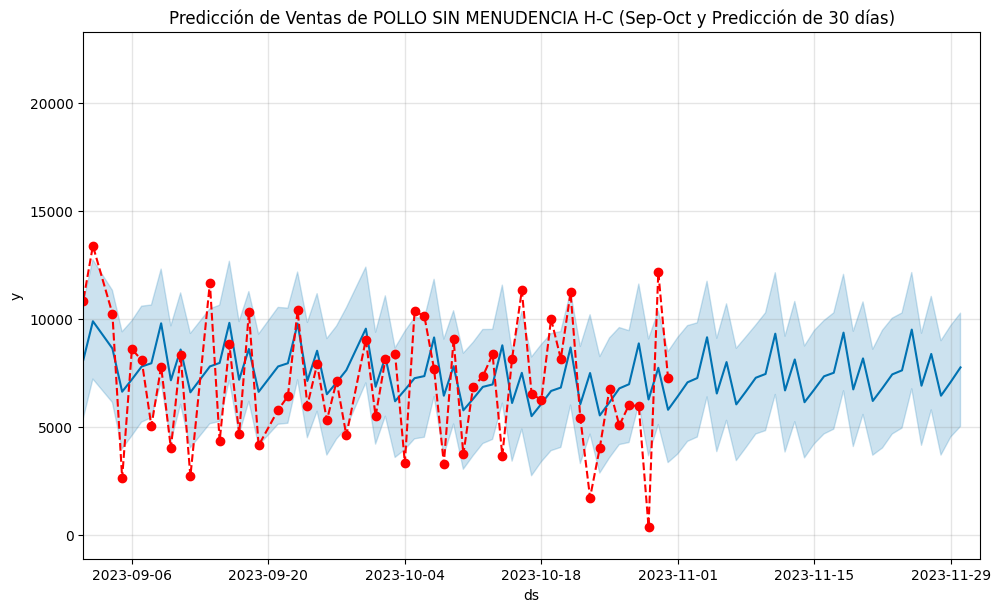

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/tp_j1e_a.json


Predicción con todos los valores para POLLO SIN MENUDENCIA H-C:
             ds      yhat
1402 2023-11-01 6417.9309
1403 2023-11-02 7064.6314
1404 2023-11-03 7261.7427
1405 2023-11-04 9148.6384
1406 2023-11-05 6546.9965
1407 2023-11-06 8000.4072
1408 2023-11-07 6044.2745
1409 2023-11-08 6649.6098
1410 2023-11-09 7275.7326
1411 2023-11-10 7450.6046
1412 2023-11-11 9314.4162
1413 2023-11-12 6689.6842
1414 2023-11-13 8120.8389
1415 2023-11-14 6144.1039
1416 2023-11-15 6731.2690
1417 2023-11-16 7342.3706
1418 2023-11-17 7506.0067
1419 2023-11-18 9362.9060
1420 2023-11-19 6736.0109
1421 2023-11-20 8170.0516
1422 2023-11-21 6201.4165
1423 2023-11-22 6801.9189
1424 2023-11-23 7431.4740
1425 2023-11-24 7618.4143
1426 2023-11-25 9503.0630
1427 2023-11-26 6907.8236
1428 2023-11-27 8376.7651
1429 2023-11-28 6445.5060
1430 2023-11-29 7084.9970
1431 2023-11-30 7754.2172
             ds NombreProducto        y
0    2018-11-01         CUELLO 178.1120
1    2018-11-02         CUELLO  92.8280
2    2018-

DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/ttuxfbjk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50127', 'data', 'file=/tmp/tmptqlal1m4/tp_j1e_a.json', 'init=/tmp/tmptqlal1m4/ttuxfbjk.json', 'output', 'file=/tmp/tmptqlal1m4/prophet_modelc3etkrtm/prophet_model-20240128233604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:36:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:36:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


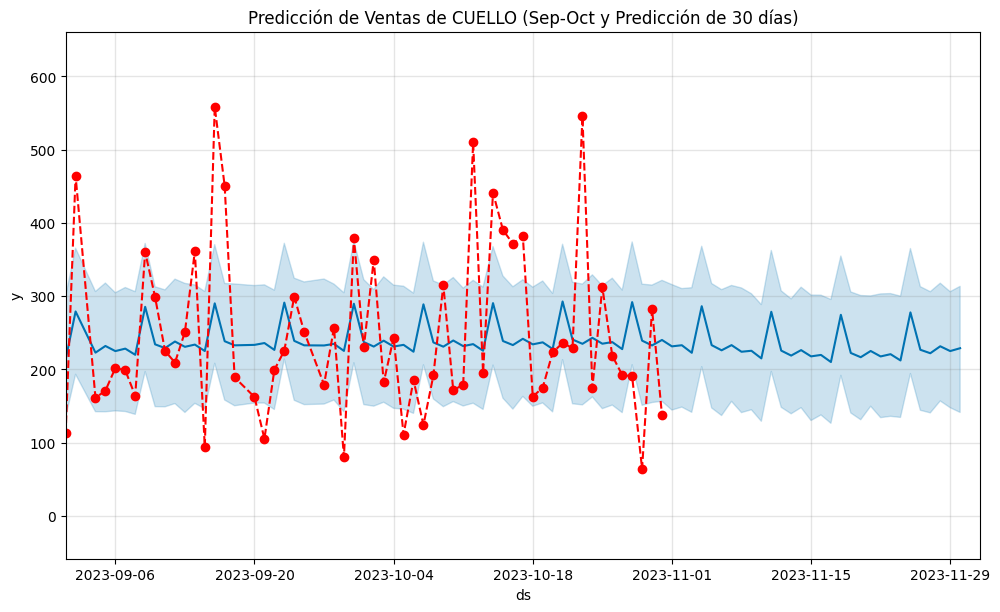

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/zfahfuq_.json


Predicción con todos los valores para CUELLO:
             ds     yhat
1287 2023-11-01 231.3795
1288 2023-11-02 232.9207
1289 2023-11-03 222.6019
1290 2023-11-04 286.2084
1291 2023-11-05 233.0389
1292 2023-11-06 226.0091
1293 2023-11-07 233.0775
1294 2023-11-08 224.0304
1295 2023-11-09 225.3683
1296 2023-11-10 214.9571
1297 2023-11-11 278.5881
1298 2023-11-12 225.5636
1299 2023-11-13 218.8010
1300 2023-11-14 226.2582
1301 2023-11-15 217.7189
1302 2023-11-16 219.6786
1303 2023-11-17 209.9964
1304 2023-11-18 274.4543
1305 2023-11-19 222.3438
1306 2023-11-20 216.5695
1307 2023-11-21 225.0751
1308 2023-11-22 217.6285
1309 2023-11-23 220.7086
1310 2023-11-24 212.1569
1311 2023-11-25 277.7375
1312 2023-11-26 226.7235
1313 2023-11-27 222.0013
1314 2023-11-28 231.4970
1315 2023-11-29 224.9615
1316 2023-11-30 228.8578
             ds NombreProducto        y
0    2018-11-03   PIERNA MUSLO 192.0040
1    2018-11-04   PIERNA MUSLO 472.7880
2    2018-11-11   PIERNA MUSLO 546.4800
3    2018-11-24   P

DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/b0sitzmm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90948', 'data', 'file=/tmp/tmptqlal1m4/zfahfuq_.json', 'init=/tmp/tmptqlal1m4/b0sitzmm.json', 'output', 'file=/tmp/tmptqlal1m4/prophet_modelatag2oj4/prophet_model-20240128233606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:36:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:36:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


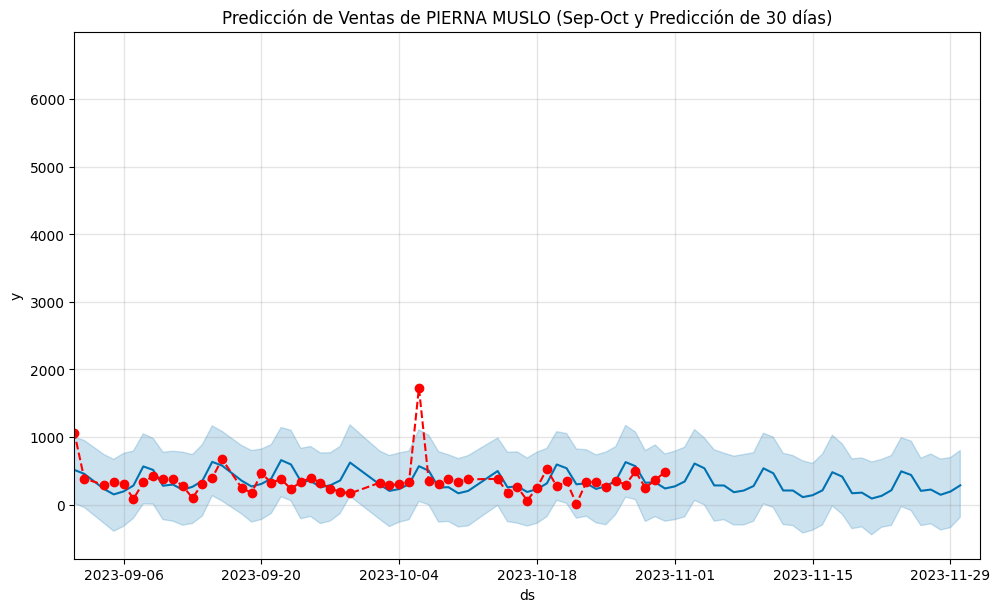

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/0aakpl4z.json


Predicción con todos los valores para PIERNA MUSLO:
             ds     yhat
1144 2023-11-01 268.5241
1145 2023-11-02 341.1213
1146 2023-11-03 606.7377
1147 2023-11-04 536.2827
1148 2023-11-05 282.8380
1149 2023-11-06 281.4944
1150 2023-11-07 182.1712
1151 2023-11-08 206.9184
1152 2023-11-09 274.1517
1153 2023-11-10 535.7144
1154 2023-11-11 462.6292
1155 2023-11-12 208.0583
1156 2023-11-13 207.1383
1157 2023-11-14 109.7994
1158 2023-11-15 138.0667
1159 2023-11-16 210.2969
1160 2023-11-17 478.2417
1161 2023-11-18 412.8016
1162 2023-11-19 166.9900
1163 2023-11-20 175.7712
1164 2023-11-21  88.8845
1165 2023-11-22 128.1498
1166 2023-11-23 211.7096
1167 2023-11-24 491.0973
1168 2023-11-25 436.9962
1169 2023-11-26 202.2082
1170 2023-11-27 221.4976
1171 2023-11-28 144.4182
1172 2023-11-29 192.6236
1173 2023-11-30 284.1125
             ds NombreProducto        y
0    2018-11-01        CORAZON 403.7930
1    2018-11-02        CORAZON 300.2860
2    2018-11-03        CORAZON 234.2480
3    2018-11-

DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/oi4eodx8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91375', 'data', 'file=/tmp/tmptqlal1m4/0aakpl4z.json', 'init=/tmp/tmptqlal1m4/oi4eodx8.json', 'output', 'file=/tmp/tmptqlal1m4/prophet_modelc4f77lqf/prophet_model-20240128233609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:36:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:36:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


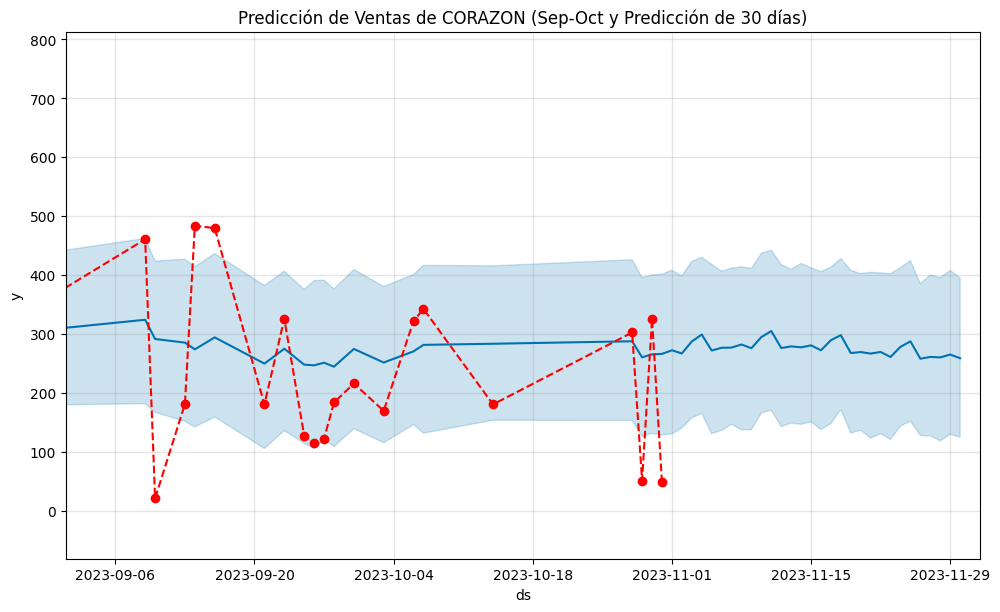

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/a4olgiyc.json


Predicción con todos los valores para CORAZON:
             ds     yhat
1082 2023-11-01 272.4317
1083 2023-11-02 267.1141
1084 2023-11-03 287.3618
1085 2023-11-04 299.1460
1086 2023-11-05 272.0083
1087 2023-11-06 276.7313
1088 2023-11-07 277.0208
1089 2023-11-08 282.3111
1090 2023-11-09 275.9185
1091 2023-11-10 294.8425
1092 2023-11-11 305.0856
1093 2023-11-12 276.2283
1094 2023-11-13 279.0992
1095 2023-11-14 277.4556
1096 2023-11-15 280.7874
1097 2023-11-16 272.4692
1098 2023-11-17 289.5595
1099 2023-11-18 298.1191
1100 2023-11-19 267.7841
1101 2023-11-20 269.4345
1102 2023-11-21 266.8731
1103 2023-11-22 269.6282
1104 2023-11-23 261.1042
1105 2023-11-24 278.3801
1106 2023-11-25 287.5264
1107 2023-11-26 258.1791
1108 2023-11-27 261.2065
1109 2023-11-28 260.3895
1110 2023-11-29 265.2237
1111 2023-11-30 259.0718
             ds NombreProducto        y
0    2018-11-02        PECHUGA 164.3120
1    2018-11-05        PECHUGA 183.5400
2    2018-11-06        PECHUGA 204.2400
3    2018-11-09   

DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/rb7y7hte.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45333', 'data', 'file=/tmp/tmptqlal1m4/a4olgiyc.json', 'init=/tmp/tmptqlal1m4/rb7y7hte.json', 'output', 'file=/tmp/tmptqlal1m4/prophet_model0rvcvlf_/prophet_model-20240128233612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:36:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:36:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


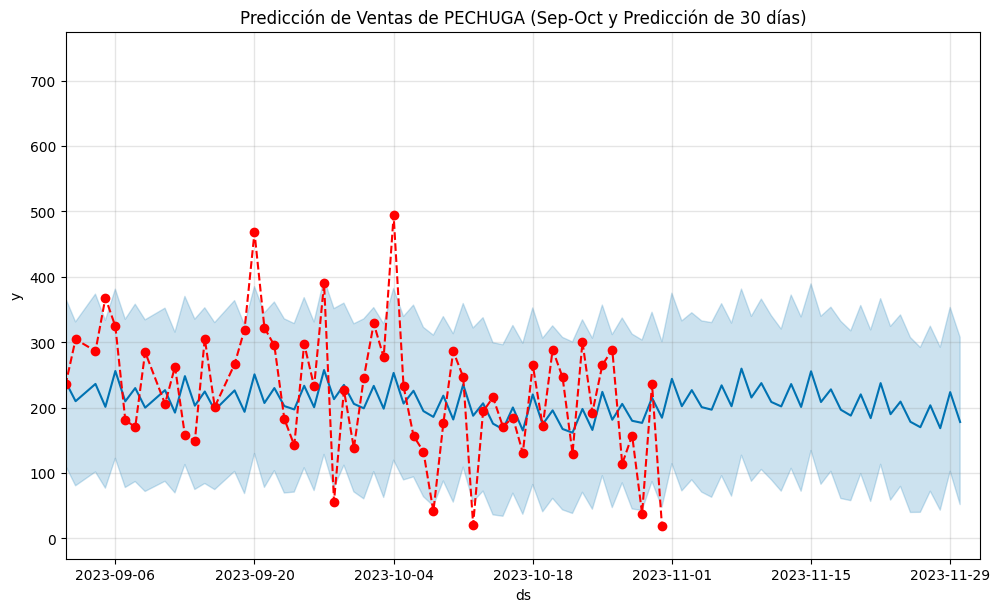

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/lq80upic.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/4gg8duzo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30806', 'data', 'file=/tmp/tmptqlal1m4/lq80upic.json', 'init=/tmp/tmptqlal1m4/4gg8duzo.json', 'output', 'file=/tmp/tmptqlal1m4/prophet_modeletj92y4x/prophet_model-20240128233614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:36:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:36:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predicción con todos los valores para PECHUGA:
             ds     yhat
1093 2023-11-01 244.0083
1094 2023-11-02 202.1861
1095 2023-11-03 226.7434
1096 2023-11-04 200.7549
1097 2023-11-05 196.8760
1098 2023-11-06 234.0792
1099 2023-11-07 202.1358
1100 2023-11-08 259.6008
1101 2023-11-09 215.4927
1102 2023-11-10 237.4774
1103 2023-11-11 208.6936
1104 2023-11-12 201.8652
1105 2023-11-13 236.0368
1106 2023-11-14 201.0526
1107 2023-11-15 255.5396
1108 2023-11-16 208.5860
1109 2023-11-17 227.9226
1110 2023-11-18 196.7468
1111 2023-11-19 187.8342
1112 2023-11-20 220.2715
1113 2023-11-21 183.9357
1114 2023-11-22 237.4758
1115 2023-11-23 189.9911
1116 2023-11-24 209.2128
1117 2023-11-25 178.3274
1118 2023-11-26 170.0892
1119 2023-11-27 203.5547
1120 2023-11-28 168.5615
1121 2023-11-29 223.7121
1122 2023-11-30 178.0535
            ds            NombreProducto         y
0   2019-02-12  POLLO CON MENUDENCIA H-C 3108.9480
1   2019-02-13  POLLO CON MENUDENCIA H-C  734.9620
2   2019-04-05  POLLO CON

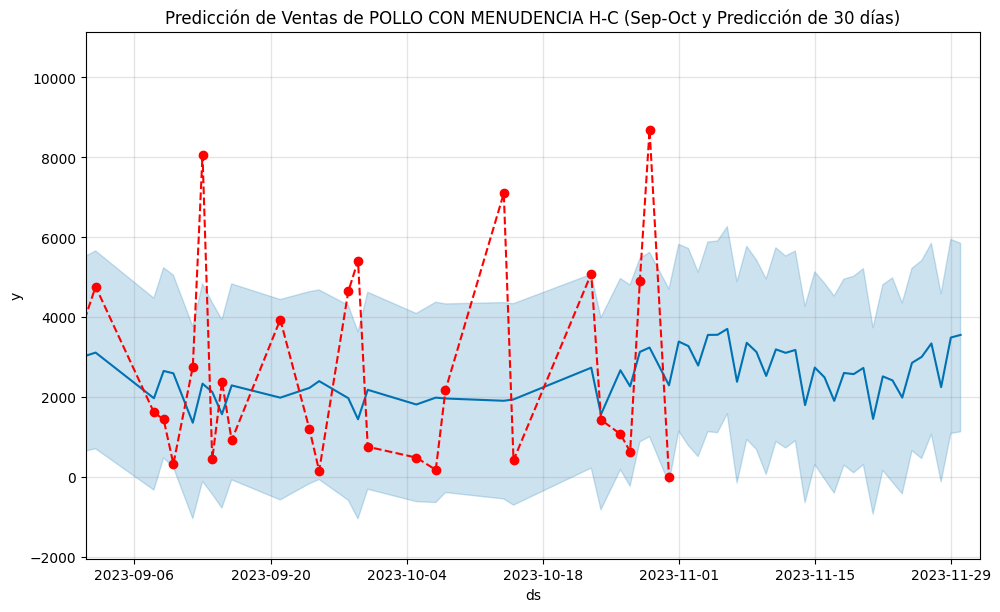

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/sgbco99l.json


Predicción con todos los valores para POLLO CON MENUDENCIA H-C:
            ds      yhat
179 2023-11-01 3387.6977
180 2023-11-02 3273.9790
181 2023-11-03 2787.2707
182 2023-11-04 3554.0032
183 2023-11-05 3557.2565
184 2023-11-06 3704.5392
185 2023-11-07 2380.6366
186 2023-11-08 3356.6747
187 2023-11-09 3125.9698
188 2023-11-10 2527.8756
189 2023-11-11 3192.2260
190 2023-11-12 3105.3753
191 2023-11-13 3177.8806
192 2023-11-14 1797.2589
193 2023-11-15 2736.9665
194 2023-11-16 2492.1730
195 2023-11-17 1903.5432
196 2023-11-18 2601.6307
197 2023-11-19 2572.8804
198 2023-11-20 2727.2932
199 2023-11-21 1451.1799
200 2023-11-22 2516.1559
201 2023-11-23 2414.9485
202 2023-11-24 1985.2278
203 2023-11-25 2854.0653
204 2023-11-26 3004.0164
205 2023-11-27 3340.8759
206 2023-11-28 2246.5337
207 2023-11-29 3488.0784
208 2023-11-30 3553.7170
             ds NombreProducto        y
0    2018-11-01      RABADILLA 106.5360
1    2018-11-02      RABADILLA  40.9400
2    2018-11-04      RABADILLA 106.4440
3

DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/9w_rcg9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33423', 'data', 'file=/tmp/tmptqlal1m4/sgbco99l.json', 'init=/tmp/tmptqlal1m4/9w_rcg9r.json', 'output', 'file=/tmp/tmptqlal1m4/prophet_modelpjmt2ulv/prophet_model-20240128233615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:36:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:36:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


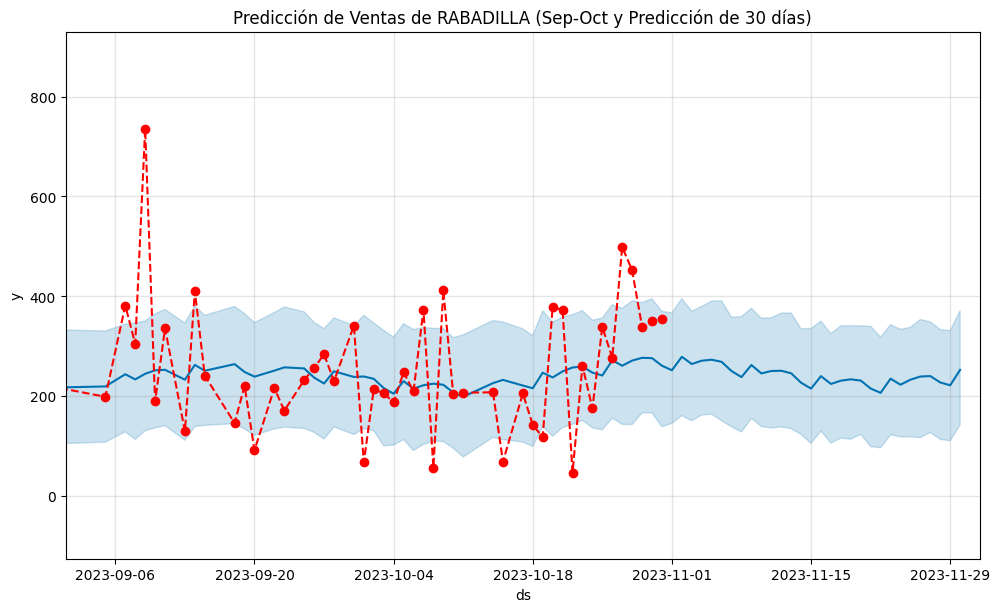

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/g90hwn4z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/7xqs4eft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37534', 'data', 'file=/tmp/tmptqlal1m4/g90hwn4z.json', 'init=/tmp/tmptqlal1m4/7xqs4eft.json', 'output', 'file=/tmp/tmptqlal1m4/prophet_model3r_9xuf4/prophet_model-20240128233615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:36:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:36:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predicción con todos los valores para RABADILLA:
             ds     yhat
1049 2023-11-01 251.5031
1050 2023-11-02 278.4949
1051 2023-11-03 263.9545
1052 2023-11-04 270.6235
1053 2023-11-05 272.5818
1054 2023-11-06 268.3710
1055 2023-11-07 249.8161
1056 2023-11-08 237.7502
1057 2023-11-09 262.0143
1058 2023-11-10 245.1402
1059 2023-11-11 249.9211
1060 2023-11-12 250.4788
1061 2023-11-13 245.3856
1062 2023-11-14 226.4851
1063 2023-11-15 214.6174
1064 2023-11-16 239.6175
1065 2023-11-17 223.9994
1066 2023-11-18 230.5267
1067 2023-11-19 233.2806
1068 2023-11-20 230.7823
1069 2023-11-21 214.8161
1070 2023-11-22 206.1546
1071 2023-11-23 234.5601
1072 2023-11-24 222.4692
1073 2023-11-25 232.5661
1074 2023-11-26 238.8516
1075 2023-11-27 239.7685
1076 2023-11-28 227.0251
1077 2023-11-29 221.3238
1078 2023-11-30 252.3622
            ds      NombreProducto         y
0   2018-12-01  TROZADO 1/4 OFERTA  626.3360
1   2019-01-05  TROZADO 1/4 OFERTA  692.1160
2   2019-02-03  TROZADO 1/4 OFERTA  192.0

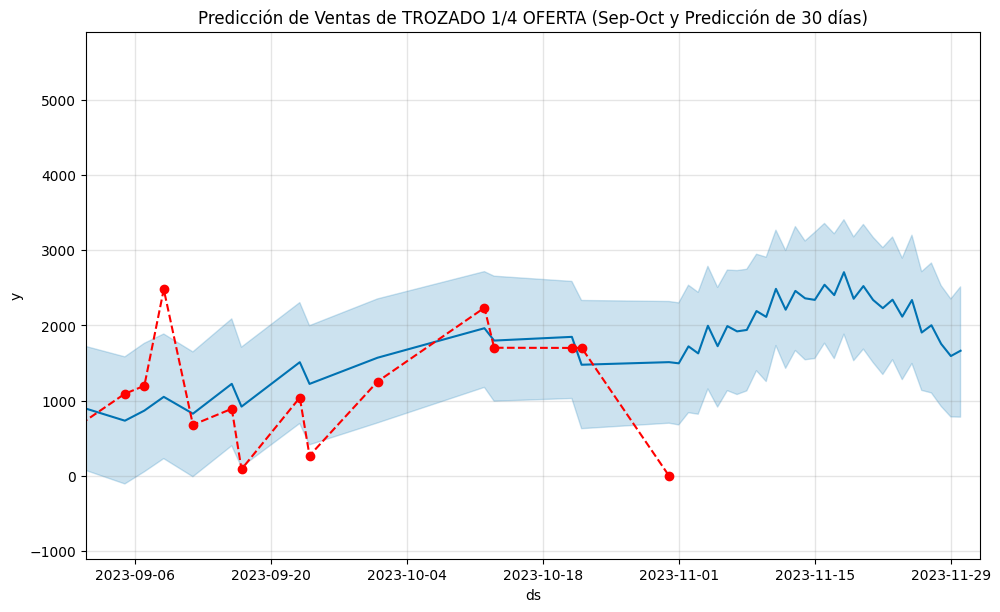

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/alrhjql5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/bm5b2p7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96188', 'data', 'file=/tmp/tmptqlal1m4/alrhjql5.json', 'init=/tmp/tmptqlal1m4/bm5b2p7i.json', 'output', 'file=/tmp/tmptqlal1m4/prophet_models4d6luju/prophet_model-20240128233616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:36:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:36:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predicción con todos los valores para TROZADO 1/4 OFERTA:
            ds      yhat
220 2023-11-01 1495.6180
221 2023-11-02 1721.0386
222 2023-11-03 1627.3044
223 2023-11-04 1994.7055
224 2023-11-05 1723.3717
225 2023-11-06 1990.2343
226 2023-11-07 1920.1069
227 2023-11-08 1938.9803
228 2023-11-09 2190.1337
229 2023-11-10 2112.3499
230 2023-11-11 2485.1438
231 2023-11-12 2208.1106
232 2023-11-13 2457.9060
233 2023-11-14 2359.3401
234 2023-11-15 2338.6781
235 2023-11-16 2539.7503
236 2023-11-17 2402.1591
237 2023-11-18 2706.4919
238 2023-11-19 2353.6468
239 2023-11-20 2521.7844
240 2023-11-21 2337.3876
241 2023-11-22 2228.5229
242 2023-11-23 2340.9081
243 2023-11-24 2116.0733
244 2023-11-25 2336.5272
245 2023-11-26 1905.0352
246 2023-11-27 2001.5245
247 2023-11-28 1754.1001
248 2023-11-29 1592.2647
249 2023-11-30 1662.9503
            ds       NombreProducto         y
0   2018-11-01  PIERNA MUSLO OFERTA 1230.6840
1   2018-11-02  PIERNA MUSLO OFERTA  890.0080
2   2018-11-05  PIERNA MUSLO 

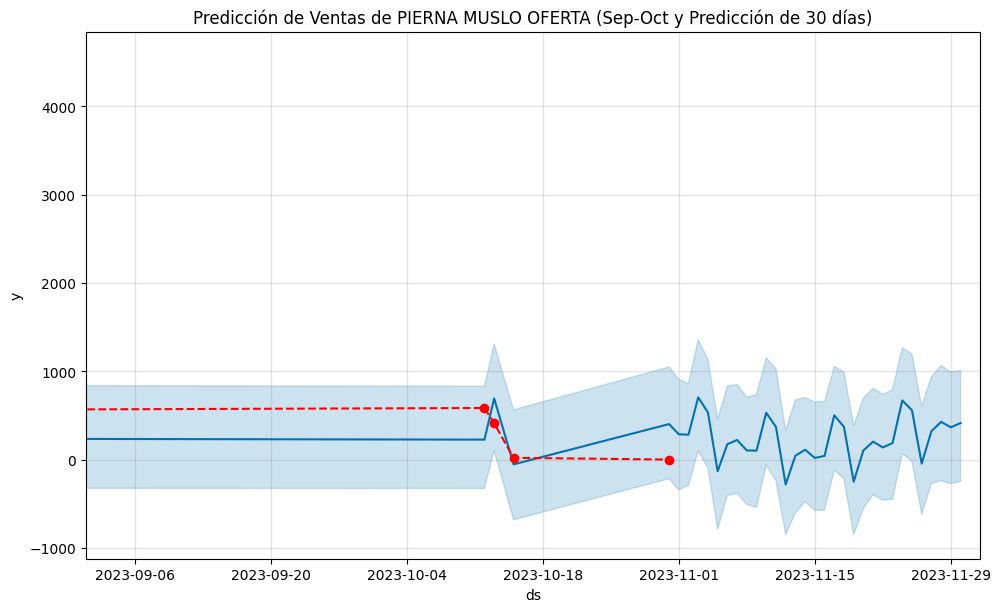

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/81s7gi8b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqlal1m4/anmju4jd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7415', 'data', 'file=/tmp/tmptqlal1m4/81s7gi8b.json', 'init=/tmp/tmptqlal1m4/anmju4jd.json', 'output', 'file=/tmp/tmptqlal1m4/prophet_modeldvtts18x/prophet_model-20240128233617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:36:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:36:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predicción con todos los valores para PIERNA MUSLO OFERTA:
            ds      yhat
264 2023-11-01  286.2985
265 2023-11-02  280.7806
266 2023-11-03  704.6724
267 2023-11-04  533.5796
268 2023-11-05 -132.0545
269 2023-11-06  174.4520
270 2023-11-07  221.2810
271 2023-11-08  103.6883
272 2023-11-09  100.1629
273 2023-11-10  530.2765
274 2023-11-11  369.5745
275 2023-11-12 -281.6615
276 2023-11-13   42.9895
277 2023-11-14  111.3556
278 2023-11-15   18.2527
279 2023-11-16   41.6538
280 2023-11-17  500.5513
281 2023-11-18  369.8606
282 2023-11-19 -250.8025
283 2023-11-20  104.2982
284 2023-11-21  202.3023
285 2023-11-22  137.3510
286 2023-11-23  186.7724
287 2023-11-24  668.9589
288 2023-11-25  558.2864
289 2023-11-26  -46.0955
290 2023-11-27  321.1670
291 2023-11-28  426.9255
292 2023-11-29  365.1335
293 2023-11-30  413.0366
            ds NombreProducto        y
0   2018-11-04    PARRI-POLLO 587.4000
1   2018-11-24    PARRI-POLLO 231.4000
2   2018-11-30    PARRI-POLLO  89.0000
3   2018-1

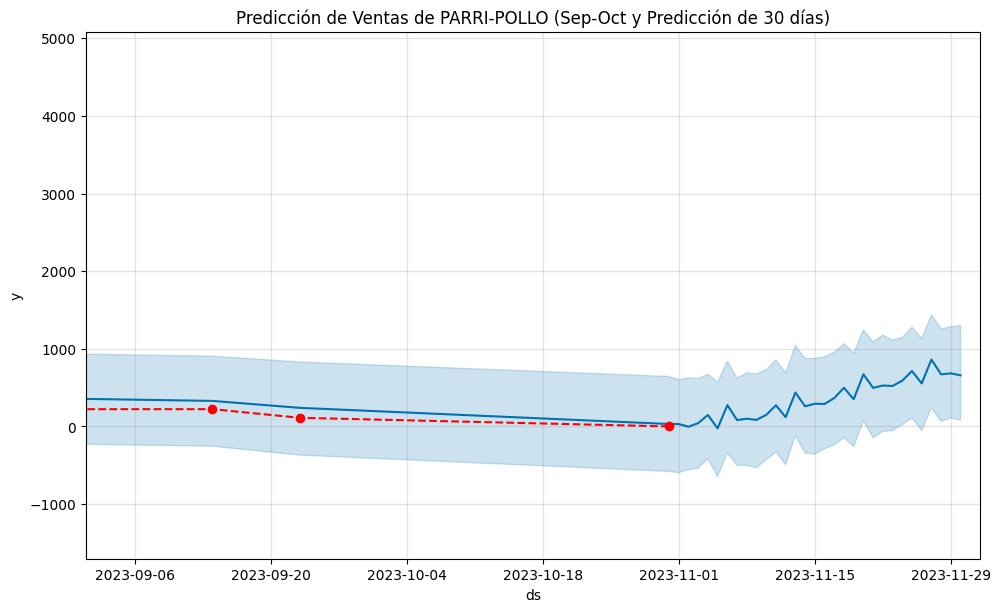

Predicción con todos los valores para PARRI-POLLO:
            ds     yhat
344 2023-11-01  30.7830
345 2023-11-02  -3.4690
346 2023-11-03  42.4500
347 2023-11-04 147.2019
348 2023-11-05 -24.7704
349 2023-11-06 274.7863
350 2023-11-07  82.2462
351 2023-11-08  99.7233
352 2023-11-09  84.1743
353 2023-11-10 149.0195
354 2023-11-11 272.5710
355 2023-11-12 118.9192
356 2023-11-13 435.9696
357 2023-11-14 259.7614
358 2023-11-15 292.0934
359 2023-11-16 289.6334
360 2023-11-17 365.5450
361 2023-11-18 497.9212
362 2023-11-19 350.6747
363 2023-11-20 671.5783
364 2023-11-21 496.5851
365 2023-11-22 527.4558
366 2023-11-23 520.8674
367 2023-11-24 590.0397
368 2023-11-25 713.1656
369 2023-11-26 554.2993
370 2023-11-27 861.3917
371 2023-11-28 670.6068
372 2023-11-29 683.9431
373 2023-11-30 658.3372


In [ ]:
# Definir las fechas de inicio y fin
fecha_inicio_str = '2023-09-01'
fecha_fin_str = '2023-12-02'

# Convertir las fechas a objetos datetime
fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')

# Iterar sobre los productos en dfs_de_productos_sumados_prophet
for product, product_df in dfs_de_productos_sumados_prophet.items():
    # Crear un modelo de Prophet
    modelo = Prophet()
    print(product_df)
    # Ajustar el modelo con los datos de entrenamiento
    modelo.fit(product_df)

    # Crear un DataFrame con fechas futuras para hacer la predicción
    futuro = modelo.make_future_dataframe(periods=30)

    # Hacer la predicción
    prediccion = modelo.predict(futuro)

    # Visualizar la predicción con límites ajustados
    fig = modelo.plot(prediccion)

    # Extraer los valores reales de predicción para cada día
    valores_prediccion = prediccion[['ds', 'yhat']].tail(30)

    # Mostrar el gráfico
    plt.plot(product_df['ds'], product_df['y'], label=f'Ventas reales de {product}', color='red', marker='o', linestyle='dashed')
    plt.xlim([fecha_inicio, fecha_fin])
    plt.title(f'Predicción de Ventas de {product} (Sep-Oct y Predicción de 30 días)')
    plt.show()

    # Mostrar el DataFrame con los valores de predicción
    print(f"Predicción con todos los valores para {product}:\n{valores_prediccion}")

## EVALUAR PROPHET

Predicciones hechas sobre todas las ventas de los 10 producton contando con y sin las ventas de 2020

evaluacion sin 2020

In [ ]:
# Iterar sobre los productos en dfs_noviembre_sumados
for product, product_df in dfs_noviembre_sumados.items():
    # Crear un nombre único para la columna de predicciones de Prophet
    col_name = f'P-V_PROPHET_{product}'

    # Convertir la columna de fecha a tipo datetime
    product_df['FechaMovimiento'] = pd.to_datetime(product_df.index)

    # Fusionar el DataFrame de ventas con el DataFrame de predicciones
    product_df = pd.merge(product_df, valores_prediccion[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

    # Renombrar la columna yhat a Ventas_PROPHET
    product_df.rename(columns={'yhat': col_name}, inplace=True)

    # Opcional: Eliminar la columna adicional 'ds' si no la necesitas
    product_df.drop(columns=['ds'], inplace=True)

    # Actualizar el DataFrame en el diccionario
    dfs_noviembre_sumados[product] = product_df

In [ ]:
for product, product_df in dfs_noviembre_sumados.items():
    print(product_df.head(30))

    # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
    evaluacion_metrica(dfs_noviembre_sumados[product]['MontoBase'], dfs_noviembre_sumados[product][f'P-V_PROPHET_{product}'])

              NombreProducto  MontoBase FechaMovimiento  \
0   POLLO SIN MENUDENCIA H-C  3239.2974      2023-11-01   
1   POLLO SIN MENUDENCIA H-C  7098.1327      2023-11-02   
2   POLLO SIN MENUDENCIA H-C  4978.8291      2023-11-03   
3   POLLO SIN MENUDENCIA H-C  4431.8618      2023-11-04   
4   POLLO SIN MENUDENCIA H-C  4541.8035      2023-11-05   
5   POLLO SIN MENUDENCIA H-C  7492.0734      2023-11-06   
6   POLLO SIN MENUDENCIA H-C  7305.7163      2023-11-07   
7   POLLO SIN MENUDENCIA H-C  4343.5560      2023-11-08   
8   POLLO SIN MENUDENCIA H-C  3487.1891      2023-11-09   
9   POLLO SIN MENUDENCIA H-C  1528.0410      2023-11-10   
10  POLLO SIN MENUDENCIA H-C  7330.7520      2023-11-11   
11  POLLO SIN MENUDENCIA H-C  4889.5888      2023-11-12   
12  POLLO SIN MENUDENCIA H-C  7760.8445      2023-11-13   
13  POLLO SIN MENUDENCIA H-C  1427.7825      2023-11-14   
14  POLLO SIN MENUDENCIA H-C  1659.6720      2023-11-15   
15  POLLO SIN MENUDENCIA H-C  4789.3392      2023-11-16 

In [ ]:
dfs_noviembre_sumados

{'POLLO SIN MENUDENCIA H-C':               NombreProducto  MontoBase FechaMovimiento  \
 0   POLLO SIN MENUDENCIA H-C  3239.2974      2023-11-01   
 1   POLLO SIN MENUDENCIA H-C  7098.1327      2023-11-02   
 2   POLLO SIN MENUDENCIA H-C  4978.8291      2023-11-03   
 3   POLLO SIN MENUDENCIA H-C  4431.8618      2023-11-04   
 4   POLLO SIN MENUDENCIA H-C  4541.8035      2023-11-05   
 5   POLLO SIN MENUDENCIA H-C  7492.0734      2023-11-06   
 6   POLLO SIN MENUDENCIA H-C  7305.7163      2023-11-07   
 7   POLLO SIN MENUDENCIA H-C  4343.5560      2023-11-08   
 8   POLLO SIN MENUDENCIA H-C  3487.1891      2023-11-09   
 9   POLLO SIN MENUDENCIA H-C  1528.0410      2023-11-10   
 10  POLLO SIN MENUDENCIA H-C  7330.7520      2023-11-11   
 11  POLLO SIN MENUDENCIA H-C  4889.5888      2023-11-12   
 12  POLLO SIN MENUDENCIA H-C  7760.8445      2023-11-13   
 13  POLLO SIN MENUDENCIA H-C  1427.7825      2023-11-14   
 14  POLLO SIN MENUDENCIA H-C  1659.6720      2023-11-15   
 15  POLLO S

# LSTM


In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [ ]:
print(dfs_de_productos_sumados_lstm)

{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBase  DayOW  Month  Year
FechaMovimiento                                                         
2018-11-03       POLLO SIN MENUDENCIA H-C  7795.8660      5     11  2018
2018-11-04       POLLO SIN MENUDENCIA H-C  5278.5900      6     11  2018
2018-11-05       POLLO SIN MENUDENCIA H-C  5096.8520      0     11  2018
2018-11-06       POLLO SIN MENUDENCIA H-C  3420.9820      1     11  2018
2018-11-07       POLLO SIN MENUDENCIA H-C  3968.6880      2     11  2018
...                                   ...        ...    ...    ...   ...
2023-10-27       POLLO SIN MENUDENCIA H-C  6026.4036      4     10  2023
2023-10-28       POLLO SIN MENUDENCIA H-C  5949.4542      5     10  2023
2023-10-29       POLLO SIN MENUDENCIA H-C   374.6544      6     10  2023
2023-10-30       POLLO SIN MENUDENCIA H-C 12163.1227      0     10  2023
2023-10-31       POLLO SIN MENUDENCIA H-C  7254.2832      1     10  2023

[1402 rows x 5 column

In [ ]:
# Función para crear secuencias temporales
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])


## Entrenamiento y prediccion para cada producto
Aquellos productos que despues de 01-09-2023 no tienen mas de 30 ventas, no tienen predicciones para el mes de Noviembre

Epoch 1/50
35/35 - 3s - loss: 0.0209 - 3s/epoch - 98ms/step
Epoch 2/50
35/35 - 0s - loss: 0.0110 - 446ms/epoch - 13ms/step
Epoch 3/50
35/35 - 0s - loss: 0.0108 - 441ms/epoch - 13ms/step
Epoch 4/50
35/35 - 0s - loss: 0.0108 - 461ms/epoch - 13ms/step
Epoch 5/50
35/35 - 0s - loss: 0.0110 - 446ms/epoch - 13ms/step
Epoch 6/50
35/35 - 0s - loss: 0.0107 - 436ms/epoch - 12ms/step
Epoch 7/50
35/35 - 0s - loss: 0.0107 - 452ms/epoch - 13ms/step
Epoch 8/50
35/35 - 0s - loss: 0.0109 - 439ms/epoch - 13ms/step
Epoch 9/50
35/35 - 0s - loss: 0.0107 - 448ms/epoch - 13ms/step
Epoch 10/50
35/35 - 0s - loss: 0.0107 - 448ms/epoch - 13ms/step
Epoch 11/50
35/35 - 0s - loss: 0.0107 - 454ms/epoch - 13ms/step
Epoch 12/50
35/35 - 0s - loss: 0.0108 - 429ms/epoch - 12ms/step
Epoch 13/50
35/35 - 0s - loss: 0.0111 - 450ms/epoch - 13ms/step
Epoch 14/50
35/35 - 0s - loss: 0.0108 - 441ms/epoch - 13ms/step
Epoch 15/50
35/35 - 0s - loss: 0.0111 - 469ms/epoch - 13ms/step
Epoch 16/50
35/35 - 0s - loss: 0.0107 - 471ms/epoch 

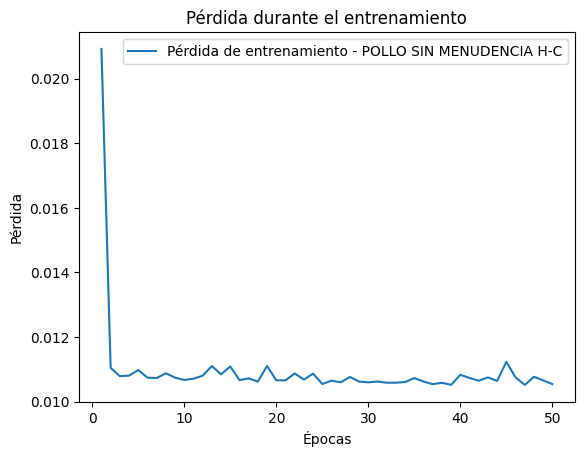

9/9 [==============================] - 1s 6ms/step


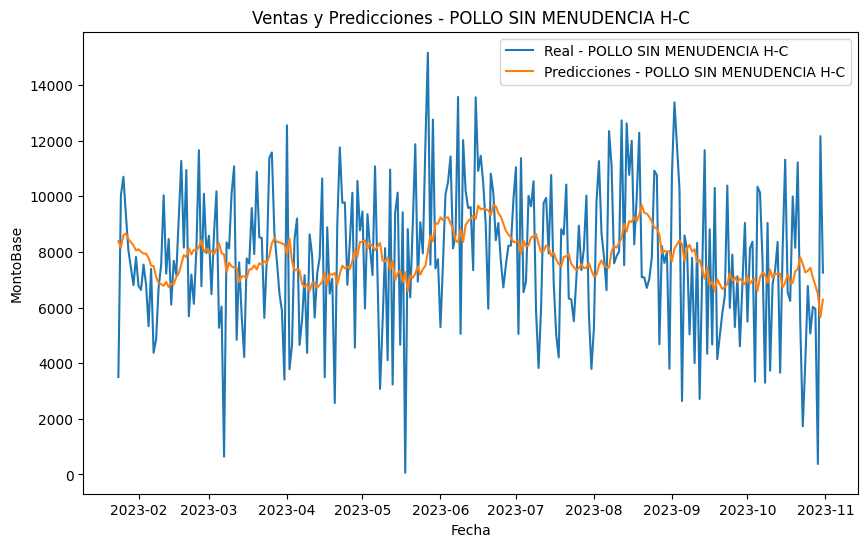

Dimensiones de fechas: (276,)
Dimensiones de predicciones: (275, 1)
La longitud de X_test es: 275 y la longitud de y_test es: 275
Forma de input_data: (27, 30, 1)
Forma de input_data después del reshape: (27, 30, 1)
1/1 [==============================] - 0s 32ms/step
   FechaMovimiento  P-V_LSTM_POLLO SIN MENUDENCIA H-C
0       2023-11-01                          6598.9946
1       2023-11-02                          7088.7153
2       2023-11-03                          7258.3394
3       2023-11-04                          7190.2842
4       2023-11-05                          6889.2104
5       2023-11-06                          7366.9189
6       2023-11-07                          7061.4507
7       2023-11-08                          7208.2012
8       2023-11-09                          7212.0508
9       2023-11-10                          7218.0474
10      2023-11-11                          6720.0186
11      2023-11-12                          6895.2339
12      2023-11-13            

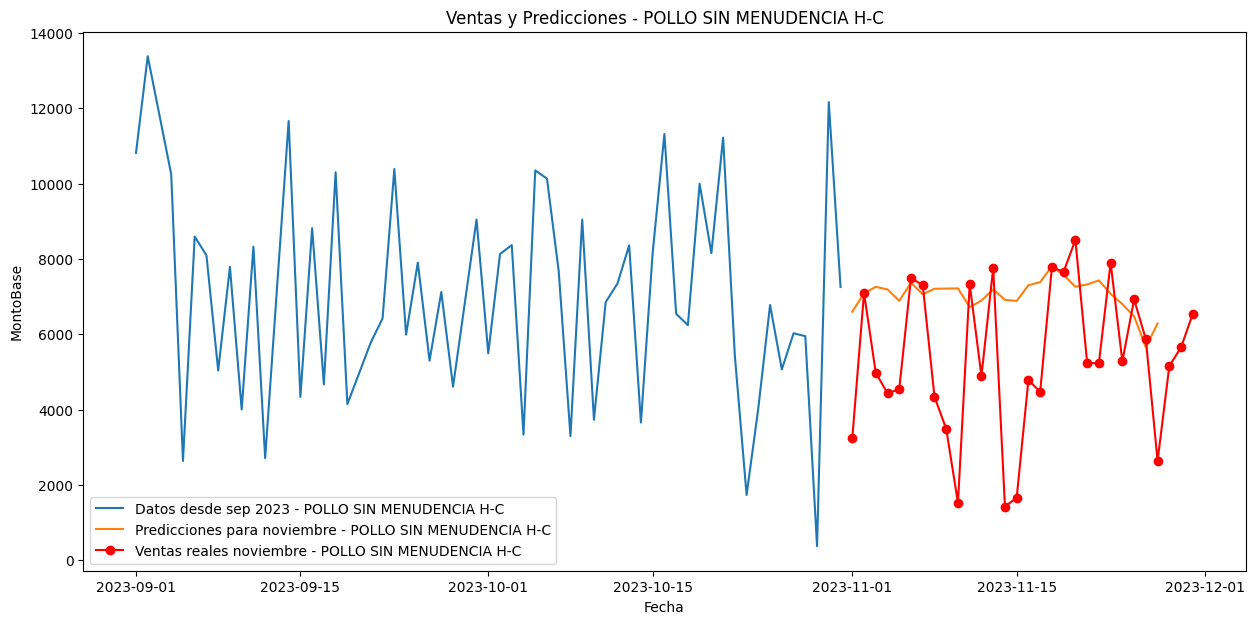

Epoch 1/50
32/32 - 2s - loss: 0.0127 - 2s/epoch - 76ms/step
Epoch 2/50
32/32 - 0s - loss: 0.0089 - 425ms/epoch - 13ms/step
Epoch 3/50
32/32 - 0s - loss: 0.0088 - 399ms/epoch - 12ms/step
Epoch 4/50
32/32 - 0s - loss: 0.0090 - 424ms/epoch - 13ms/step
Epoch 5/50
32/32 - 0s - loss: 0.0090 - 406ms/epoch - 13ms/step
Epoch 6/50
32/32 - 0s - loss: 0.0089 - 407ms/epoch - 13ms/step
Epoch 7/50
32/32 - 0s - loss: 0.0089 - 416ms/epoch - 13ms/step
Epoch 8/50
32/32 - 0s - loss: 0.0090 - 406ms/epoch - 13ms/step
Epoch 9/50
32/32 - 0s - loss: 0.0088 - 425ms/epoch - 13ms/step
Epoch 10/50
32/32 - 0s - loss: 0.0087 - 406ms/epoch - 13ms/step
Epoch 11/50
32/32 - 0s - loss: 0.0088 - 419ms/epoch - 13ms/step
Epoch 12/50
32/32 - 0s - loss: 0.0087 - 437ms/epoch - 14ms/step
Epoch 13/50
32/32 - 0s - loss: 0.0089 - 419ms/epoch - 13ms/step
Epoch 14/50
32/32 - 0s - loss: 0.0087 - 423ms/epoch - 13ms/step
Epoch 15/50
32/32 - 0s - loss: 0.0089 - 436ms/epoch - 14ms/step
Epoch 16/50
32/32 - 1s - loss: 0.0089 - 634ms/epoch 

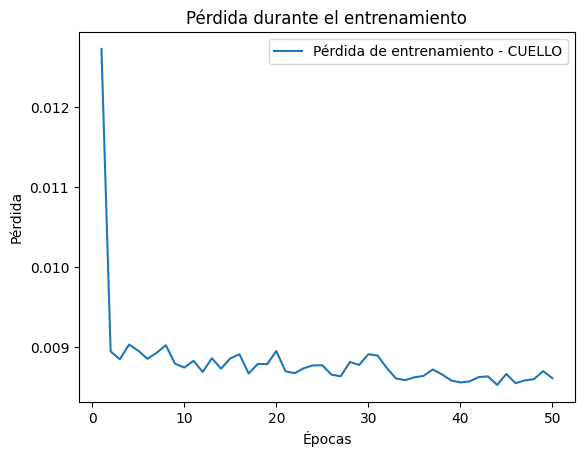

8/8 [==============================] - 0s 7ms/step


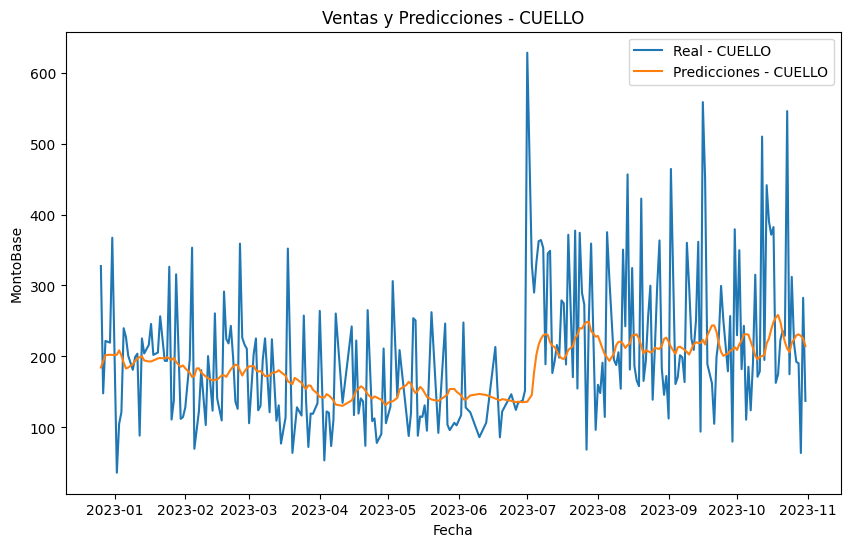

Dimensiones de fechas: (253,)
Dimensiones de predicciones: (252, 1)
La longitud de X_test es: 252 y la longitud de y_test es: 252
Forma de input_data: (28, 30, 1)
Forma de input_data después del reshape: (28, 30, 1)
1/1 [==============================] - 0s 27ms/step
   FechaMovimiento  P-V_LSTM_CUELLO
0       2023-11-01         231.0715
1       2023-11-02         231.3684
2       2023-11-03         230.7255
3       2023-11-04         221.0209
4       2023-11-05         211.9987
5       2023-11-06         201.1738
6       2023-11-07         195.6905
7       2023-11-08         199.6145
8       2023-11-09         200.5792
9       2023-11-10         201.9054
10      2023-11-11         218.5153
11      2023-11-12         225.2866
12      2023-11-13         238.1012
13      2023-11-14         248.7441
14      2023-11-15         254.7427
15      2023-11-16         258.4559
16      2023-11-17         249.0098
17      2023-11-18         233.6322
18      2023-11-19         220.3002
19      2023

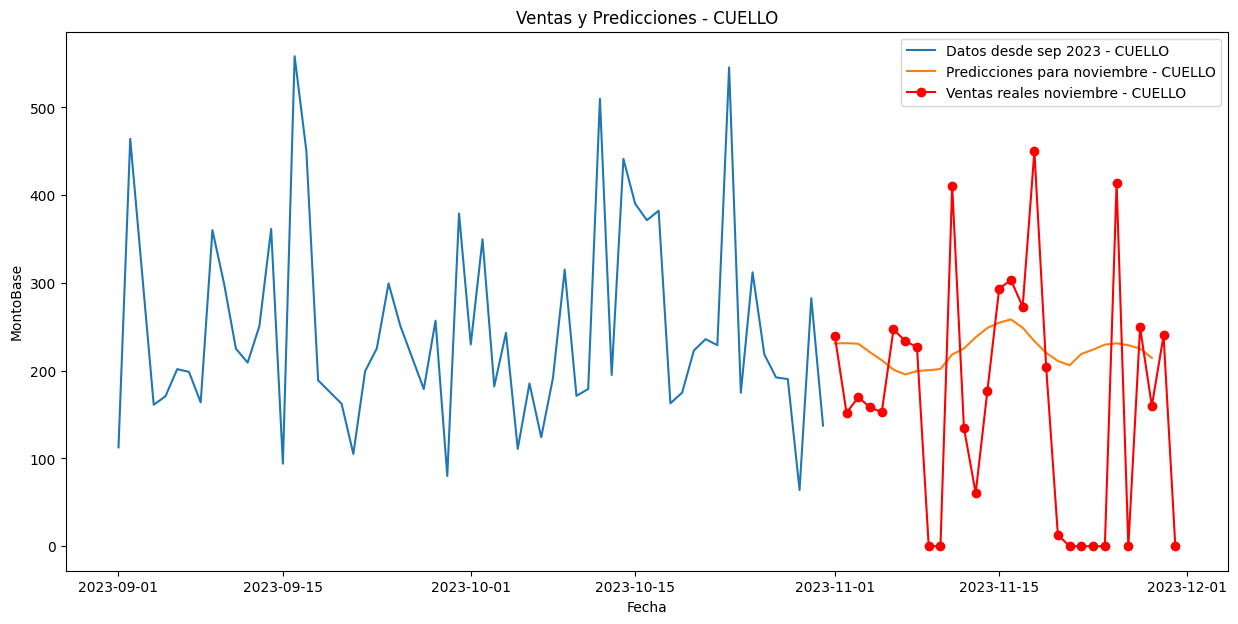

Epoch 1/50
28/28 - 3s - loss: 0.0050 - 3s/epoch - 102ms/step
Epoch 2/50
28/28 - 1s - loss: 0.0045 - 554ms/epoch - 20ms/step
Epoch 3/50
28/28 - 1s - loss: 0.0045 - 560ms/epoch - 20ms/step
Epoch 4/50
28/28 - 1s - loss: 0.0045 - 541ms/epoch - 19ms/step
Epoch 5/50
28/28 - 1s - loss: 0.0045 - 580ms/epoch - 21ms/step
Epoch 6/50
28/28 - 1s - loss: 0.0045 - 563ms/epoch - 20ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0045 - 382ms/epoch - 14ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0045 - 370ms/epoch - 13ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0045 - 372ms/epoch - 13ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0045 - 364ms/epoch - 13ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0045 - 353ms/epoch - 13ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0044 - 433ms/epoch - 15ms/step
Epoch 13/50
28/28 - 1s - loss: 0.0045 - 560ms/epoch - 20ms/step
Epoch 14/50
28/28 - 1s - loss: 0.0045 - 569ms/epoch - 20ms/step
Epoch 15/50
28/28 - 1s - loss: 0.0044 - 546ms/epoch - 20ms/step
Epoch 16/50
28/28 - 1s - loss: 0.0044 - 564ms/epoch

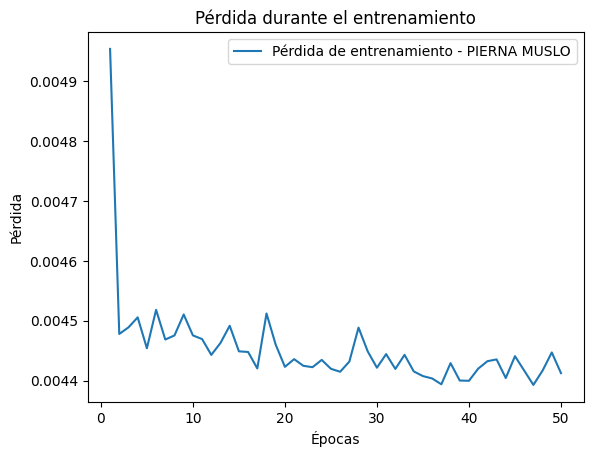

7/7 [==============================] - 0s 7ms/step


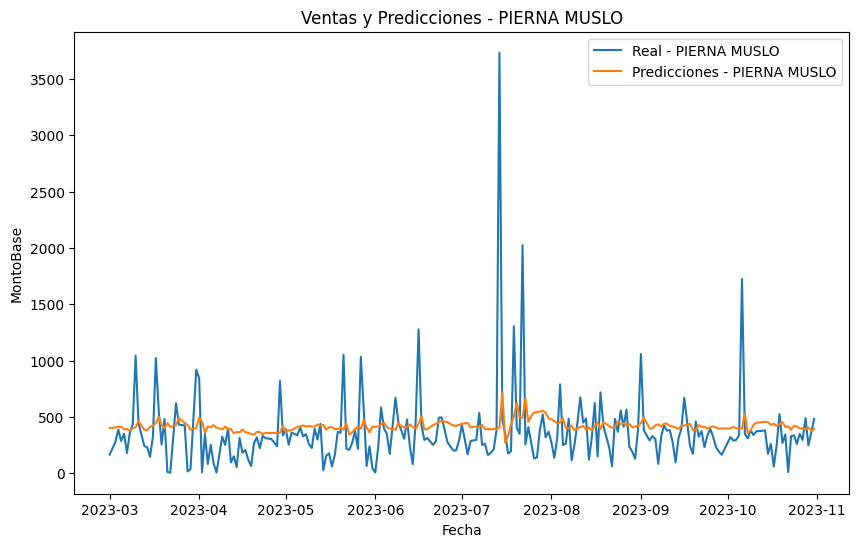

Dimensiones de fechas: (224,)
Dimensiones de predicciones: (223, 1)
La longitud de X_test es: 223 y la longitud de y_test es: 223
Forma de input_data: (25, 30, 1)
Forma de input_data después del reshape: (25, 30, 1)
1/1 [==============================] - 0s 26ms/step
   FechaMovimiento  P-V_LSTM_PIERNA MUSLO
0       2023-11-01               394.1429
1       2023-11-02               397.8954
2       2023-11-03               529.5989
3       2023-11-04               355.3640
4       2023-11-05               378.1511
5       2023-11-06               430.5631
6       2023-11-07               448.4767
7       2023-11-08               456.5438
8       2023-11-09               454.0687
9       2023-11-10               429.5853
10      2023-11-11               440.3142
11      2023-11-12               419.8156
12      2023-11-13               436.6023
13      2023-11-14               454.2886
14      2023-11-15               411.8473
15      2023-11-16               416.1518
16      2023-11-17

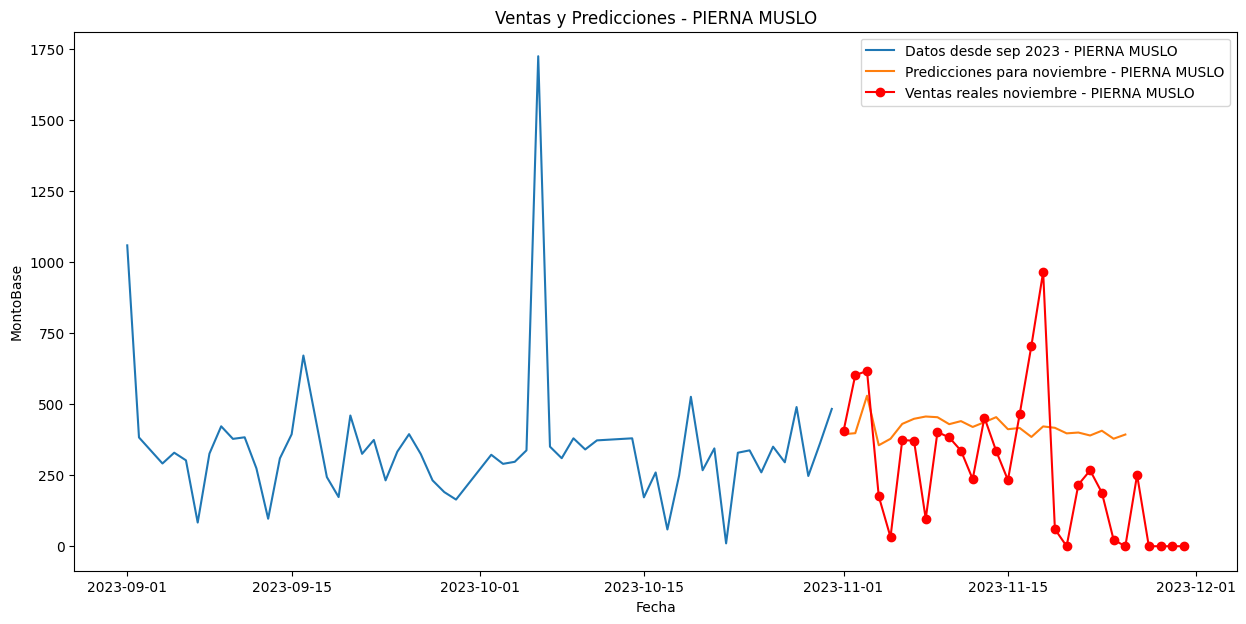

Epoch 1/50
27/27 - 2s - loss: 0.0475 - 2s/epoch - 90ms/step
Epoch 2/50
27/27 - 0s - loss: 0.0212 - 465ms/epoch - 17ms/step
Epoch 3/50
27/27 - 1s - loss: 0.0198 - 561ms/epoch - 21ms/step
Epoch 4/50
27/27 - 1s - loss: 0.0195 - 532ms/epoch - 20ms/step
Epoch 5/50
27/27 - 1s - loss: 0.0195 - 566ms/epoch - 21ms/step
Epoch 6/50
27/27 - 1s - loss: 0.0193 - 574ms/epoch - 21ms/step
Epoch 7/50
27/27 - 1s - loss: 0.0192 - 573ms/epoch - 21ms/step
Epoch 8/50
27/27 - 1s - loss: 0.0191 - 589ms/epoch - 22ms/step
Epoch 9/50
27/27 - 0s - loss: 0.0192 - 414ms/epoch - 15ms/step
Epoch 10/50
27/27 - 0s - loss: 0.0193 - 366ms/epoch - 14ms/step
Epoch 11/50
27/27 - 0s - loss: 0.0190 - 371ms/epoch - 14ms/step
Epoch 12/50
27/27 - 0s - loss: 0.0200 - 354ms/epoch - 13ms/step
Epoch 13/50
27/27 - 0s - loss: 0.0195 - 357ms/epoch - 13ms/step
Epoch 14/50
27/27 - 0s - loss: 0.0191 - 376ms/epoch - 14ms/step
Epoch 15/50
27/27 - 0s - loss: 0.0191 - 353ms/epoch - 13ms/step
Epoch 16/50
27/27 - 0s - loss: 0.0192 - 347ms/epoch 

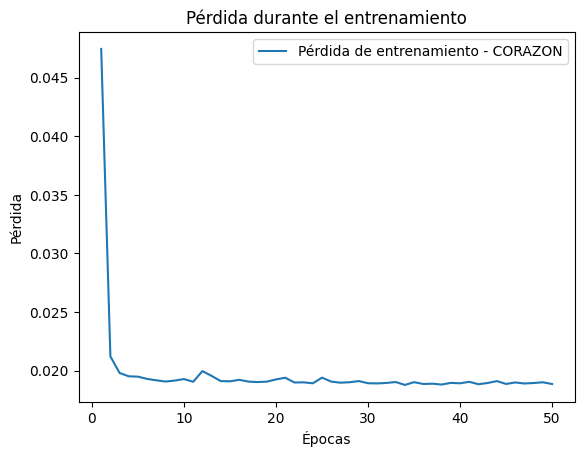

7/7 [==============================] - 1s 11ms/step


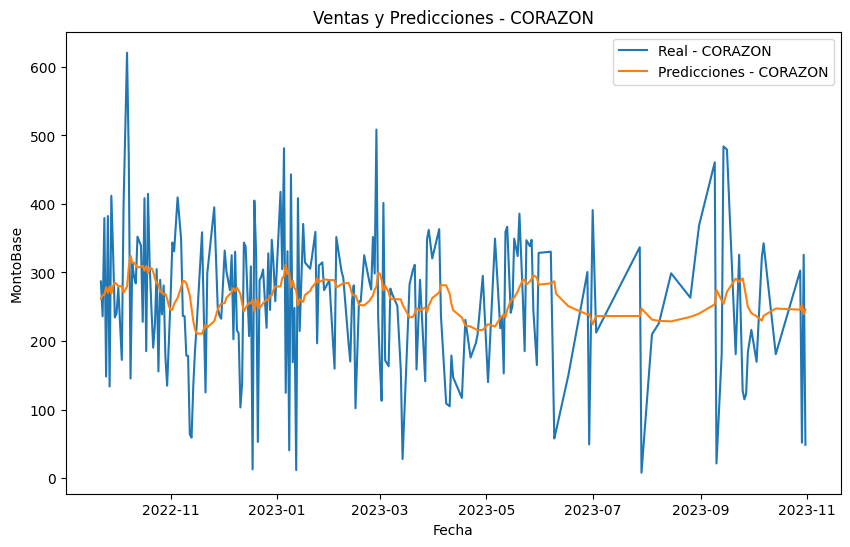

Dimensiones de fechas: (212,)
Dimensiones de predicciones: (211, 1)
La longitud de X_test es: 211 y la longitud de y_test es: 211
No hay suficientes datos después de '2023-09-01' para hacer predicciones futuras.
Epoch 1/50
27/27 - 3s - loss: 0.0292 - 3s/epoch - 113ms/step
Epoch 2/50
27/27 - 0s - loss: 0.0209 - 389ms/epoch - 14ms/step
Epoch 3/50
27/27 - 0s - loss: 0.0209 - 380ms/epoch - 14ms/step
Epoch 4/50
27/27 - 0s - loss: 0.0210 - 379ms/epoch - 14ms/step
Epoch 5/50
27/27 - 0s - loss: 0.0209 - 380ms/epoch - 14ms/step
Epoch 6/50
27/27 - 0s - loss: 0.0210 - 380ms/epoch - 14ms/step
Epoch 7/50
27/27 - 0s - loss: 0.0208 - 363ms/epoch - 13ms/step
Epoch 8/50
27/27 - 0s - loss: 0.0208 - 386ms/epoch - 14ms/step
Epoch 9/50
27/27 - 0s - loss: 0.0207 - 378ms/epoch - 14ms/step
Epoch 10/50
27/27 - 0s - loss: 0.0209 - 394ms/epoch - 15ms/step
Epoch 11/50
27/27 - 0s - loss: 0.0207 - 382ms/epoch - 14ms/step
Epoch 12/50
27/27 - 0s - loss: 0.0208 - 374ms/epoch - 14ms/step
Epoch 13/50
27/27 - 0s - loss: 

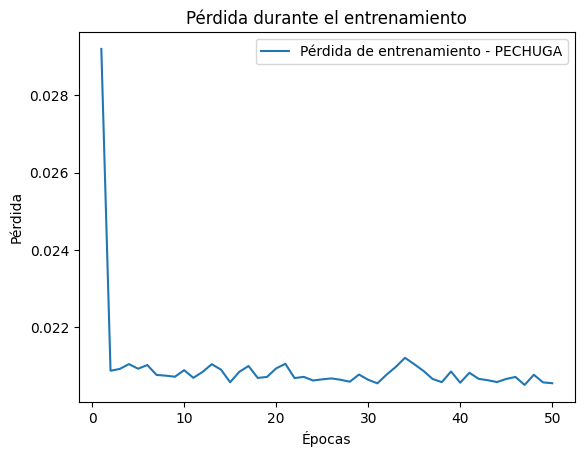

7/7 [==============================] - 0s 6ms/step


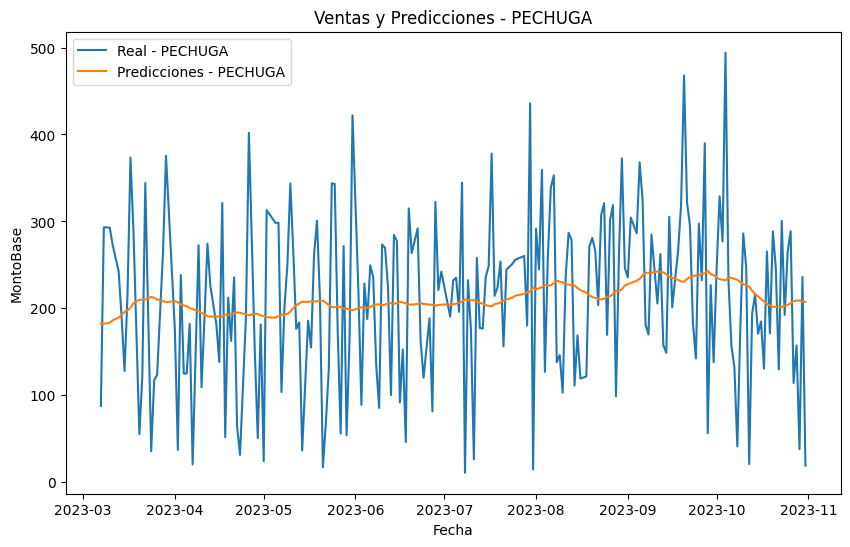

Dimensiones de fechas: (214,)
Dimensiones de predicciones: (213, 1)
La longitud de X_test es: 213 y la longitud de y_test es: 213
Forma de input_data: (28, 30, 1)
Forma de input_data después del reshape: (28, 30, 1)
1/1 [==============================] - 0s 24ms/step
   FechaMovimiento  P-V_LSTM_PECHUGA
0       2023-11-01          232.0284
1       2023-11-02          235.7406
2       2023-11-03          235.1558
3       2023-11-04          233.9720
4       2023-11-05          232.9064
5       2023-11-06          230.2317
6       2023-11-07          228.0357
7       2023-11-08          226.8358
8       2023-11-09          225.0617
9       2023-11-10          220.3902
10      2023-11-11          216.5453
11      2023-11-12          213.8635
12      2023-11-13          210.8112
13      2023-11-14          207.9691
14      2023-11-15          204.9823
15      2023-11-16          203.3466
16      2023-11-17          201.8629
17      2023-11-18          201.7077
18      2023-11-19          2

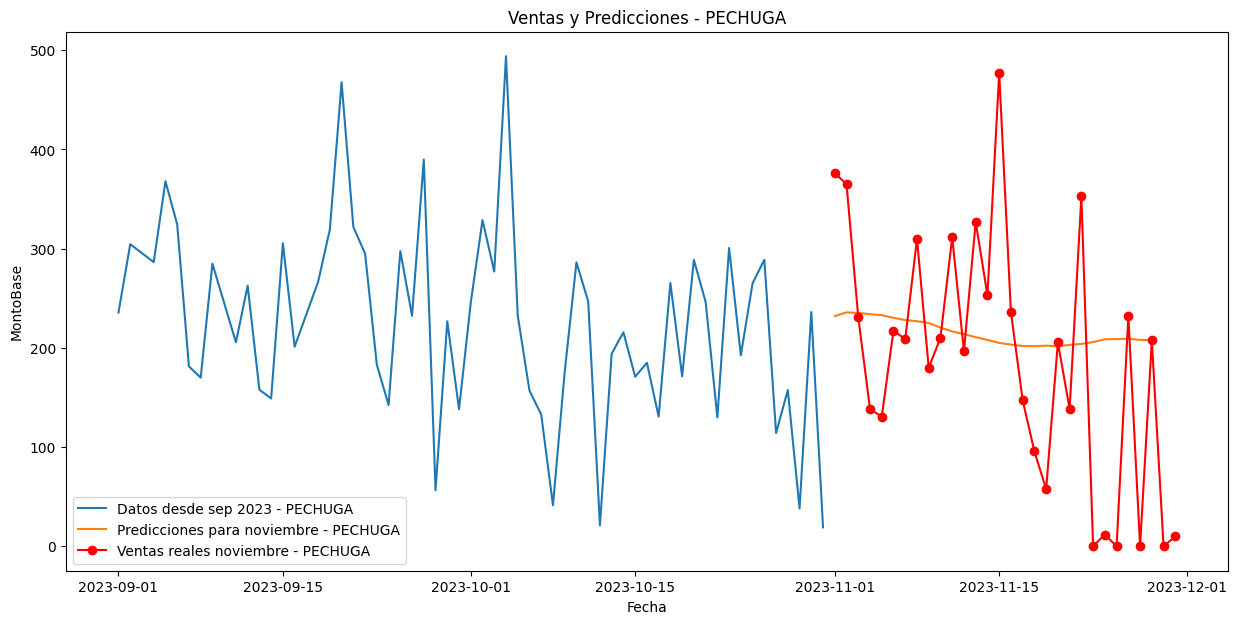

Epoch 1/50
4/4 - 2s - loss: 0.0925 - 2s/epoch - 551ms/step
Epoch 2/50
4/4 - 0s - loss: 0.0587 - 81ms/epoch - 20ms/step
Epoch 3/50
4/4 - 0s - loss: 0.0404 - 82ms/epoch - 20ms/step
Epoch 4/50
4/4 - 0s - loss: 0.0427 - 96ms/epoch - 24ms/step
Epoch 5/50
4/4 - 0s - loss: 0.0421 - 83ms/epoch - 21ms/step
Epoch 6/50
4/4 - 0s - loss: 0.0384 - 86ms/epoch - 21ms/step
Epoch 7/50
4/4 - 0s - loss: 0.0379 - 76ms/epoch - 19ms/step
Epoch 8/50
4/4 - 0s - loss: 0.0384 - 81ms/epoch - 20ms/step
Epoch 9/50
4/4 - 0s - loss: 0.0383 - 76ms/epoch - 19ms/step
Epoch 10/50
4/4 - 0s - loss: 0.0380 - 76ms/epoch - 19ms/step
Epoch 11/50
4/4 - 0s - loss: 0.0377 - 81ms/epoch - 20ms/step
Epoch 12/50
4/4 - 0s - loss: 0.0377 - 81ms/epoch - 20ms/step
Epoch 13/50
4/4 - 0s - loss: 0.0379 - 76ms/epoch - 19ms/step
Epoch 14/50
4/4 - 0s - loss: 0.0376 - 78ms/epoch - 19ms/step
Epoch 15/50
4/4 - 0s - loss: 0.0375 - 76ms/epoch - 19ms/step
Epoch 16/50
4/4 - 0s - loss: 0.0375 - 86ms/epoch - 22ms/step
Epoch 17/50
4/4 - 0s - loss: 0.037

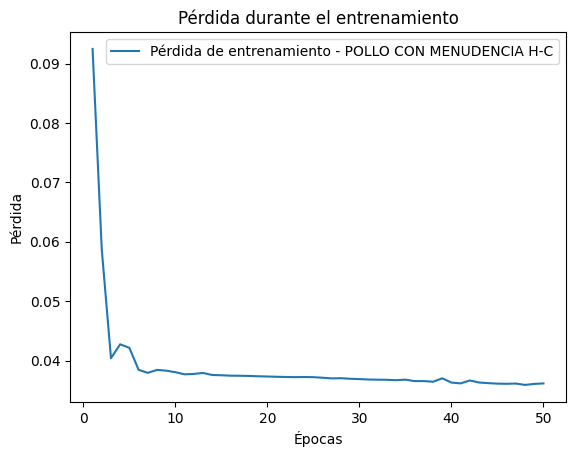

1/1 [==============================] - 1s 701ms/step


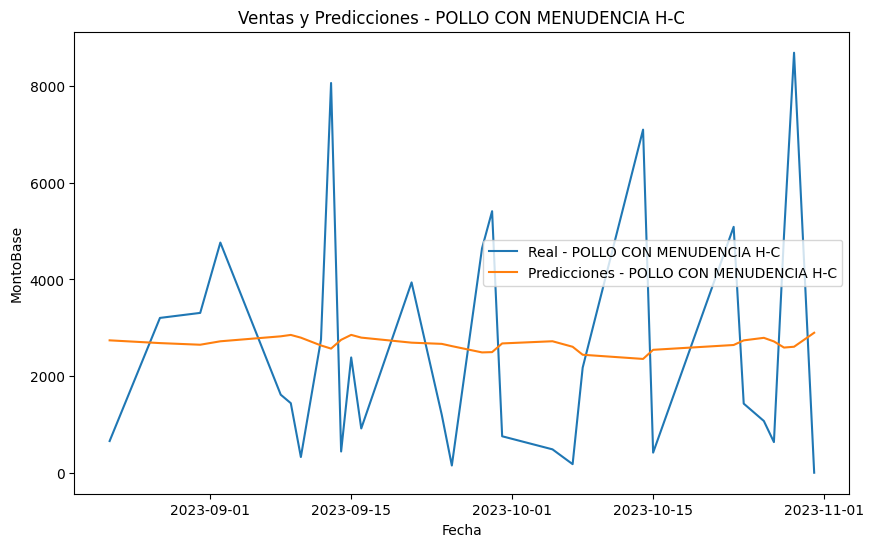

Dimensiones de fechas: (31,)
Dimensiones de predicciones: (30, 1)
La longitud de X_test es: 30 y la longitud de y_test es: 30
No hay suficientes datos después de '2023-09-01' para hacer predicciones futuras.
Epoch 1/50
26/26 - 3s - loss: 0.0156 - 3s/epoch - 97ms/step
Epoch 2/50
26/26 - 0s - loss: 0.0096 - 378ms/epoch - 15ms/step
Epoch 3/50
26/26 - 0s - loss: 0.0091 - 379ms/epoch - 15ms/step
Epoch 4/50
26/26 - 0s - loss: 0.0089 - 386ms/epoch - 15ms/step
Epoch 5/50
26/26 - 0s - loss: 0.0090 - 380ms/epoch - 15ms/step
Epoch 6/50
26/26 - 0s - loss: 0.0090 - 383ms/epoch - 15ms/step
Epoch 7/50
26/26 - 0s - loss: 0.0090 - 383ms/epoch - 15ms/step
Epoch 8/50
26/26 - 0s - loss: 0.0089 - 361ms/epoch - 14ms/step
Epoch 9/50
26/26 - 0s - loss: 0.0088 - 370ms/epoch - 14ms/step
Epoch 10/50
26/26 - 0s - loss: 0.0089 - 393ms/epoch - 15ms/step
Epoch 11/50
26/26 - 0s - loss: 0.0087 - 365ms/epoch - 14ms/step
Epoch 12/50
26/26 - 0s - loss: 0.0088 - 366ms/epoch - 14ms/step
Epoch 13/50
26/26 - 0s - loss: 0.008

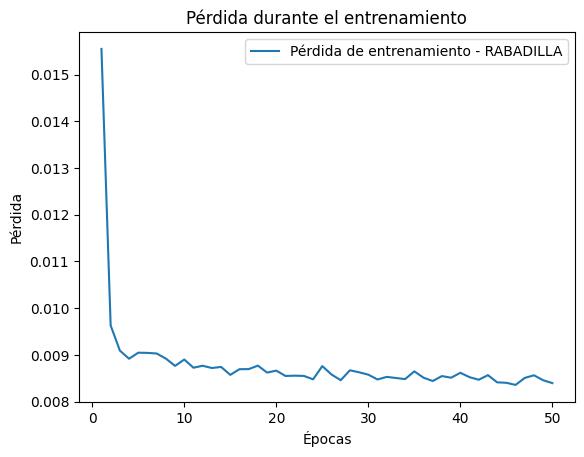

7/7 [==============================] - 0s 7ms/step


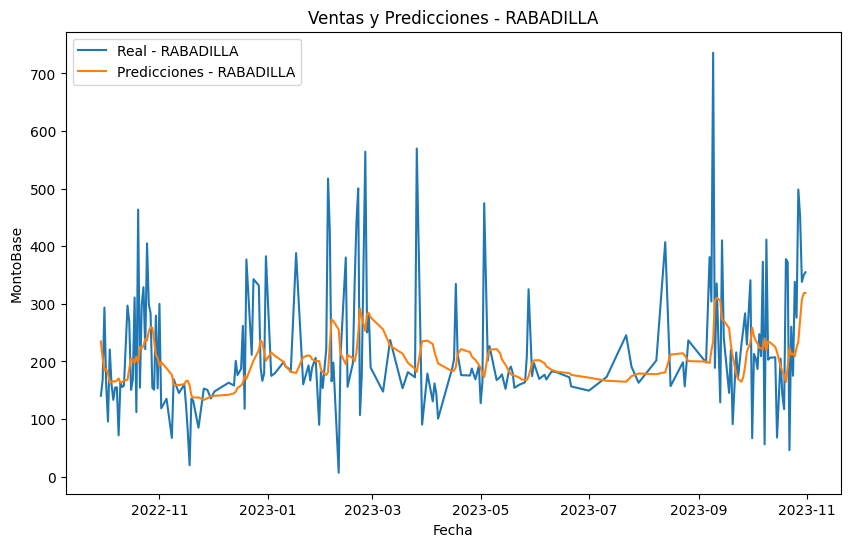

Dimensiones de fechas: (205,)
Dimensiones de predicciones: (204, 1)
La longitud de X_test es: 204 y la longitud de y_test es: 204
Forma de input_data: (17, 30, 1)
Forma de input_data después del reshape: (17, 30, 1)
1/1 [==============================] - 0s 35ms/step
   FechaMovimiento  P-V_LSTM_RABADILLA
0       2023-11-01            225.3824
1       2023-11-02            216.5515
2       2023-11-03            191.9460
3       2023-11-04            183.0405
4       2023-11-05            176.0085
5       2023-11-06            164.1955
6       2023-11-07            189.6972
7       2023-11-08            223.4565
8       2023-11-09            211.7231
9       2023-11-10            213.8789
10      2023-11-11            209.0743
11      2023-11-12            223.9808
12      2023-11-13            234.5656
13      2023-11-14            272.1017
14      2023-11-15            307.2326
15      2023-11-16            318.3351
16      2023-11-17            319.0984


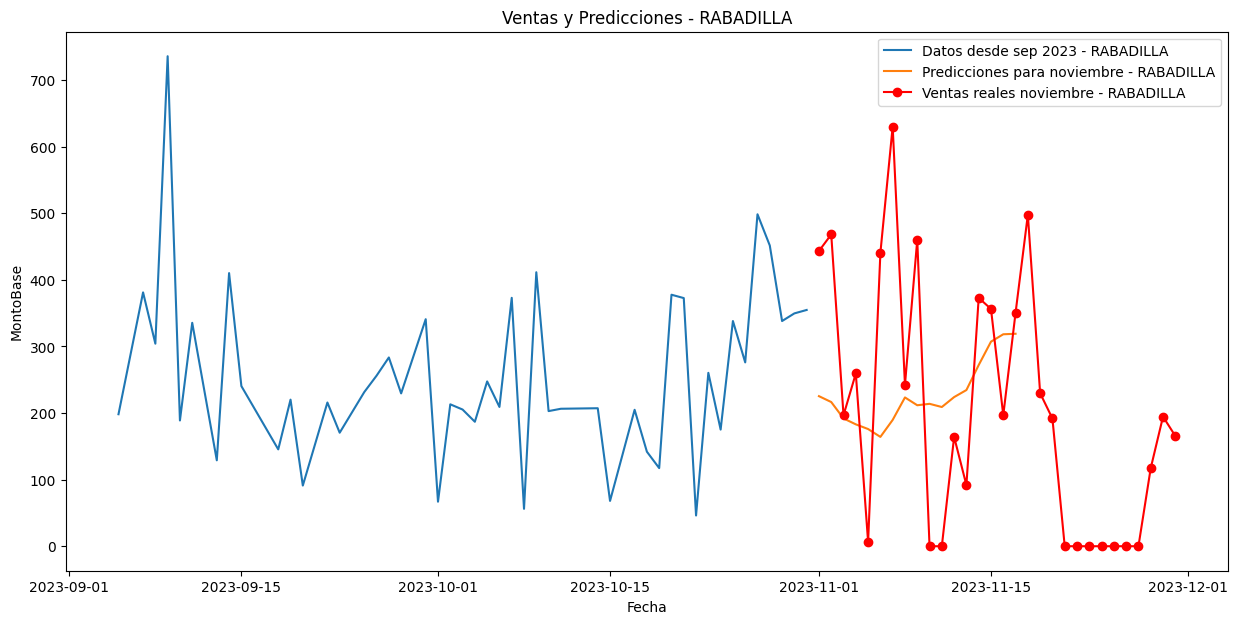

Epoch 1/50
5/5 - 3s - loss: 0.0573 - 3s/epoch - 596ms/step
Epoch 2/50
5/5 - 0s - loss: 0.0294 - 95ms/epoch - 19ms/step
Epoch 3/50
5/5 - 0s - loss: 0.0183 - 103ms/epoch - 21ms/step
Epoch 4/50
5/5 - 0s - loss: 0.0201 - 96ms/epoch - 19ms/step
Epoch 5/50
5/5 - 0s - loss: 0.0177 - 93ms/epoch - 19ms/step
Epoch 6/50
5/5 - 0s - loss: 0.0169 - 89ms/epoch - 18ms/step
Epoch 7/50
5/5 - 0s - loss: 0.0173 - 101ms/epoch - 20ms/step
Epoch 8/50
5/5 - 0s - loss: 0.0172 - 94ms/epoch - 19ms/step
Epoch 9/50
5/5 - 0s - loss: 0.0169 - 91ms/epoch - 18ms/step
Epoch 10/50
5/5 - 0s - loss: 0.0166 - 96ms/epoch - 19ms/step
Epoch 11/50
5/5 - 0s - loss: 0.0167 - 94ms/epoch - 19ms/step
Epoch 12/50
5/5 - 0s - loss: 0.0166 - 92ms/epoch - 18ms/step
Epoch 13/50
5/5 - 0s - loss: 0.0165 - 112ms/epoch - 22ms/step
Epoch 14/50
5/5 - 0s - loss: 0.0166 - 87ms/epoch - 17ms/step
Epoch 15/50
5/5 - 0s - loss: 0.0166 - 95ms/epoch - 19ms/step
Epoch 16/50
5/5 - 0s - loss: 0.0167 - 92ms/epoch - 18ms/step
Epoch 17/50
5/5 - 0s - loss: 0.

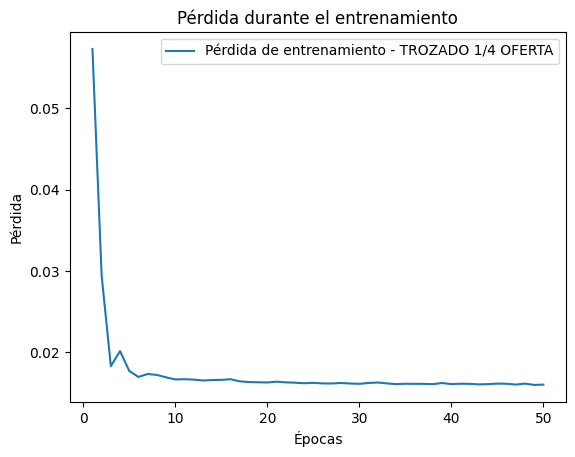

2/2 [==============================] - 0s 9ms/step


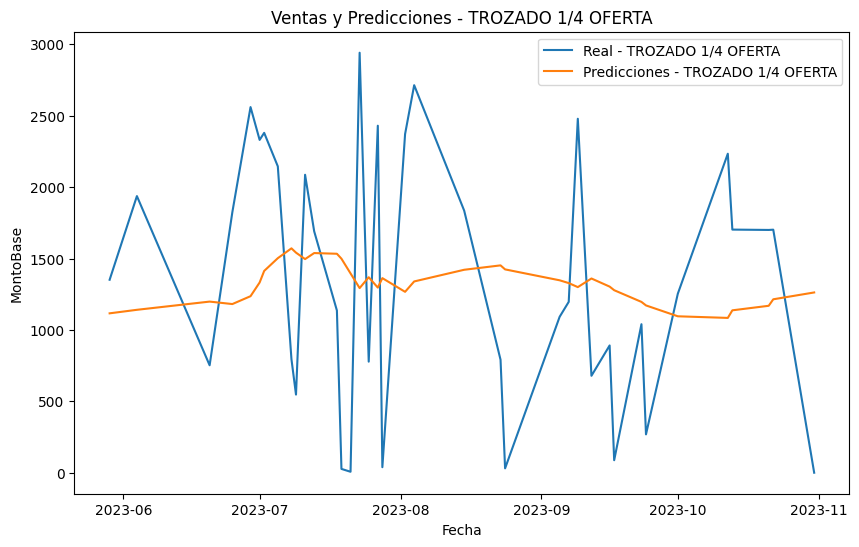

Dimensiones de fechas: (39,)
Dimensiones de predicciones: (38, 1)
La longitud de X_test es: 38 y la longitud de y_test es: 38
No hay suficientes datos después de '2023-09-01' para hacer predicciones futuras.
Epoch 1/50
6/6 - 2s - loss: 0.0265 - 2s/epoch - 373ms/step
Epoch 2/50
6/6 - 0s - loss: 0.0168 - 110ms/epoch - 18ms/step
Epoch 3/50
6/6 - 0s - loss: 0.0162 - 109ms/epoch - 18ms/step
Epoch 4/50
6/6 - 0s - loss: 0.0161 - 108ms/epoch - 18ms/step
Epoch 5/50
6/6 - 0s - loss: 0.0159 - 110ms/epoch - 18ms/step
Epoch 6/50
6/6 - 0s - loss: 0.0157 - 114ms/epoch - 19ms/step
Epoch 7/50
6/6 - 0s - loss: 0.0158 - 109ms/epoch - 18ms/step
Epoch 8/50
6/6 - 0s - loss: 0.0159 - 123ms/epoch - 20ms/step
Epoch 9/50
6/6 - 0s - loss: 0.0156 - 118ms/epoch - 20ms/step
Epoch 10/50
6/6 - 0s - loss: 0.0157 - 159ms/epoch - 27ms/step
Epoch 11/50
6/6 - 0s - loss: 0.0157 - 139ms/epoch - 23ms/step
Epoch 12/50
6/6 - 0s - loss: 0.0156 - 143ms/epoch - 24ms/step
Epoch 13/50
6/6 - 0s - loss: 0.0157 - 124ms/epoch - 21ms/st

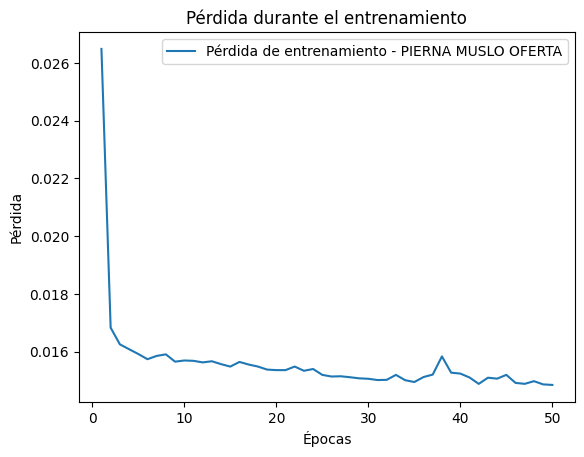

2/2 [==============================] - 0s 11ms/step


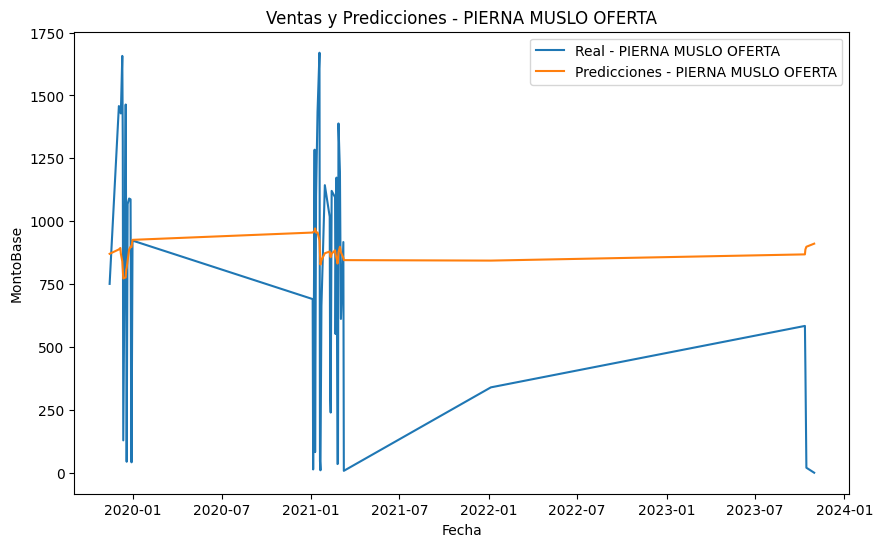

Dimensiones de fechas: (48,)
Dimensiones de predicciones: (47, 1)
La longitud de X_test es: 47 y la longitud de y_test es: 47
No hay suficientes datos después de '2023-09-01' para hacer predicciones futuras.
Epoch 1/50
8/8 - 3s - loss: 0.0235 - 3s/epoch - 352ms/step
Epoch 2/50
8/8 - 0s - loss: 0.0182 - 139ms/epoch - 17ms/step
Epoch 3/50
8/8 - 0s - loss: 0.0141 - 127ms/epoch - 16ms/step
Epoch 4/50
8/8 - 0s - loss: 0.0137 - 139ms/epoch - 17ms/step
Epoch 5/50
8/8 - 0s - loss: 0.0132 - 140ms/epoch - 18ms/step
Epoch 6/50
8/8 - 0s - loss: 0.0128 - 144ms/epoch - 18ms/step
Epoch 7/50
8/8 - 0s - loss: 0.0125 - 133ms/epoch - 17ms/step
Epoch 8/50
8/8 - 0s - loss: 0.0124 - 171ms/epoch - 21ms/step
Epoch 9/50
8/8 - 0s - loss: 0.0121 - 193ms/epoch - 24ms/step
Epoch 10/50
8/8 - 0s - loss: 0.0121 - 183ms/epoch - 23ms/step
Epoch 11/50
8/8 - 0s - loss: 0.0119 - 199ms/epoch - 25ms/step
Epoch 12/50
8/8 - 0s - loss: 0.0118 - 184ms/epoch - 23ms/step
Epoch 13/50
8/8 - 0s - loss: 0.0116 - 154ms/epoch - 19ms/st

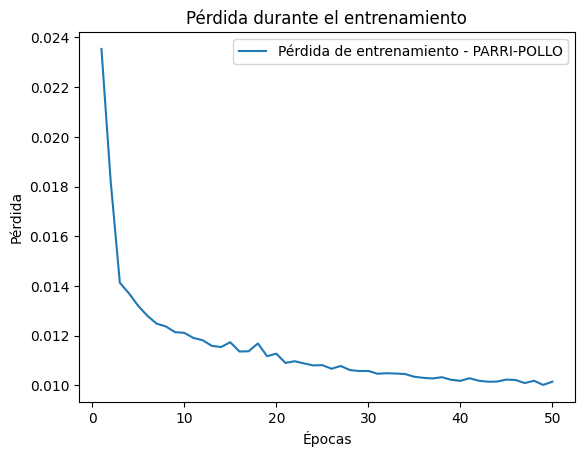

2/2 [==============================] - 0s 15ms/step


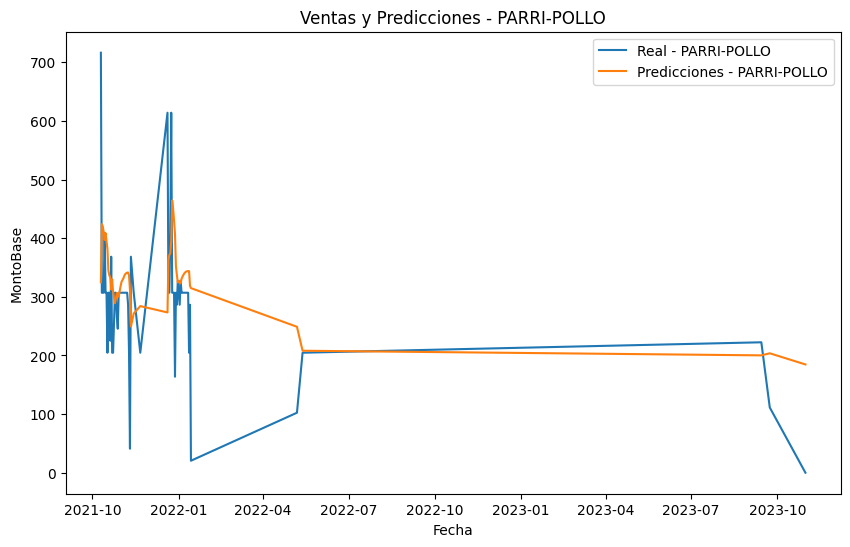

Dimensiones de fechas: (64,)
Dimensiones de predicciones: (63, 1)
La longitud de X_test es: 63 y la longitud de y_test es: 63
No hay suficientes datos después de '2023-09-01' para hacer predicciones futuras.


In [ ]:
# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_lstm
for product, product_df_lstm in dfs_de_productos_sumados_lstm.items():

    # Normalizar los datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    product_df_lstm['MontoBase_scaler'] = scaler.fit_transform(product_df_lstm['MontoBase'].values.reshape(-1, 1))

    # Crear secuencias temporales
    seq_length = 30
    X, y = create_sequences(product_df_lstm['MontoBase_scaler'].values, seq_length)

    # Dividir en conjuntos de entrenamiento y prueba
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape para el modelo LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Construir el modelo LSTM
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

    # Visualizar la pérdida durante el entrenamiento
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label=f'Pérdida de entrenamiento - {product}')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()
    # Hacer predicciones en el conjunto de prueba
    predictions = model.predict(X_test)

    # Desnormalizar las predicciones
    predictions = scaler.inverse_transform(predictions)

    # Visualizar las predicciones
    plt.figure(figsize=(10, 6))
    plt.plot(product_df_lstm.index[train_size+seq_length:], product_df_lstm['MontoBase'].values[train_size+seq_length:], label='Real - ' + product)
    plt.plot(product_df_lstm.index[train_size+seq_length:], predictions, label='Predicciones - ' + product)
    plt.title('Ventas y Predicciones - ' + product)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend()
    plt.show()

    # Hacer predicciones para el futuro
    last_data = product_df_lstm[product_df_lstm.index >= '2023-09-01']['MontoBase'].values


    print("Dimensiones de fechas:", product_df_lstm.index[train_size+seq_length-1:].shape)
    print("Dimensiones de predicciones:", predictions.shape)

    print(f'La longitud de X_test es: {X_test.shape[0]} y la longitud de y_test es: {y_test.shape[0]}')

    # Verificar si hay datos disponibles después de '2023-09-01'
    if len(last_data) >= seq_length:
        last_data = scaler.transform(last_data.reshape(-1, 1))
        input_data, _ = create_sequences(last_data, seq_length)

        # Imprimir la forma de input_data para depuración
        print("Forma de input_data:", input_data.shape)

        # Verificar si input_data está vacío antes del reshape
        if input_data.shape[0] == 0:
            print("¡Error! input_data está vacío.")
        else:
            # Reshape para el modelo LSTM
            input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))
            # Imprimir la forma después del reshape para depuración
            print("Forma de input_data después del reshape:", input_data.shape)

        # Hacer predicciones para el futuro
        predictions_future = model.predict(input_data)
        #predictions_future_nov = model.predict(last_data)

        # Desnormalizar las predicciones
        predictions_future = scaler.inverse_transform(predictions_future)

        # Almacenar las predicciones en un DataFrame auxiliar
        # Crear un DataFrame auxiliar con fechas futuras
        future_dates = pd.date_range(start='2023-11-01', periods=len(predictions_future))
        predictions_df_lstm = pd.DataFrame({'FechaMovimiento': future_dates, f'P-V_LSTM_{product}': predictions_future.flatten()})

        # Imprimir el DataFrame de predicciones futuras para depuración
        print(predictions_df_lstm)

        # Fusionar el DataFrame de predicciones futuras con el DataFrame principal
        dfs_noviembre_sumados[product] = pd.merge(dfs_noviembre_sumados[product], predictions_df_lstm, on='FechaMovimiento', how='left')

        # Llenar los valores NaN con 0
        dfs_noviembre_sumados[product][f'P-V_LSTM_{product}'].fillna(0, inplace=True)

        # Visualizar los resultados
        plt.figure(figsize=(15, 7))
        # Datos de venta desde el 1ro de septiembre de 2023
        start_date = '2023-09-01'
        end_date = '2023-11-30'
        plt.plot(product_df_lstm.index[product_df_lstm.index >= start_date], product_df_lstm['MontoBase'][product_df_lstm.index >= start_date], label='Datos desde sep 2023 - ' + product)
        # Predicciones para el futuro (noviembre)
        dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_future))
        plt.plot(dates_future[:len(predictions_future)], predictions_future, label='Predicciones para noviembre - ' + product)
        # Datos reales de noviembre
        real_november_data = dfs_noviembre_sumados[product]
        plt.plot(real_november_data['FechaMovimiento'], real_november_data['MontoBase'], 'o-', color='red', label='Ventas reales noviembre - ' + product)
        plt.title('Ventas y Predicciones - ' + product)
        plt.xlabel('Fecha')
        plt.ylabel('MontoBase')
        plt.legend()
        plt.show()
    else:
        print("No hay suficientes datos después de '2023-09-01' para hacer predicciones futuras.")
        # # Almacenar las predicciones en el objeto principal
        # dfs_noviembre_sumados[product] = pd.merge(dfs_noviembre_sumados[product], predictions_df_lstm, on='FechaMovimiento', how='left')


In [ ]:
dfs_noviembre_sumados

{'POLLO SIN MENUDENCIA H-C':               NombreProducto  MontoBase FechaMovimiento  \
 0   POLLO SIN MENUDENCIA H-C  3239.2974      2023-11-01   
 1   POLLO SIN MENUDENCIA H-C  7098.1327      2023-11-02   
 2   POLLO SIN MENUDENCIA H-C  4978.8291      2023-11-03   
 3   POLLO SIN MENUDENCIA H-C  4431.8618      2023-11-04   
 4   POLLO SIN MENUDENCIA H-C  4541.8035      2023-11-05   
 5   POLLO SIN MENUDENCIA H-C  7492.0734      2023-11-06   
 6   POLLO SIN MENUDENCIA H-C  7305.7163      2023-11-07   
 7   POLLO SIN MENUDENCIA H-C  4343.5560      2023-11-08   
 8   POLLO SIN MENUDENCIA H-C  3487.1891      2023-11-09   
 9   POLLO SIN MENUDENCIA H-C  1528.0410      2023-11-10   
 10  POLLO SIN MENUDENCIA H-C  7330.7520      2023-11-11   
 11  POLLO SIN MENUDENCIA H-C  4889.5888      2023-11-12   
 12  POLLO SIN MENUDENCIA H-C  7760.8445      2023-11-13   
 13  POLLO SIN MENUDENCIA H-C  1427.7825      2023-11-14   
 14  POLLO SIN MENUDENCIA H-C  1659.6720      2023-11-15   
 15  POLLO S

## Evaluar LSTM




In [ ]:
for product, product_df in dfs_noviembre_sumados.items():
    # print(product_df.head(30))

    # Verificar si la columna 'P-V_LSTM_{product}' existe
    if f'P-V_LSTM_{product}' in dfs_noviembre_sumados[product].columns:
        print(f'evaluacion del producto: {product}')
        # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
        evaluacion_metrica(
            dfs_noviembre_sumados[product]['MontoBase'],
            dfs_noviembre_sumados[product][f'P-V_LSTM_{product}']
        )
        print('\n')
    else:
        print(f"No hay predicciones para {product}.")

evaluacion del producto: POLLO SIN MENUDENCIA H-C
Evaluation metric results:-
MSE is : 9657654.419696117
MAE is : 2412.690886067708
R2 is : -1.496434845147625 %
------------------------------
RMSE is : 3107.6766916293136
MAPE is : 75.74966050758148 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------





evaluacion del producto: CUELLO
Evaluation metric results:-
MSE is : 20521.106254624126
MAE is : 115.47372096435546
R2 is : -0.14143763457976388 %
------------------------------
RMSE is : 143.25189790932657
MAPE is : 113.21843931333551 %
------------------------------
------------------------------
Días reales calculados: 22
Días omitidos: 8
Total de días: 30
------------------------------





evaluacion del producto: PIERNA MUSLO
Evaluation metric results:-
MSE is : 52097.44042734821
MAE is : 173.82465091145835
R2 is : 0.08282552739338322 %
------------------------------
RMSE is :

# ARIMA

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

from pmdarima.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from pmdarima import auto_arima

In [ ]:
dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'].dtypes

NombreProducto     object
MontoBase         float64
dtype: object

In [ ]:
dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1402 entries, 2018-11-03 to 2023-10-31
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NombreProducto  1402 non-null   object 
 1   MontoBase       1402 non-null   float64
dtypes: float64(1), object(1)
memory usage: 32.9+ KB


Predicciones para POLLO SIN MENUDENCIA H-C:


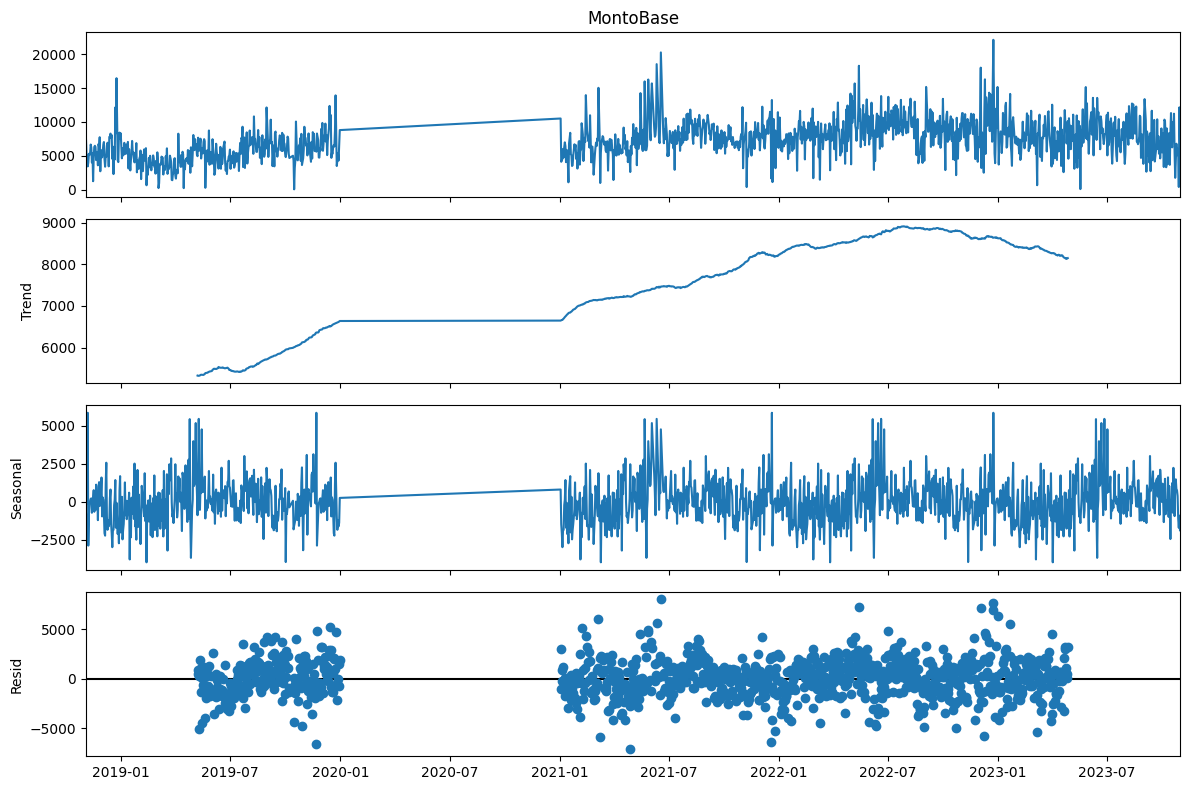

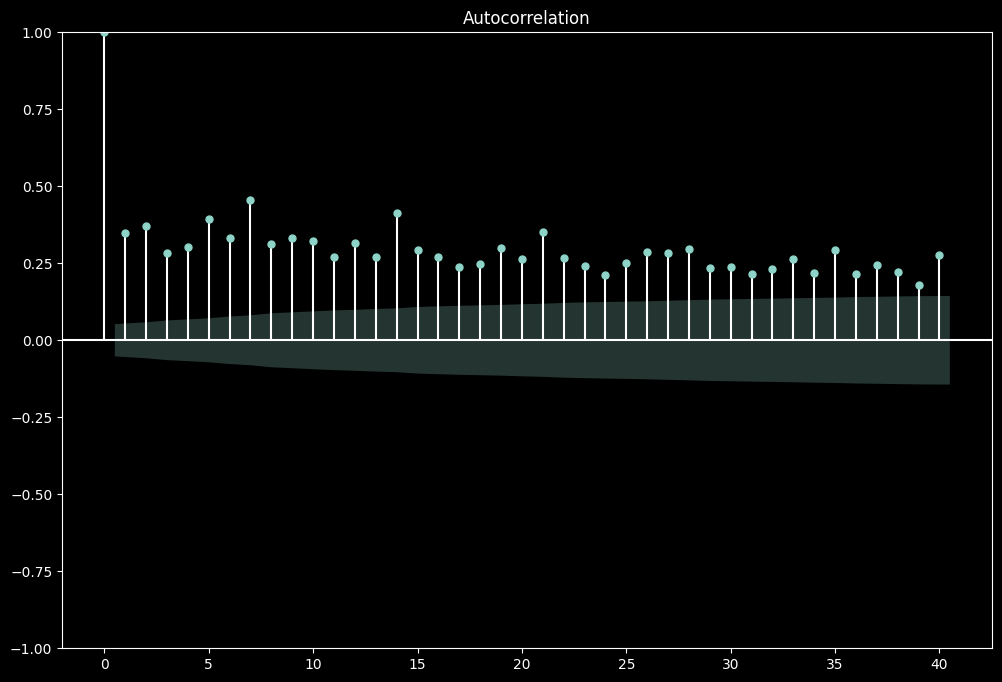

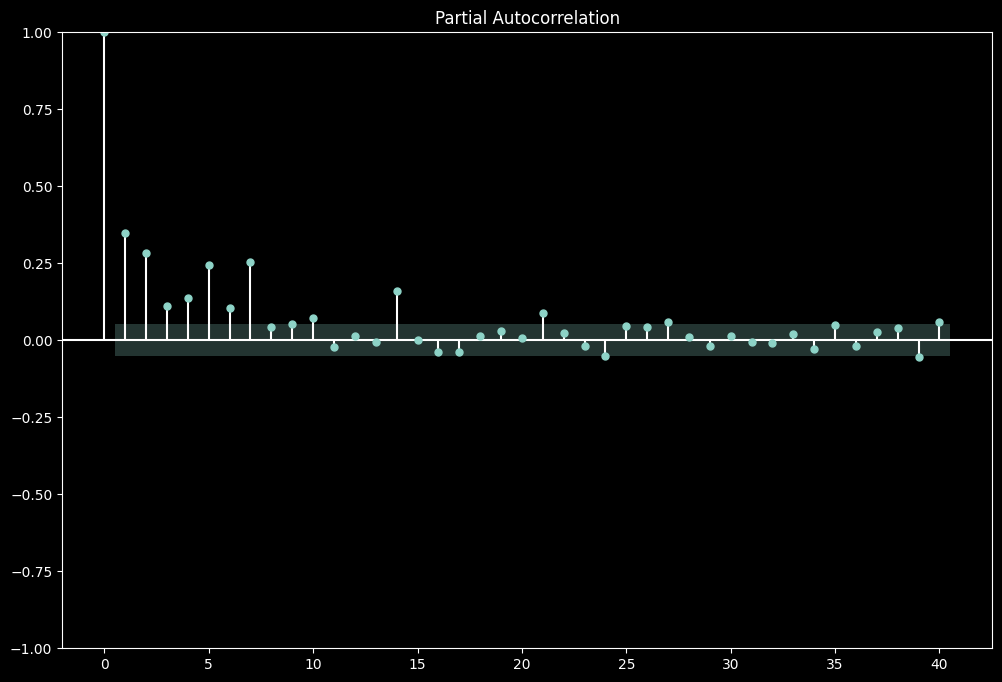

(1371, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=25124.798, Time=16.60 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=25942.810, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=25516.950, Time=1.57 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=25148.461, Time=1.39 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=25940.810, Time=0.08 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=25129.224, Time=14.86 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=25129.231, Time=16.11 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=25118.314, Time=27.95 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=25120.895, Time=9.02 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=25120.231, Time=24.50 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=25118.603, Time=23.37 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=25116.885, Time=20.60 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=25123.434, Time=5.93 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=25119

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

el ultimo indice_valor de los datos reales es: 1371,
se supone que deeria acabar 30 despues, pero la funcion indica: 1400 

2023-10-01   7067.6785
2023-10-02   7808.4826
2023-10-03   7092.0157
2023-10-04   7096.3559
2023-10-05   7188.4194
2023-10-06   7293.8588
2023-10-07   7479.1469
2023-10-08   7197.1551
2023-10-09   7675.2218
2023-10-10   6892.7337
2023-10-11   7389.1312
2023-10-12   6885.4084
2023-10-13   7448.4552
2023-10-14   7309.1086
2023-10-15   7510.6313
2023-10-16   7358.8365
2023-10-17   7347.4056
2023-10-18   7030.2585
2023-10-19   7540.9864
2023-10-20   7212.7809
2023-10-21   7708.9629
2023-10-22   7126.0427
2023-10-23   7623.3497
2023-10-24   6941.6451
2023-10-25   7423.5121
2023-10-26   7280.5898
2023-10-27   7453.9327
2023-10-28   7373.6730
2023-10-29   7359.0078
2023-10-30   7182.2631
Freq: D, Name: ARIMA Predictions POLLO SIN MENUDENCIA H-C, dtype: float64

Ventas reales y predicciones ARIMA para POLLO SIN MENUDENCIA H-C:
    MontoBase  P-V_ARIMA_POLLO SIN MENUDENCIA

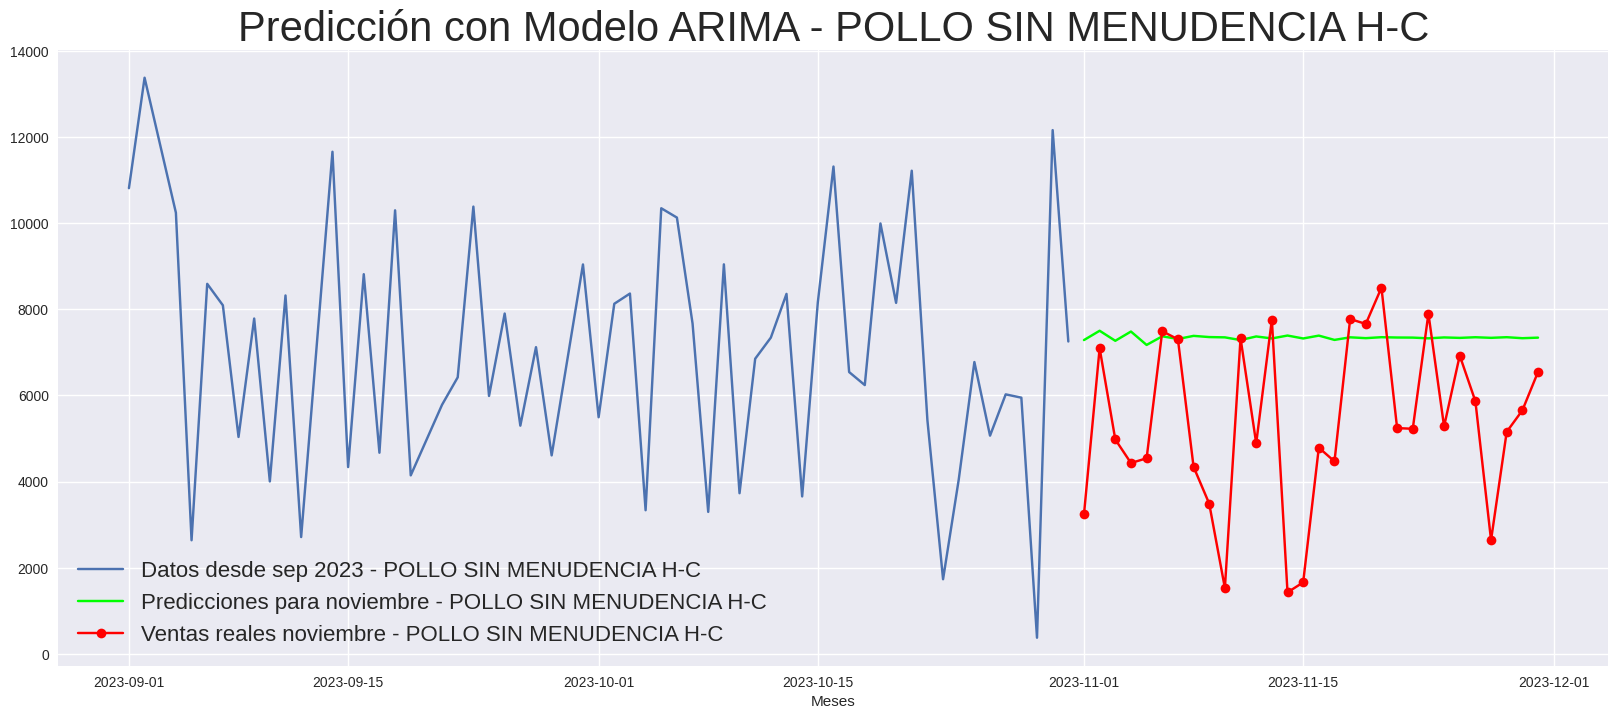

Predicciones para CUELLO:


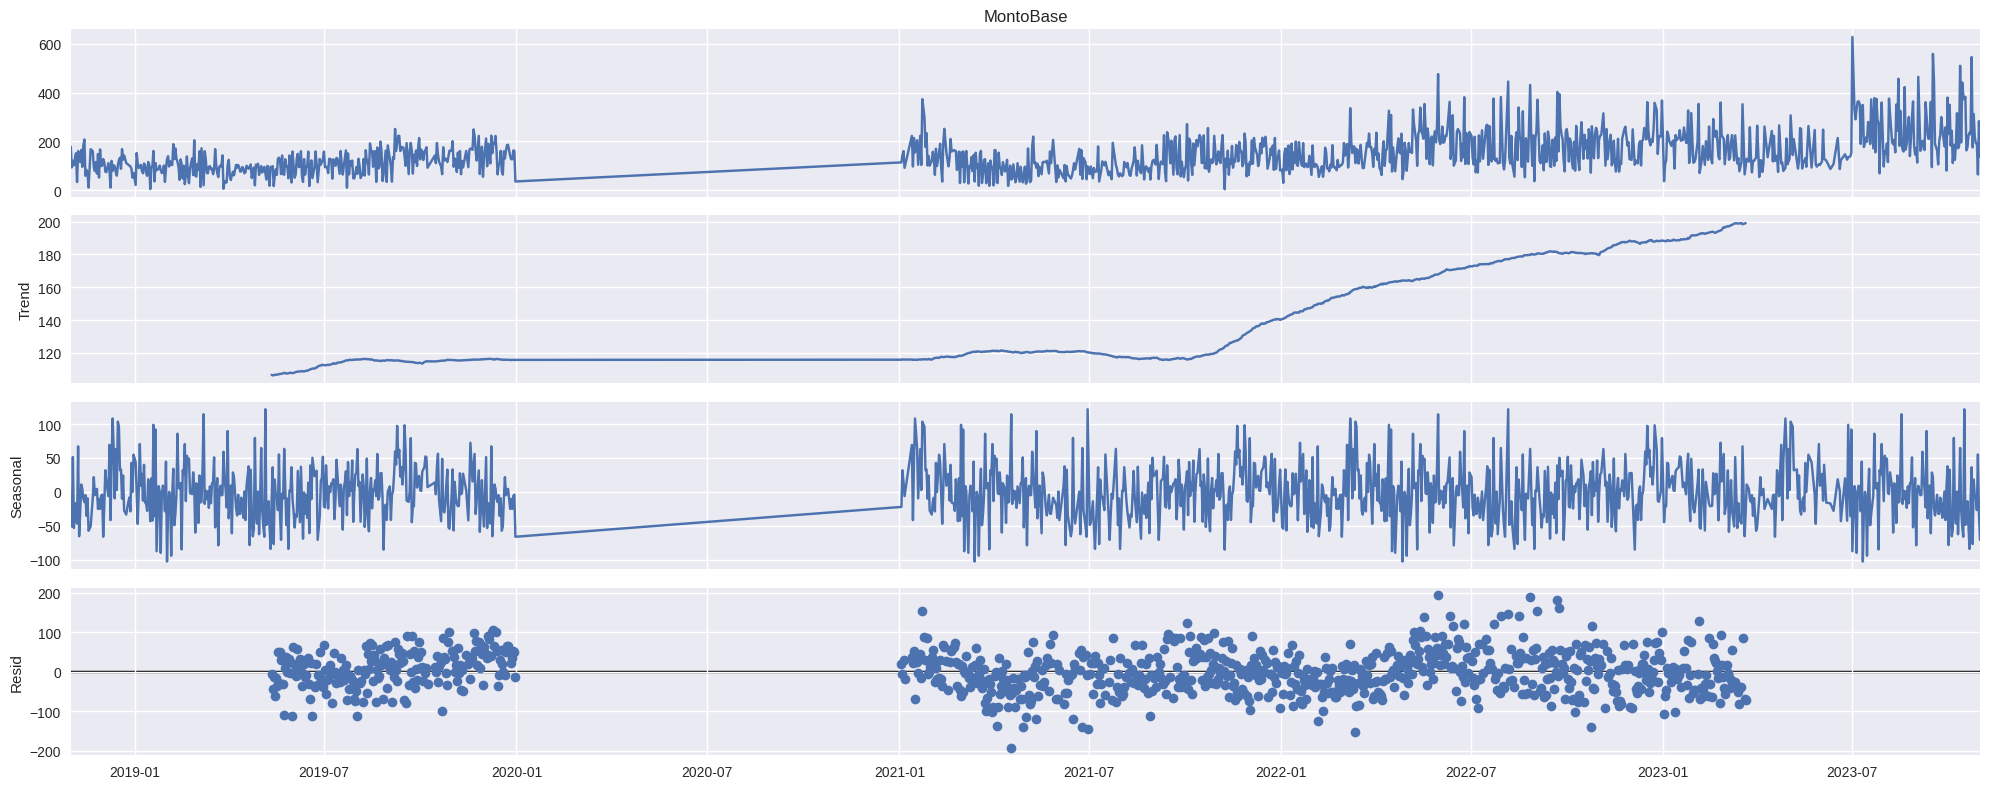

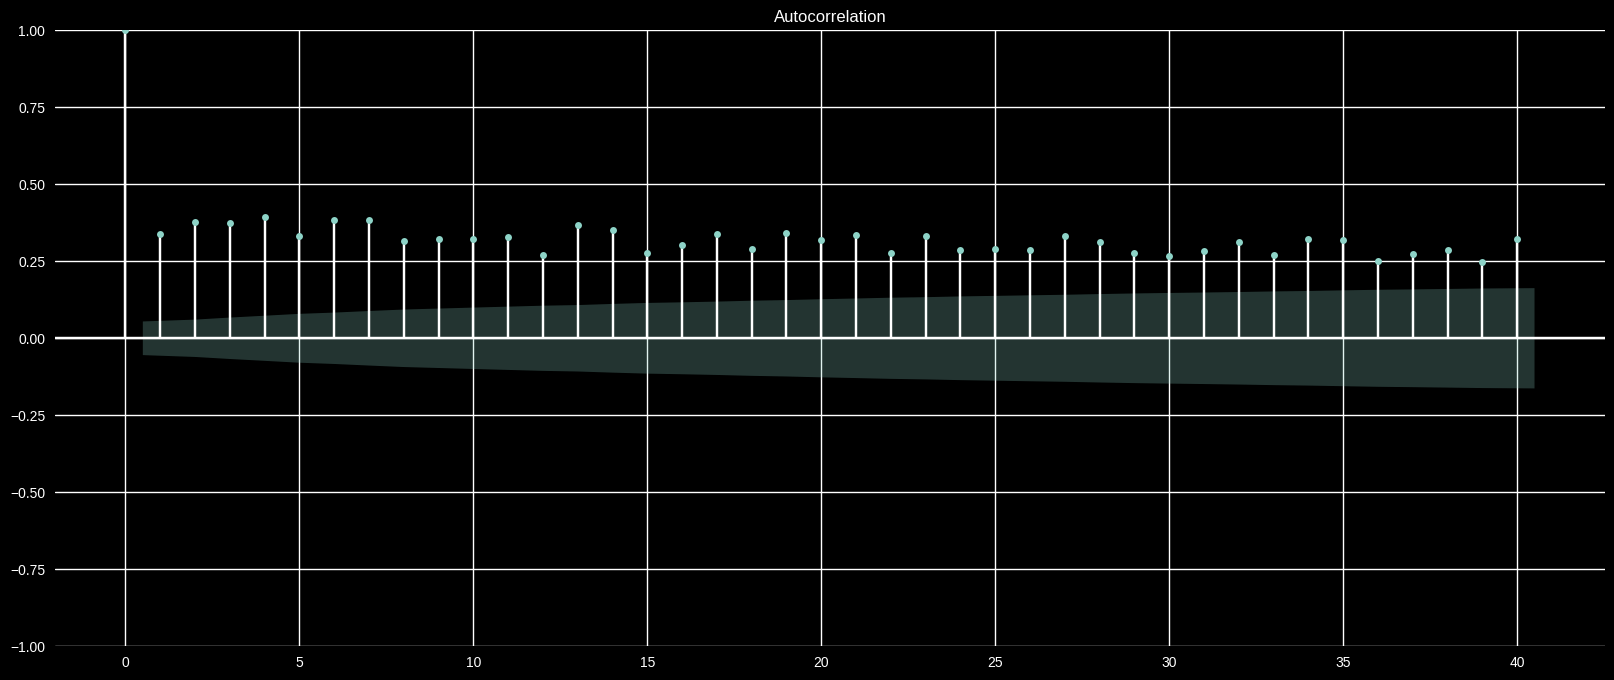

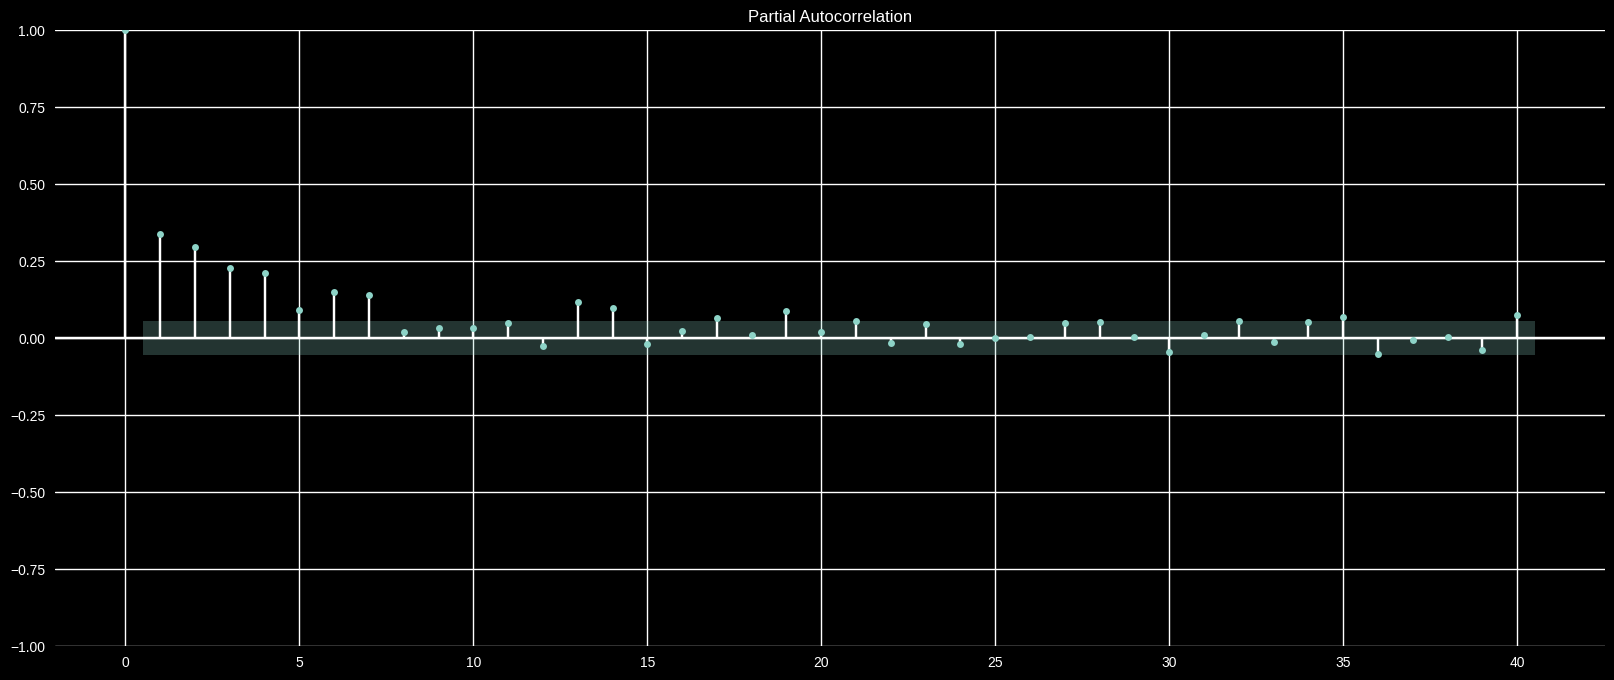

(1256, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=14042.005, Time=8.93 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=14873.007, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=14471.849, Time=1.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=14039.476, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=14871.011, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=14053.598, Time=0.43 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=14039.181, Time=3.20 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=14040.838, Time=2.33 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=14041.160, Time=16.47 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=14041.165, Time=12.30 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=14039.632, Time=6.65 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=14040.536, Time=4.26 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=14042.644, Time=17.19 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=14853.929

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

el ultimo indice_valor de los datos reales es: 1256,
se supone que deeria acabar 30 despues, pero la funcion indica: 1285 

2023-10-01   211.6843
2023-10-02   248.0431
2023-10-03   256.8754
2023-10-04   261.9726
2023-10-05   240.7689
2023-10-06   238.2350
2023-10-07   238.1600
2023-10-08   245.1324
2023-10-09   251.2055
2023-10-10   235.5775
2023-10-11   265.7454
2023-10-12   211.6681
2023-10-13   236.9528
2023-10-14   243.9104
2023-10-15   246.5358
2023-10-16   248.0510
2023-10-17   241.7481
2023-10-18   240.9949
2023-10-19   240.9726
2023-10-20   243.0452
2023-10-21   244.8504
2023-10-22   240.2049
2023-10-23   249.1725
2023-10-24   233.0977
2023-10-25   240.6137
2023-10-26   242.6819
2023-10-27   243.4624
2023-10-28   243.9127
2023-10-29   242.0392
2023-10-30   241.8153
Freq: D, Name: ARIMA Predictions CUELLO, dtype: float64

Ventas reales y predicciones ARIMA para CUELLO:
    MontoBase  P-V_ARIMA_CUELLO
0    239.9268          242.4247
1    151.9472          242.9614
2    169.7584  

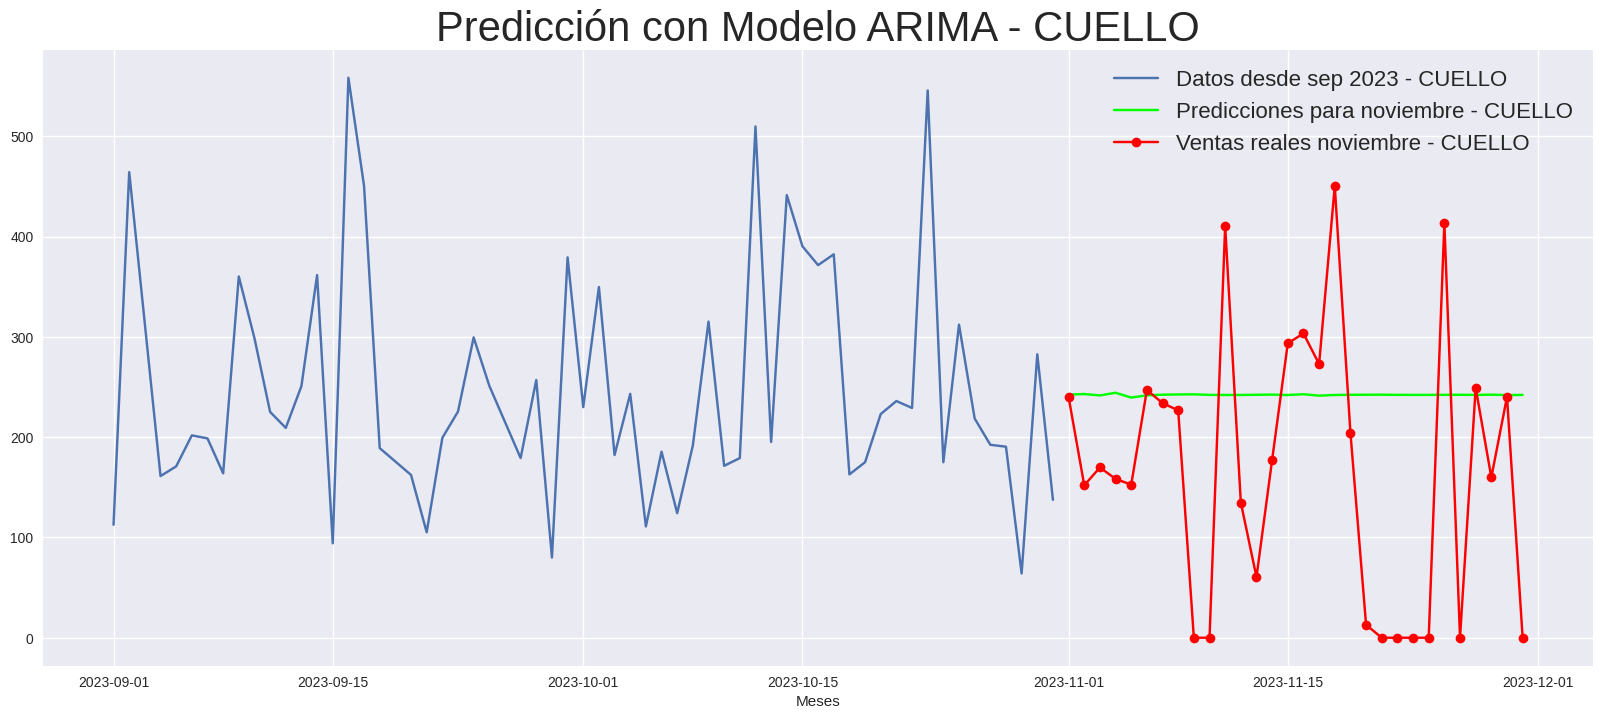

Predicciones para PIERNA MUSLO:


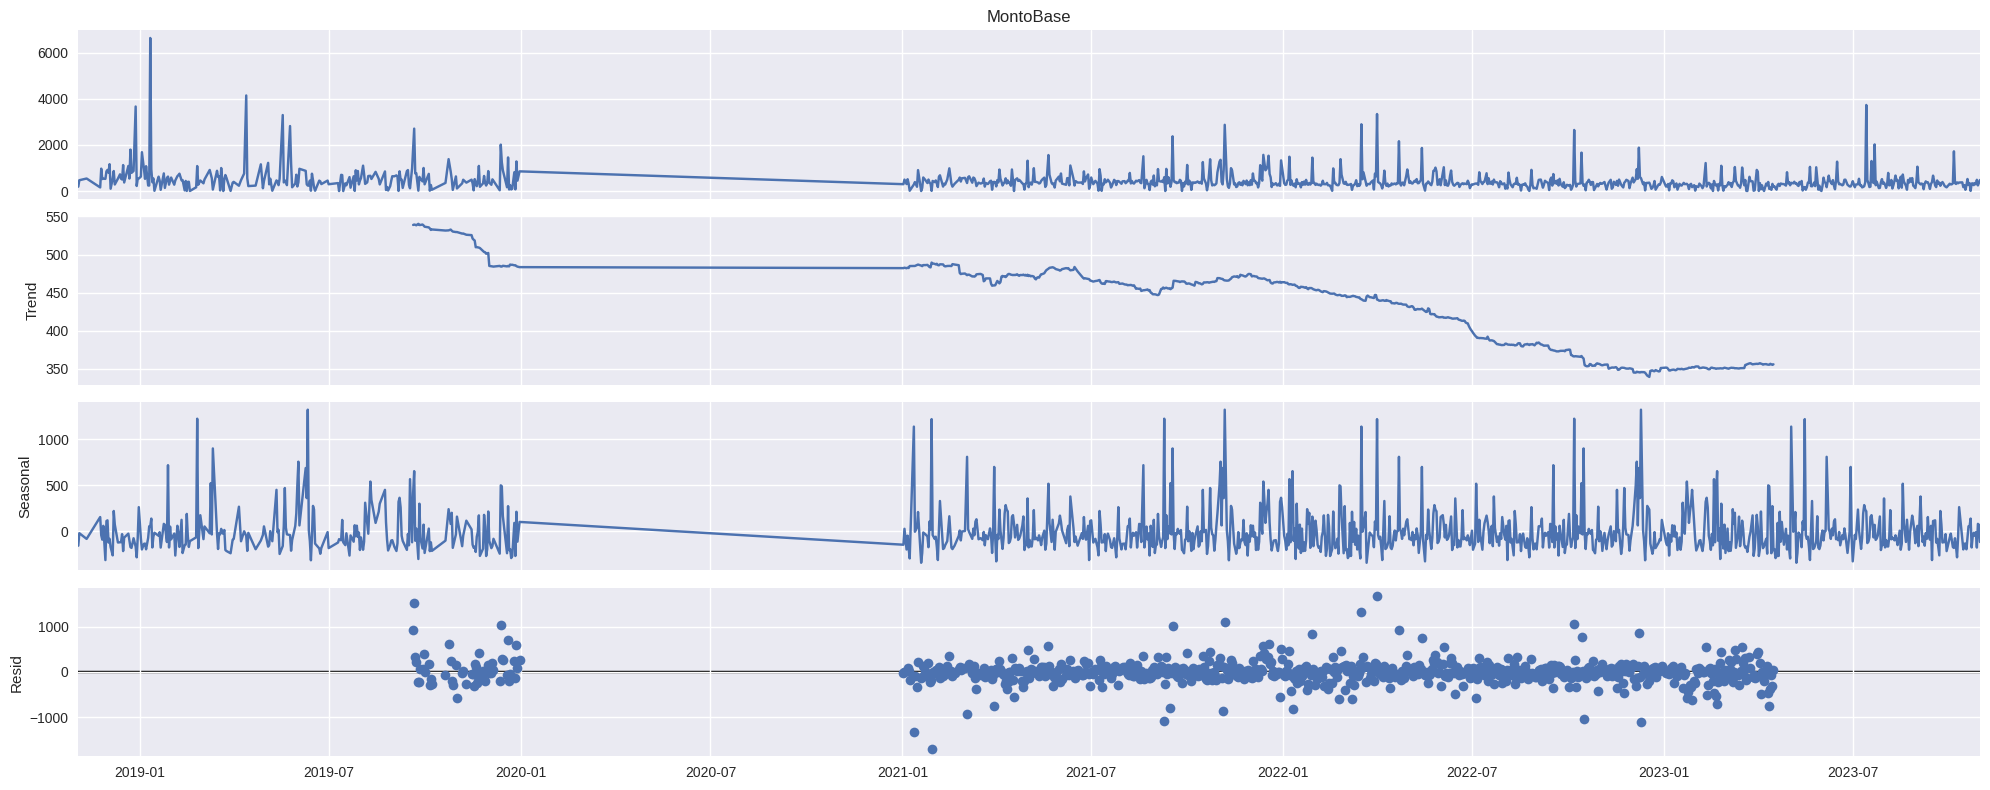

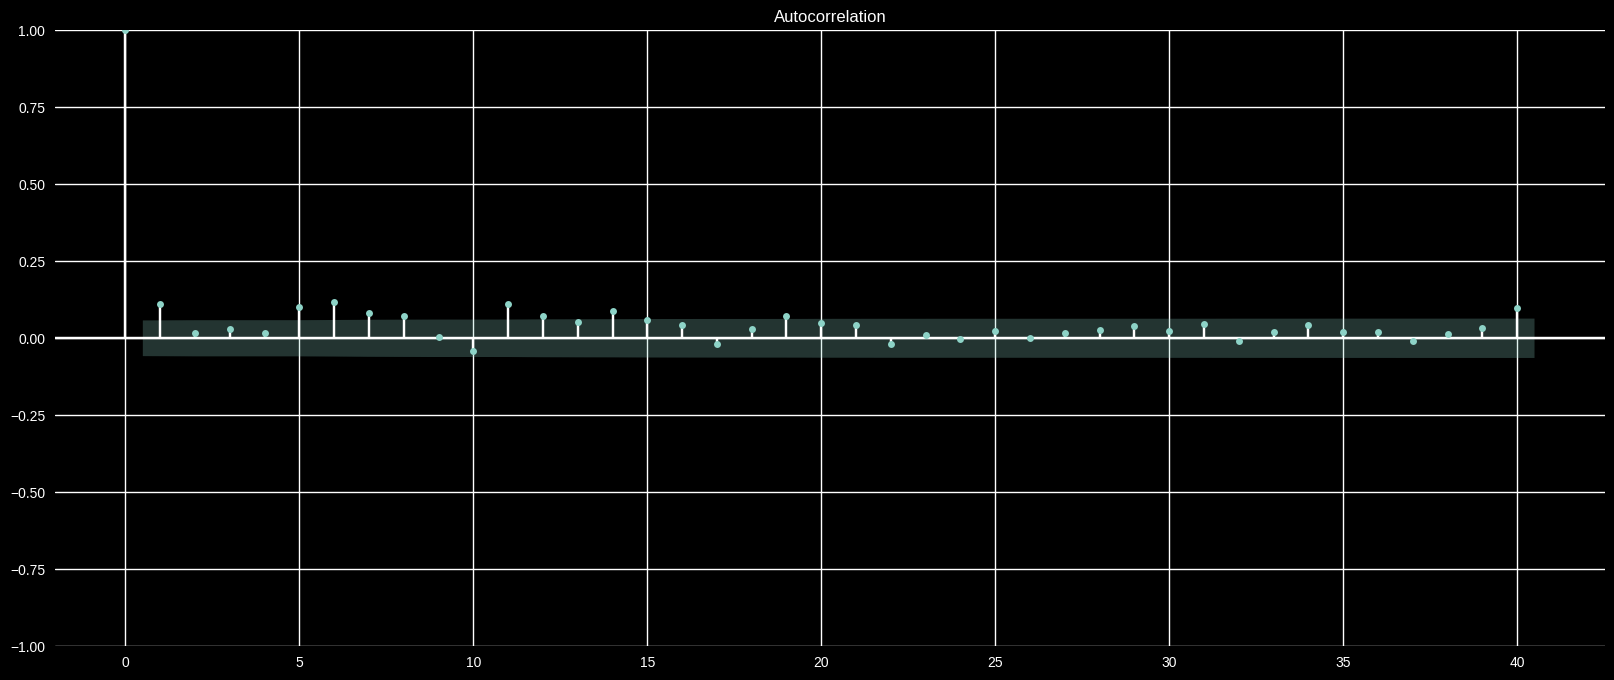

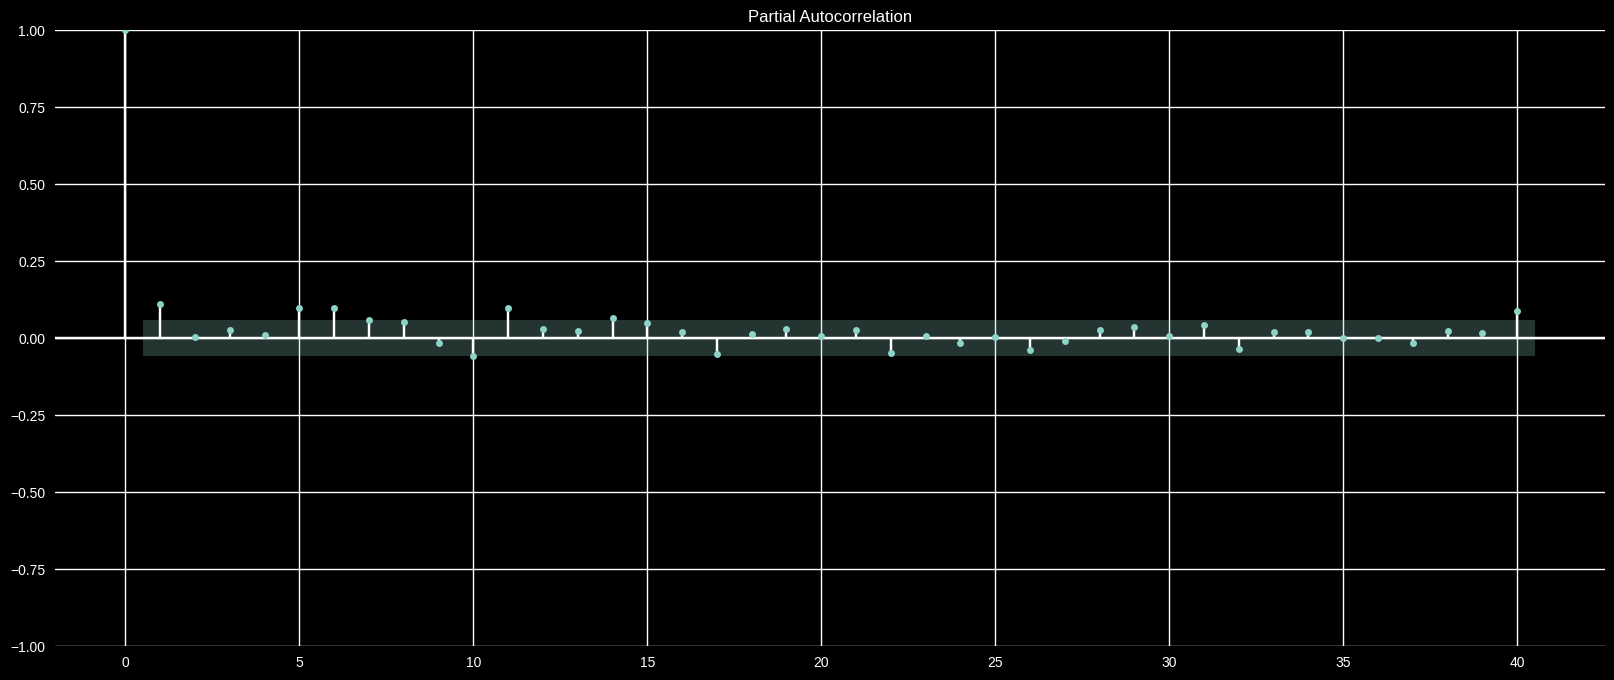

(1113, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=8.28 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=17347.663, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=17104.837, Time=0.51 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=2.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=17345.664, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=17103.514, Time=0.10 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=17104.832, Time=0.55 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=17106.784, Time=3.43 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=16981.528, Time=0.35 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=16982.796, Time=1.12 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=16982.762, Time=0.69 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=16983.810, Time=2.24 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=16921.343, Time=0.20 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=16922.983, Time=0.86 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

el ultimo indice_valor de los datos reales es: 1113,
se supone que deeria acabar 30 despues, pero la funcion indica: 1142 

2023-09-27   372.4293
2023-09-28   377.5651
2023-09-29   377.1083
2023-09-30   376.2731
2023-10-01   376.1641
2023-10-02   376.1922
2023-10-03   376.2088
2023-10-04   376.2104
2023-10-05   376.2095
2023-10-06   376.2092
2023-10-07   376.2092
2023-10-08   376.2092
2023-10-09   376.2092
2023-10-10   376.2092
2023-10-11   376.2092
2023-10-12   376.2092
2023-10-13   376.2092
2023-10-14   376.2092
2023-10-15   376.2092
2023-10-16   376.2092
2023-10-17   376.2092
2023-10-18   376.2092
2023-10-19   376.2092
2023-10-20   376.2092
2023-10-21   376.2092
2023-10-22   376.2092
2023-10-23   376.2092
2023-10-24   376.2092
2023-10-25   376.2092
2023-10-26   376.2092
Freq: D, Name: ARIMA Predictions PIERNA MUSLO, dtype: float64

Ventas reales y predicciones ARIMA para PIERNA MUSLO:
    MontoBase  P-V_ARIMA_PIERNA MUSLO
0    405.1496                376.2092
1    602.3700          

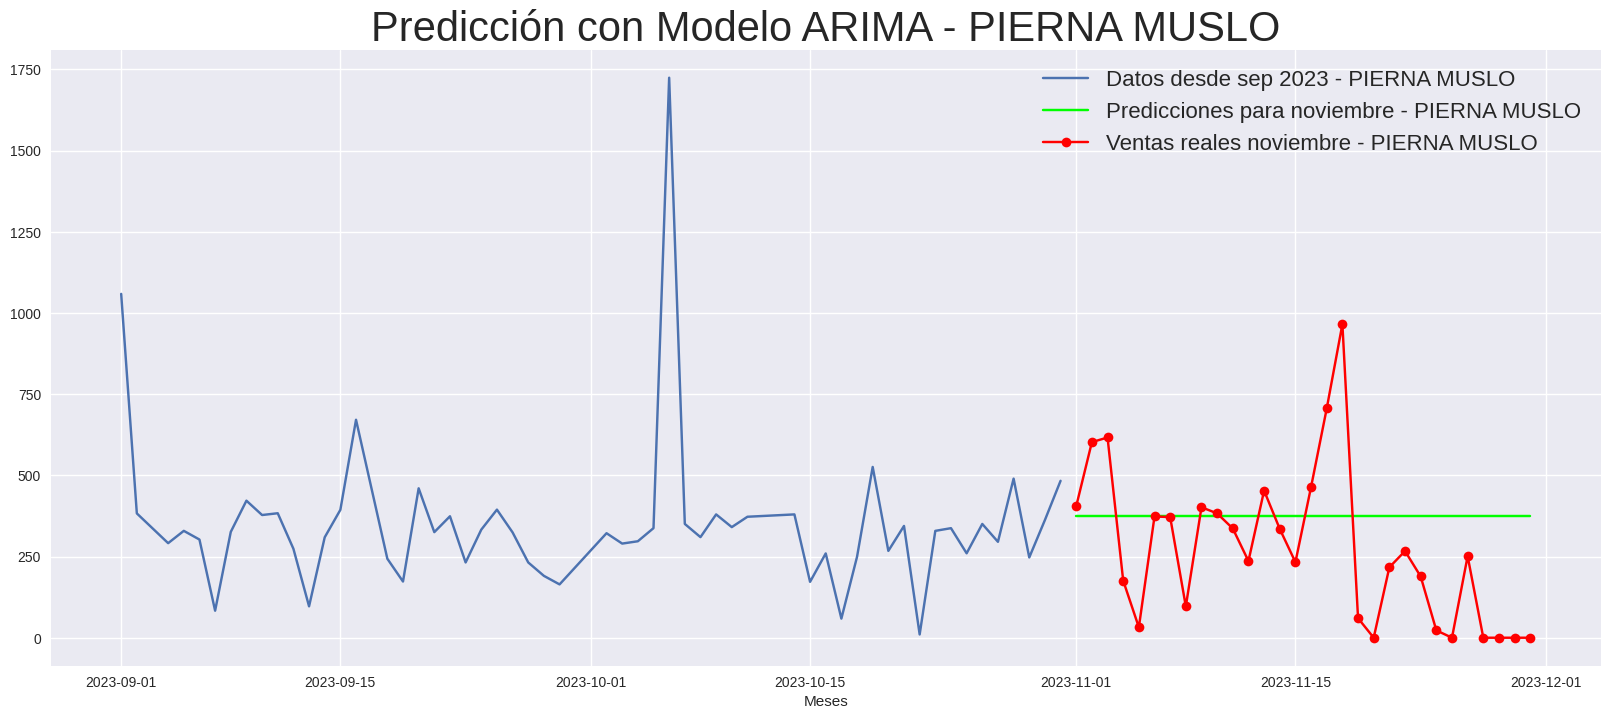

Predicciones para CORAZON:


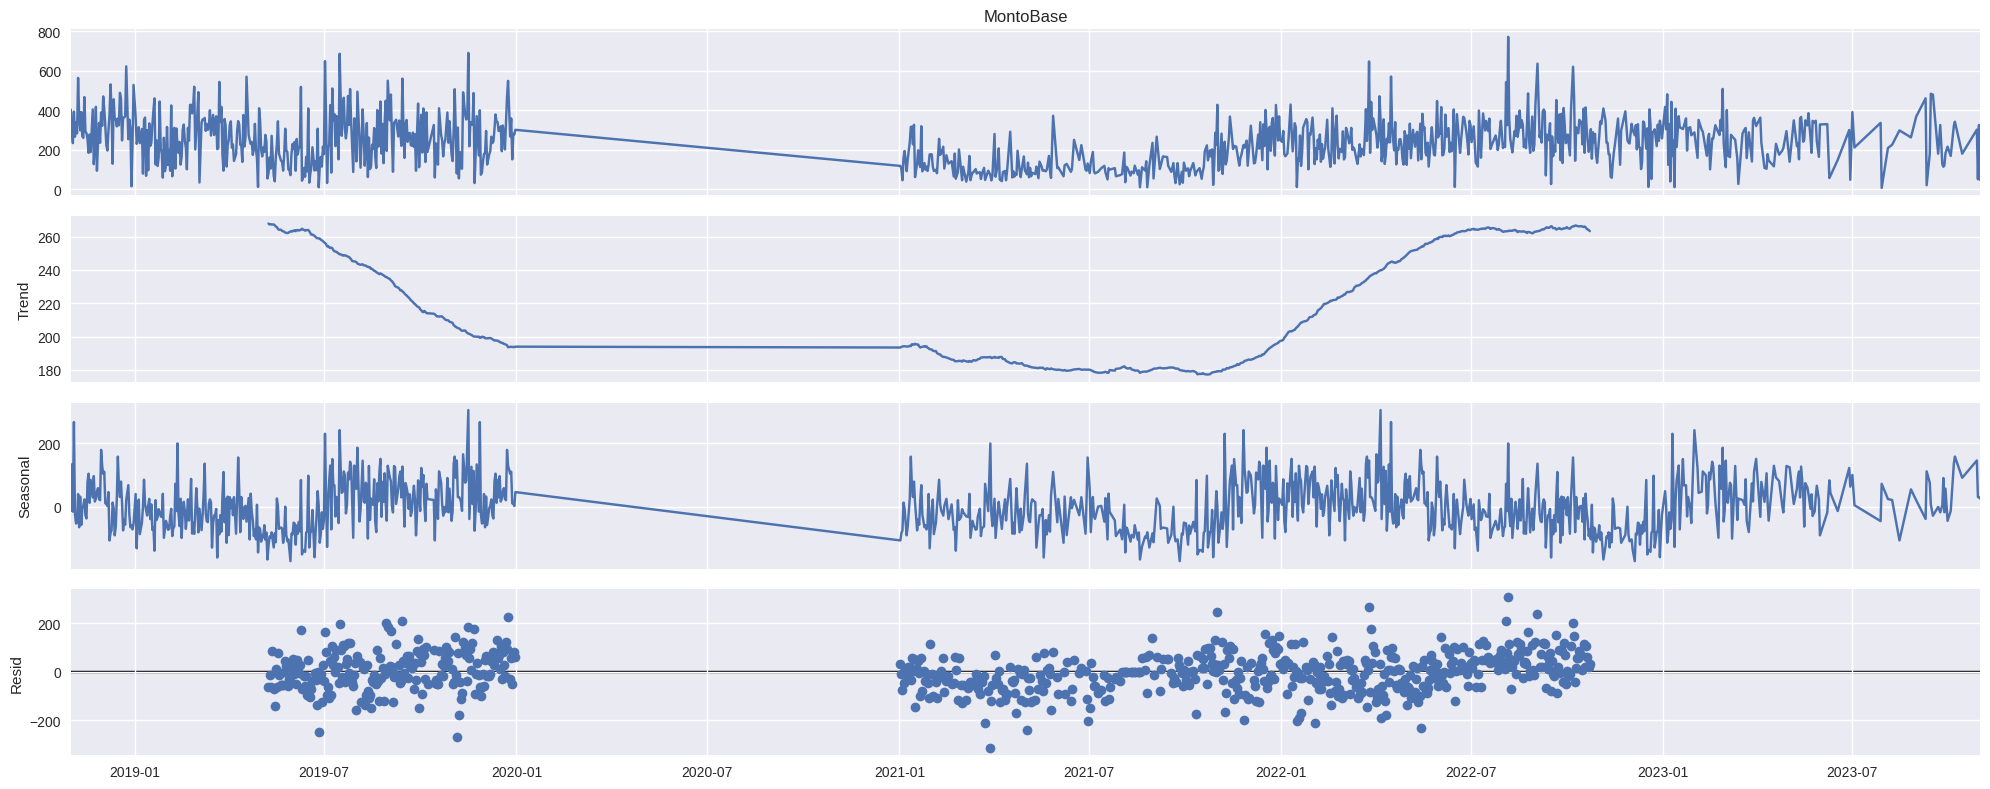

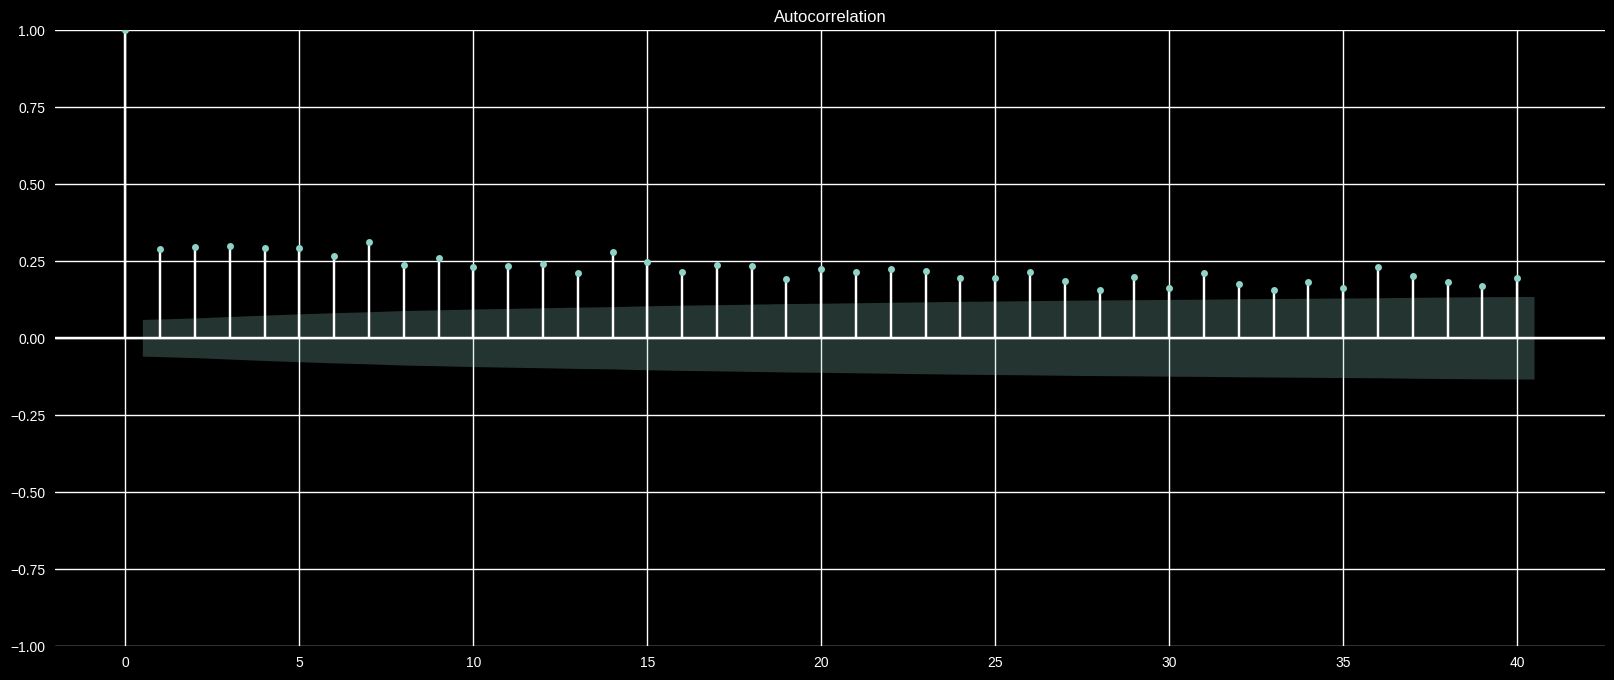

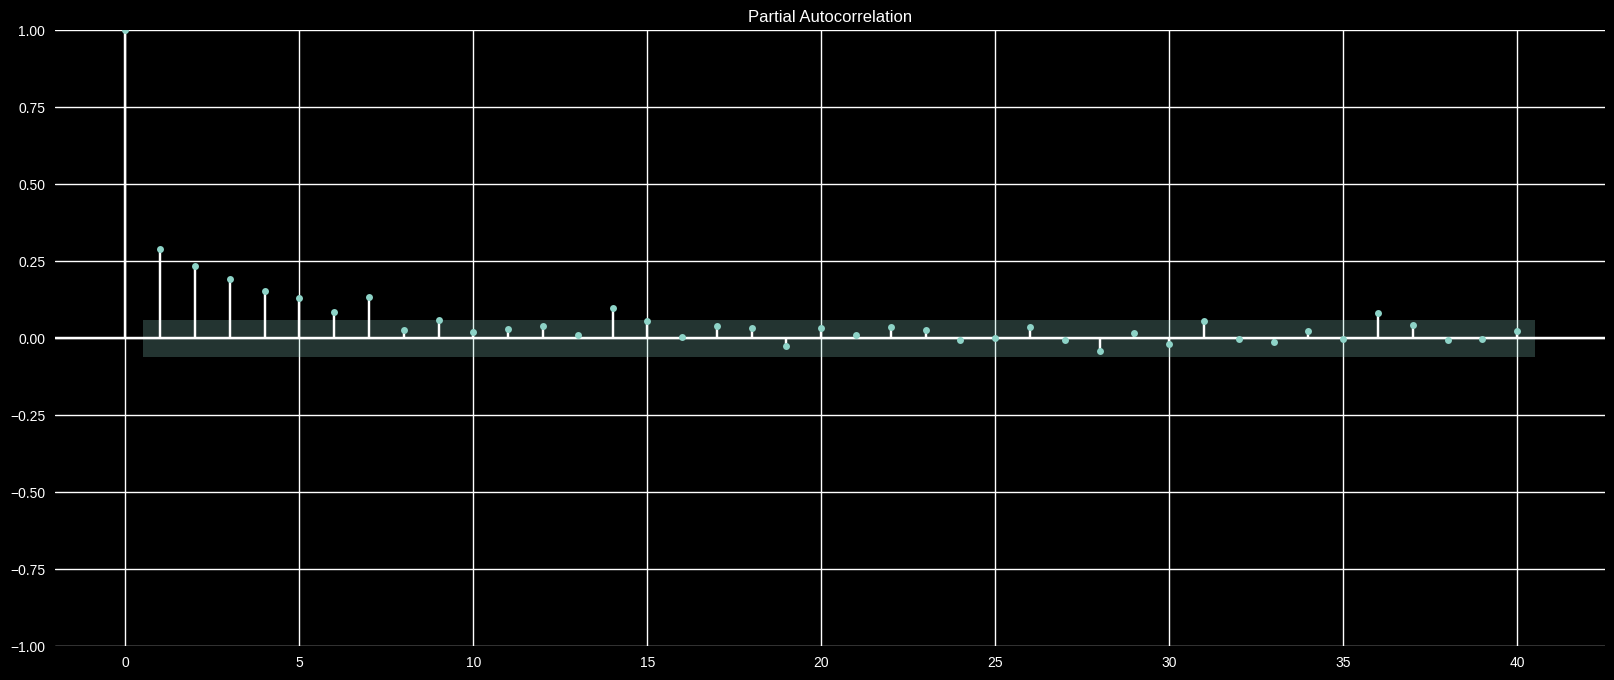

(1051, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=12764.250, Time=6.52 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=13379.383, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=13078.260, Time=0.52 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12757.533, Time=1.40 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=13377.386, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=12755.780, Time=0.47 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=12757.543, Time=2.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=12759.495, Time=4.16 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=12757.769, Time=0.65 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=12757.770, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=13076.340, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=12758.954, Time=1.02 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=12753.862, Time=0.14 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=12755.625, T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

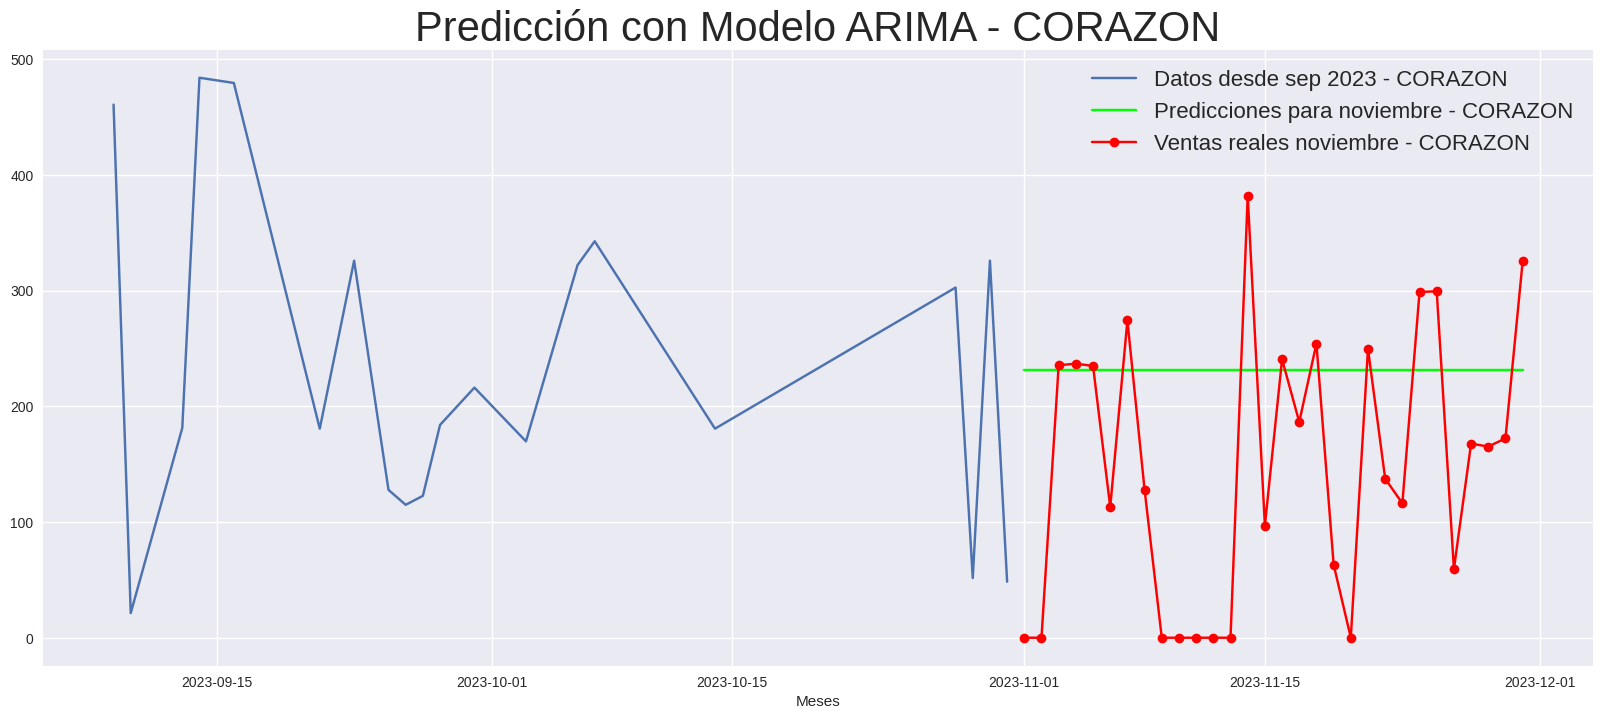

Predicciones para PECHUGA:


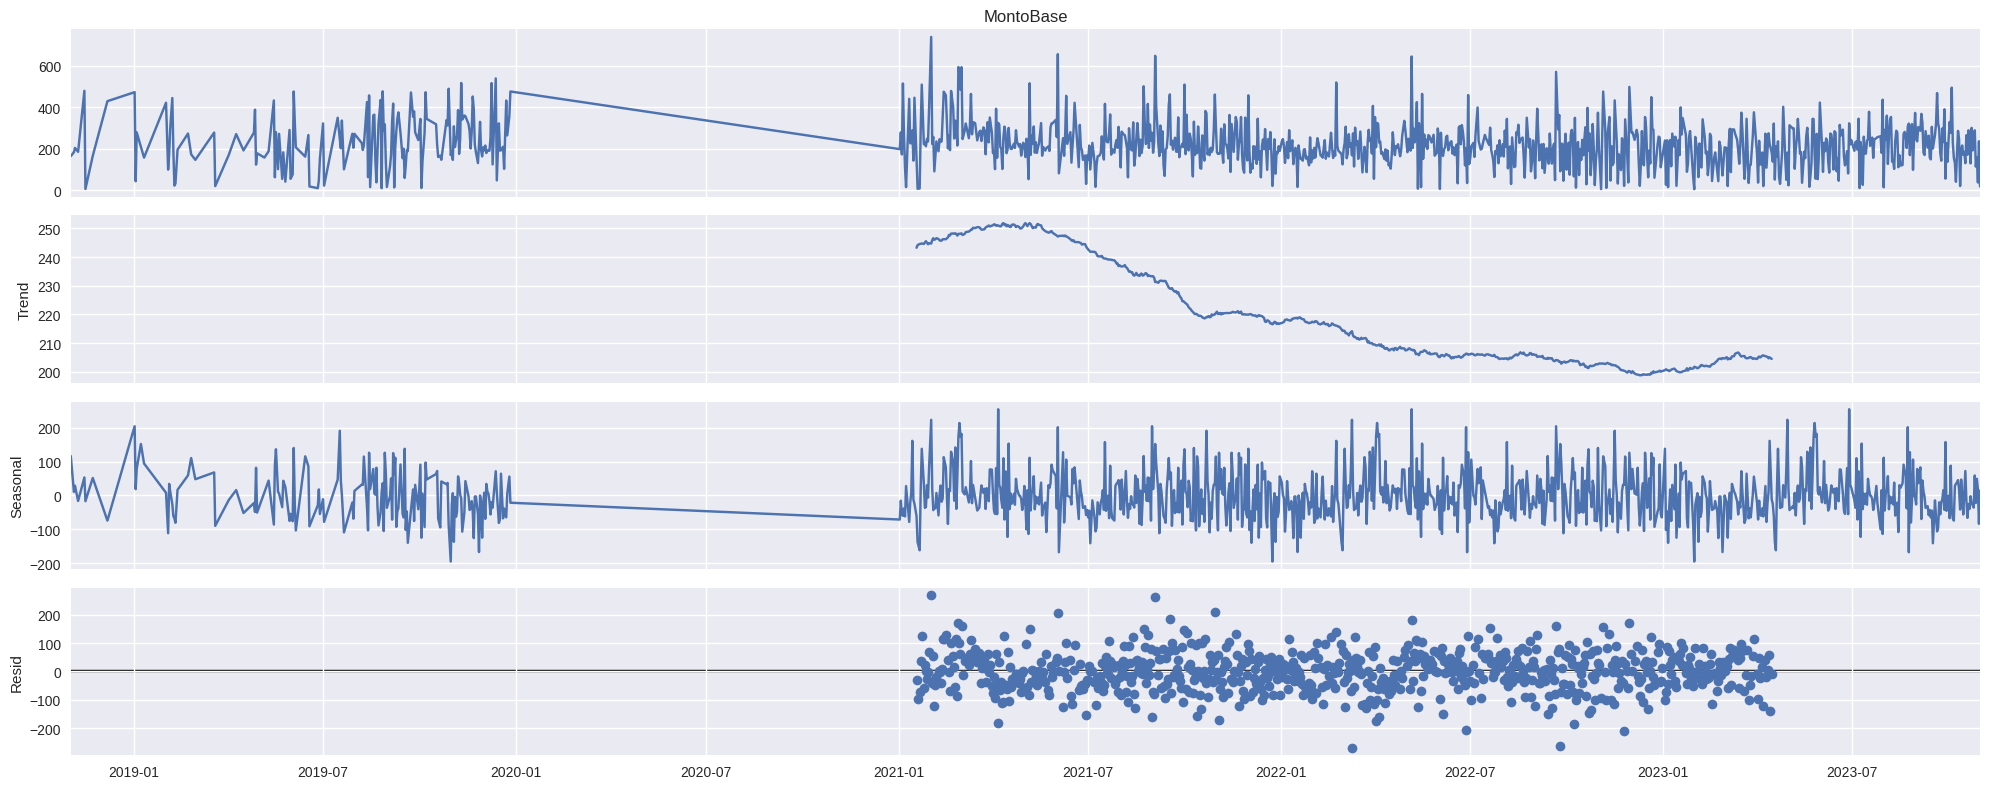

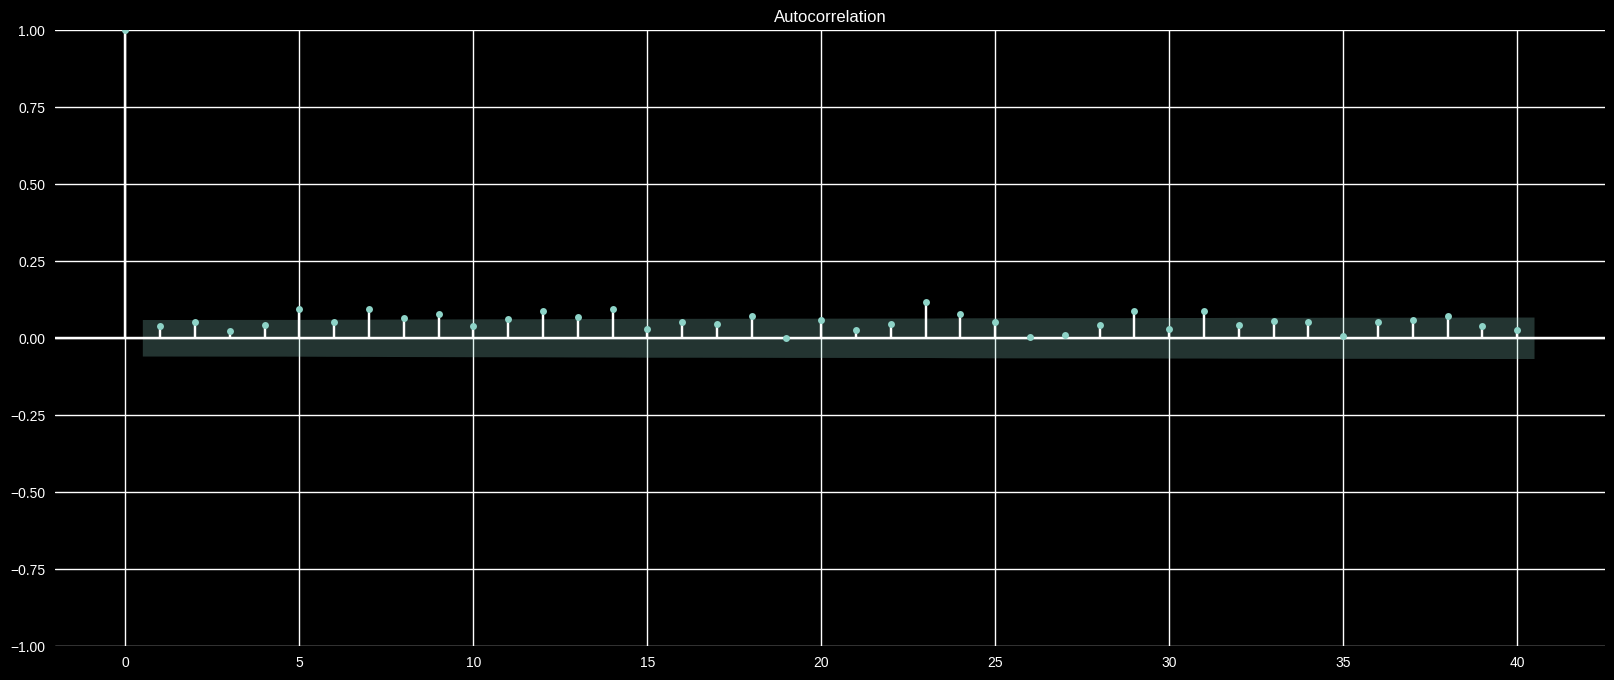

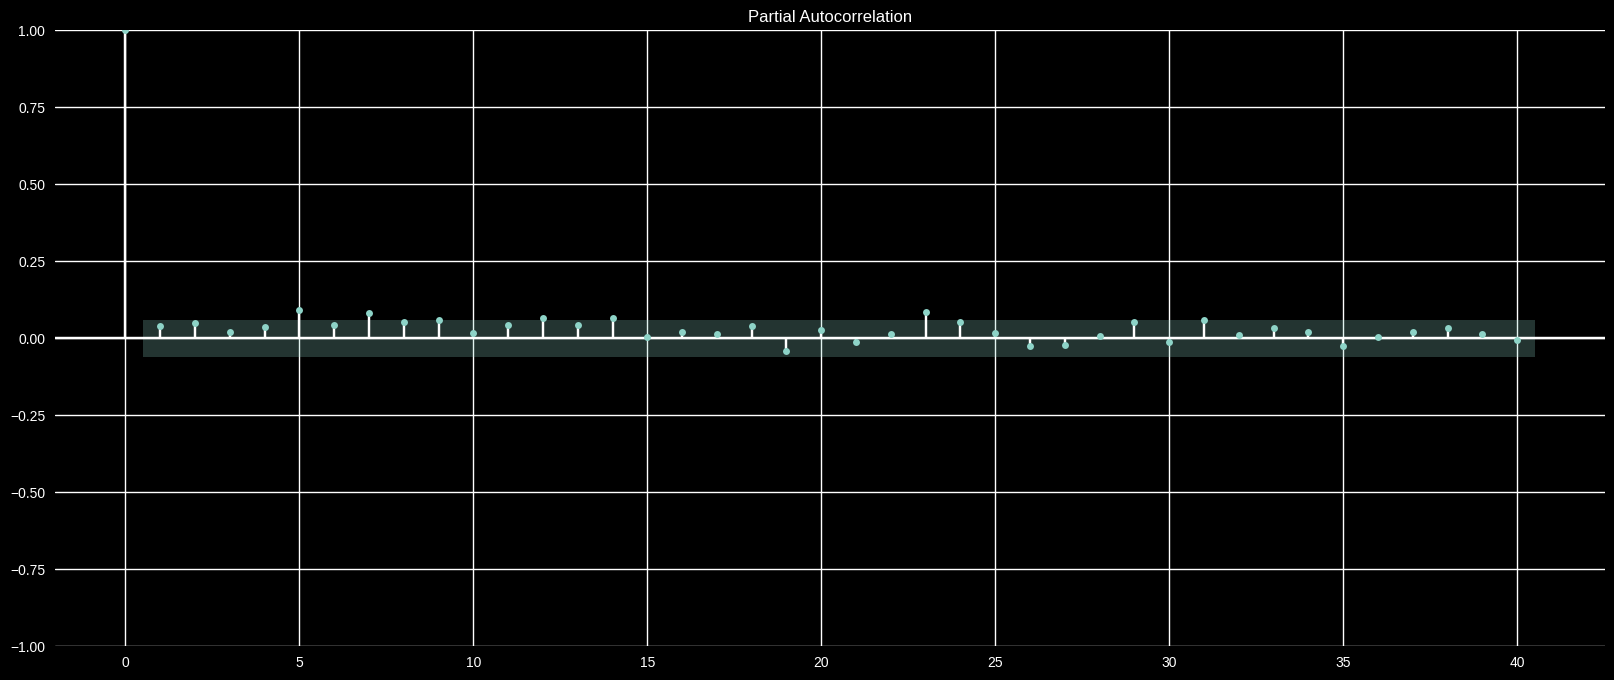

(1062, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=4.78 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=13609.589, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=13300.268, Time=0.42 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12884.082, Time=2.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=13607.590, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=12883.110, Time=0.66 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=12884.022, Time=2.30 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=5.29 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=12884.349, Time=0.89 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=12884.319, Time=0.77 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=13298.797, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=12887.104, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=12881.156, Time=0.19 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=12882.066, Time=0.92 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

el ultimo indice_valor de los datos reales es: 1062,
se supone que deeria acabar 30 despues, pero la funcion indica: 1091 

2023-10-01   237.9235
2023-10-02   237.9235
2023-10-03   237.9235
2023-10-04   237.9235
2023-10-05   237.9235
2023-10-06   237.9235
2023-10-07   237.9235
2023-10-08   237.9235
2023-10-09   237.9235
2023-10-10   237.9235
2023-10-11   237.9235
2023-10-12   237.9235
2023-10-13   237.9235
2023-10-14   237.9235
2023-10-15   237.9235
2023-10-16   237.9235
2023-10-17   237.9235
2023-10-18   237.9235
2023-10-19   237.9235
2023-10-20   237.9235
2023-10-21   237.9235
2023-10-22   237.9235
2023-10-23   237.9235
2023-10-24   237.9235
2023-10-25   237.9235
2023-10-26   237.9235
2023-10-27   237.9235
2023-10-28   237.9235
2023-10-29   237.9235
2023-10-30   237.9235
Freq: D, Name: ARIMA Predictions PECHUGA, dtype: float64

Ventas reales y predicciones ARIMA para PECHUGA:
    MontoBase  P-V_ARIMA_PECHUGA
0    376.1880           237.9235
1    364.9456           237.9235
2    230.9

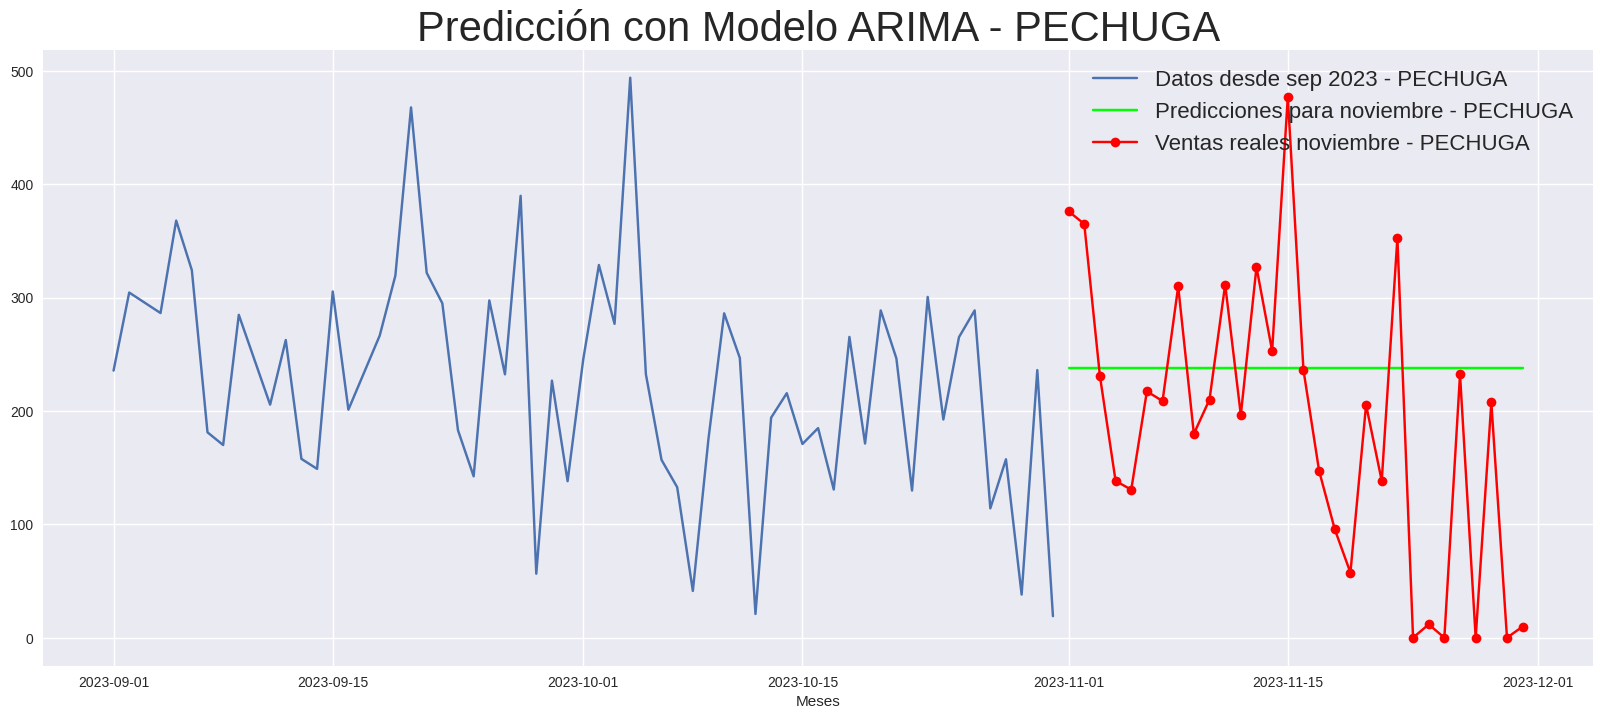

No hay suficientes datos para hacer una predicción con ARIMA para POLLO CON MENUDENCIA H-C.
Predicciones para RABADILLA:


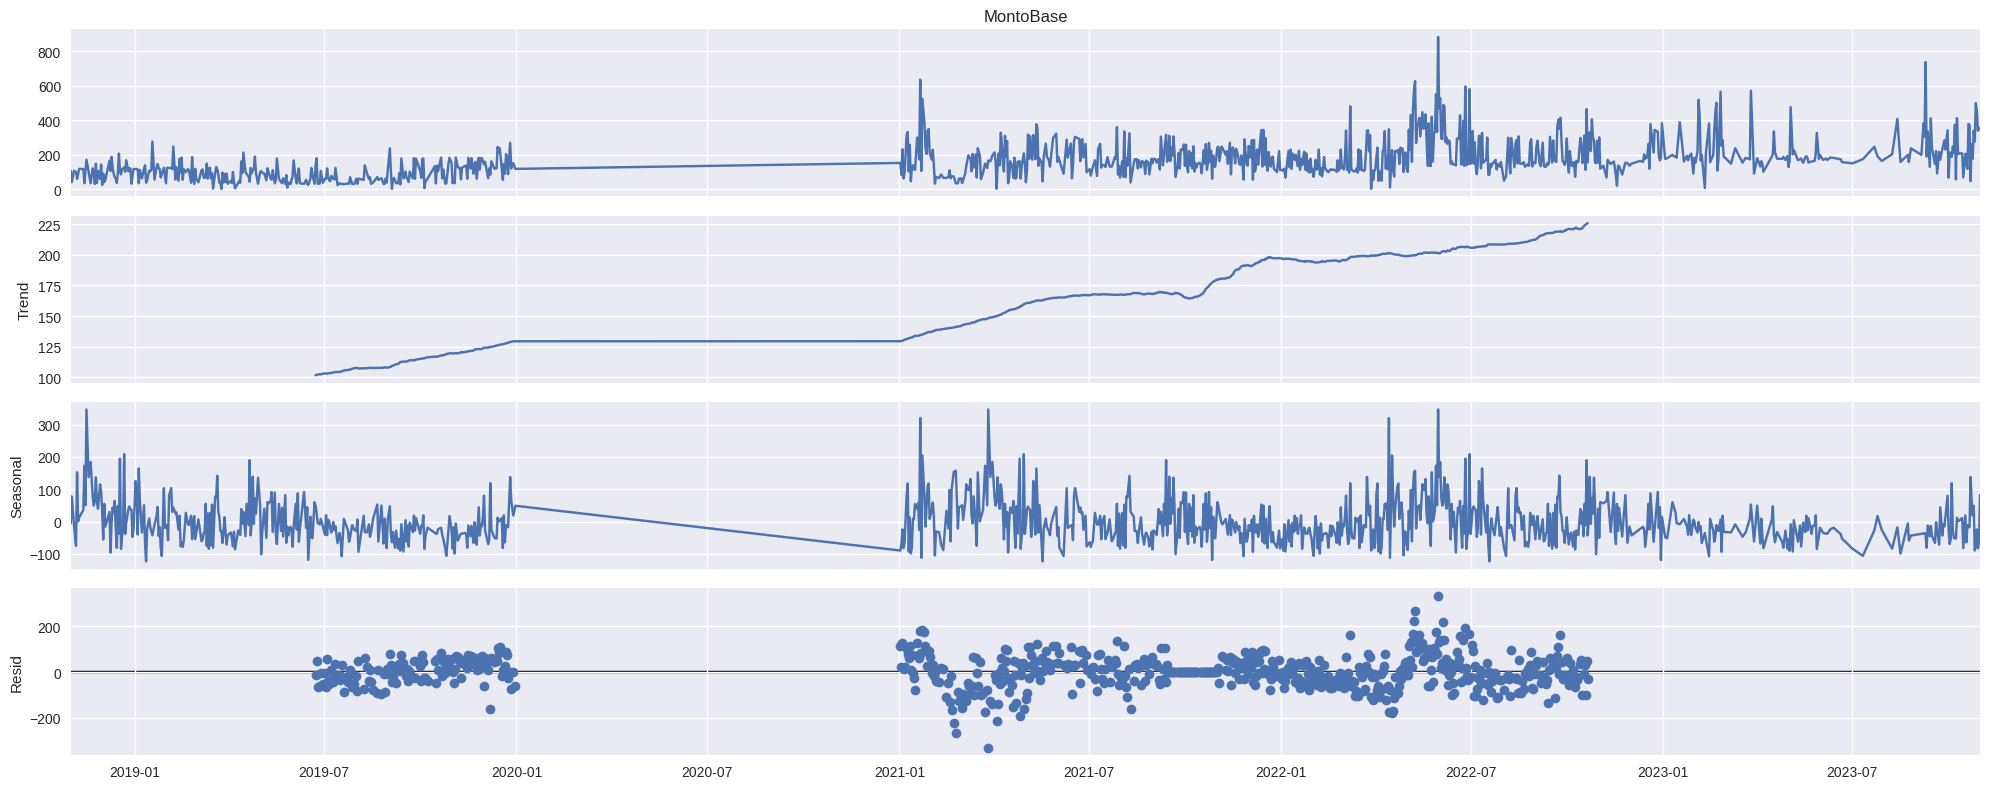

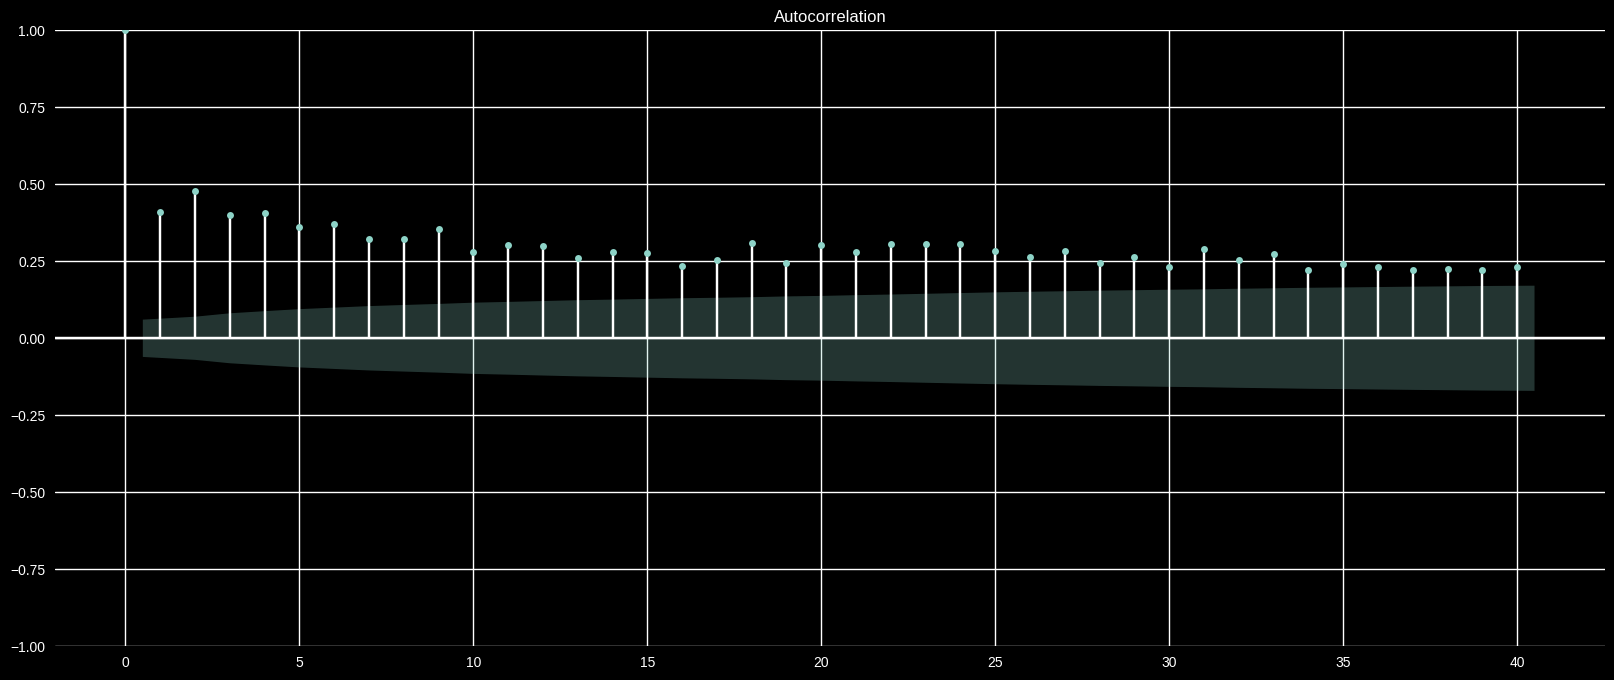

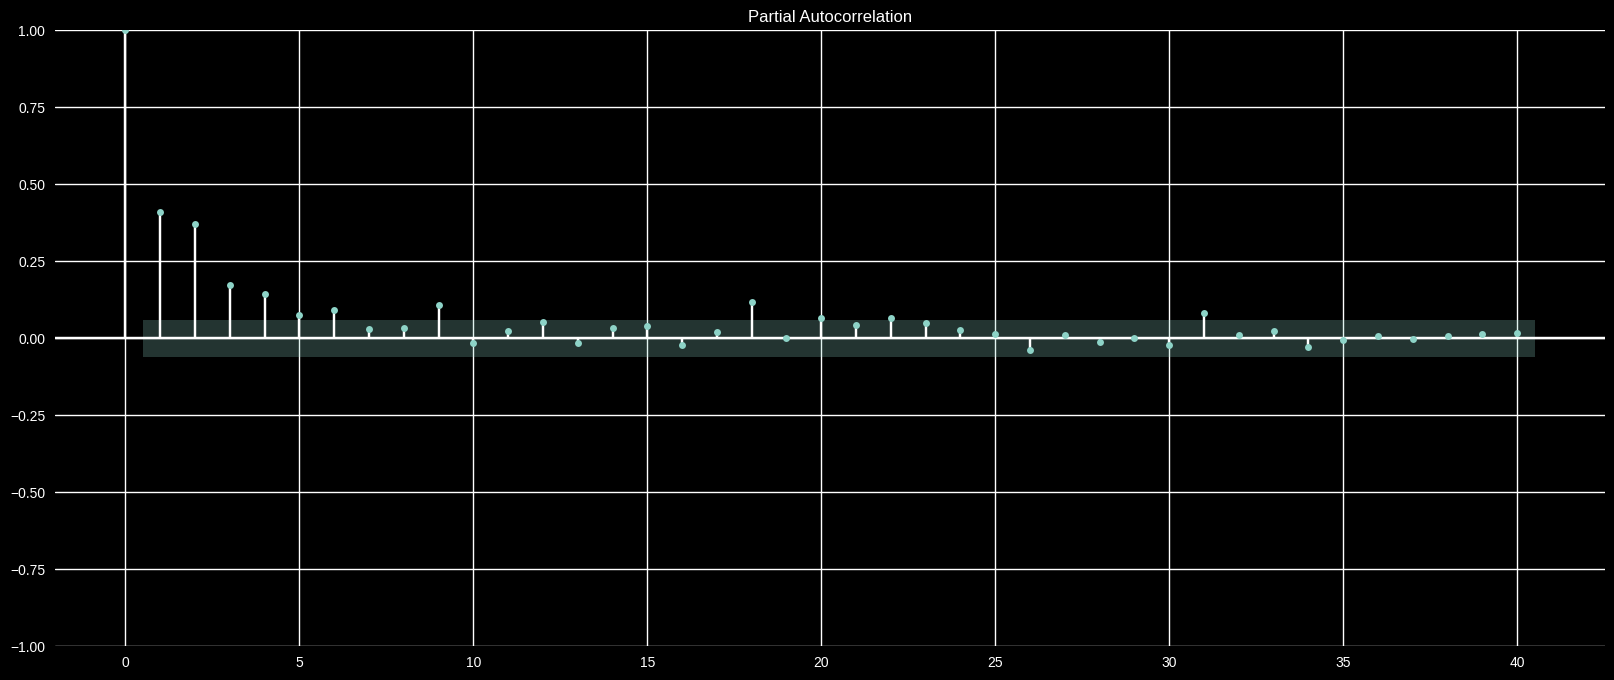

(1018, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=9.53 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=12508.538, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=12136.352, Time=0.55 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=11951.253, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=12506.541, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=11949.268, Time=0.61 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=11951.251, Time=2.31 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=3.96 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=11950.417, Time=1.17 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=11950.671, Time=1.29 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=12137.382, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=11946.149, Time=1.12 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=11948.126, Time=3.03 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=11948.128, Time=3.73 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

el ultimo indice_valor de los datos reales es: 1018,
se supone que deeria acabar 30 despues, pero la funcion indica: 1047 

2023-09-27   219.0248
2023-09-28   219.8427
2023-09-29   219.1722
2023-09-30   219.4654
2023-10-01   219.1611
2023-10-02   219.2503
2023-10-03   219.1013
2023-10-04   219.1144
2023-10-05   219.0338
2023-10-06   219.0211
2023-10-07   218.9725
2023-10-08   218.9533
2023-10-09   218.9212
2023-10-10   218.9023
2023-10-11   218.8795
2023-10-12   218.8633
2023-10-13   218.8464
2023-10-14   218.8330
2023-10-15   218.8202
2023-10-16   218.8095
2023-10-17   218.7996
2023-10-18   218.7911
2023-10-19   218.7834
2023-10-20   218.7767
2023-10-21   218.7708
2023-10-22   218.7655
2023-10-23   218.7608
2023-10-24   218.7567
2023-10-25   218.7530
2023-10-26   218.7498
Freq: D, Name: ARIMA Predictions RABADILLA, dtype: float64

Ventas reales y predicciones ARIMA para RABADILLA:
    MontoBase  P-V_ARIMA_RABADILLA
0    443.3756             218.7444
1    468.2156             218.7421


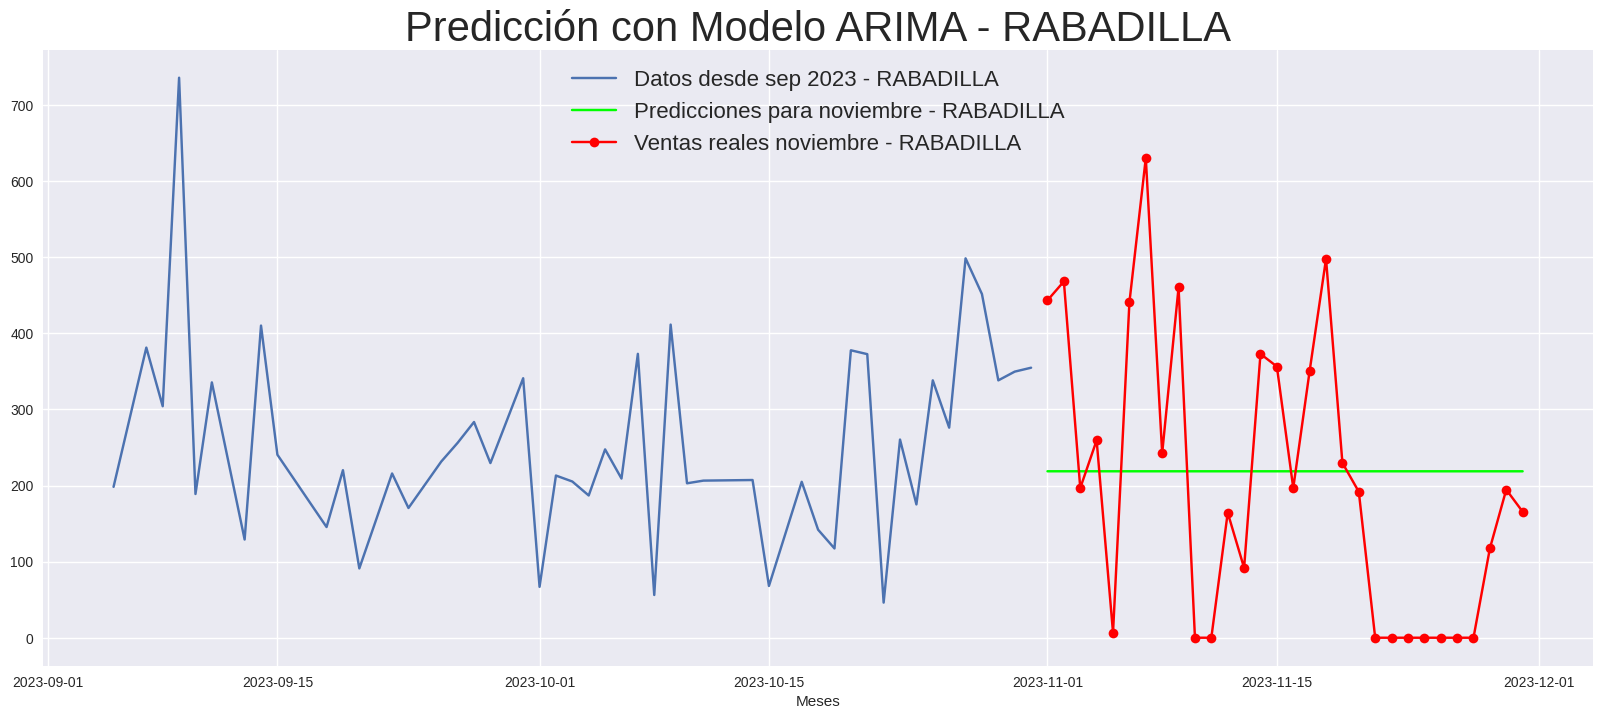

No hay suficientes datos para hacer una predicción con ARIMA para TROZADO 1/4 OFERTA.
No hay suficientes datos para hacer una predicción con ARIMA para PIERNA MUSLO OFERTA.
No hay suficientes datos para hacer una predicción con ARIMA para PARRI-POLLO.


In [ ]:
# Configurar tamaño de las figuras
plt.rcParams["figure.figsize"] = (12, 8)

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_arima
arima_models = {}  # Diccionario para almacenar los modelos ARIMA de cada producto

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_arima
for product, product_df_arima in dfs_de_productos_sumados_arima.items():
    if len(product_df_arima) >= 365:
        # Aquí puedes poner el código para realizar la predicción con ARIMA
        print(f"Predicciones para {product}:")
        # Realizar descomposición estacional
        decomposition = seasonal_decompose(product_df_arima["MontoBase"], model="add", period=365)
        decomposition.plot();
        plt.show()

        # Visualizar ACF y PACF
        plt.style.use('dark_background')
        plot_acf(product_df_arima['MontoBase'], lags=40)
        plt.show()

        plot_pacf(product_df_arima['MontoBase'], lags=40)
        plt.show()

        # Dividir en orden cronológico, entrenando sin el mes de octubre
        train_size_arima = int(len(product_df_arima) - 31)
        train_arima, test_arima = product_df_arima[0:train_size_arima], product_df_arima[train_size_arima:]

        print(train_arima.shape, test_arima.shape)

        # Identificar el modelo ARIMA automáticamente
        modelo_auto = auto_arima(train_arima['MontoBase'], seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, random_state=20, n_fits=50)
        print(modelo_auto.summary())

        # Configurar el modelo ARIMA
        arima_model = SARIMAX(train_arima["MontoBase"], order=modelo_auto.order, seasonal_order=modelo_auto.seasonal_order)
        arima_result = arima_model.fit()
        arima_models[product] = arima_result  # Guardar el modelo en el diccionario

        # Hacer predicciones con ARIMA
        arima_pred = arima_result.predict(start=len(train_arima), end=len(train_arima) + 29, typ="levels").rename(f"ARIMA Predictions {product}")
        # Crear un índice para las predicciones de noviembre
        november_index = pd.date_range(start=train_arima.index[-1] + pd.DateOffset(1), periods=30)
        arima_pred.index = november_index

        print(f'el ultimo indice_valor de los datos reales es: {len(train_arima)},')
        print(f'se supone que deeria acabar 30 despues, pero la funcion indica: {len(train_arima) + 29} \n')

        # Imprimir las predicciones para el mes de noviembre
        print(arima_pred)

        # Agregar las predicciones al DataFrame original
        if product in arima_models:
            # Hacer predicciones con ARIMA para el DataFrame actual
            arima_pred_full = arima_models[product].predict(start=len(product_df_arima), end=len(product_df_arima) + 29, typ="levels").rename(f"P-V_ARIMA_{product}")

            # Asegurarse de que las predicciones se alineen correctamente con las fechas de noviembre
            arima_pred_full.index = dfs_noviembre_sumados[product].index

            # Agregar la columna de predicciones ARIMA al DataFrame actual
            dfs_noviembre_sumados[product][f"P-V_ARIMA_{product}"] = arima_pred_full

            # Imprimir el resultado
            print(f'\nVentas reales y predicciones ARIMA para {product}:')
            print(dfs_noviembre_sumados[product][['MontoBase', f'P-V_ARIMA_{product}']].head(20))
        else:
            print(f"No hay modelo ARIMA para {product}.")

        # Visualizar las predicciones y los datos reales
        plt.style.use('seaborn')
        plt.rcParams["figure.figsize"] = (20, 8)
        # Datos de venta desde el 1ro de septiembre de 2023
        start_date = '2023-09-01'
        end_date = '2023-11-30'
        plt.plot(product_df_arima.index[product_df_arima.index >= start_date], product_df_arima['MontoBase'][product_df_arima.index >= start_date], label='Datos desde sep 2023 - ' + product)
        # Predicciones para el futuro (noviembre)
        dates_future = pd.date_range(start='2023-11-01', periods=len(arima_pred_full))
        plt.plot(dates_future[:len(arima_pred_full)], arima_pred_full, color="lime", label='Predicciones para noviembre - ' + product)
        real_november_data = dfs_noviembre_sumados[product]
        plt.plot(real_november_data['FechaMovimiento'], real_november_data['MontoBase'], 'o-', color='red', label='Ventas reales noviembre - ' + product)
        plt.title(f"Predicción con Modelo ARIMA - {product}", fontsize=30)
        plt.xlabel('Meses')
        plt.ylabel('')
        plt.legend(fontsize=16)
        plt.show()
    else:
        print(f"No hay suficientes datos para hacer una predicción con ARIMA para {product}.")

In [ ]:
# # Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_arima
# arima_models = {}  # Diccionario para almacenar los modelos ARIMA de cada producto

# # Seleccionar un solo producto para hacer pruebas
# product = 'POLLO SIN MENUDENCIA H-C'
# product_df_arima = dfs_de_productos_sumados_arima[product]

# if len(product_df_arima) >= 365:
#     # Realizar descomposición estacional
#     decomposition = seasonal_decompose(product_df_arima["MontoBase"], model="add", period=365)
#     decomposition.plot();
#     plt.show()

#     # Visualizar ACF y PACF
#     plt.style.use('dark_background')
#     plot_acf(product_df_arima['MontoBase'], lags=40)
#     plt.show()

#     plot_pacf(product_df_arima['MontoBase'], lags=40)
#     plt.show()

#     # Dividir en orden cronológico, entrenando sin el mes de octubre
#     train_size_arima = int(len(product_df_arima) - 31)
#     train_arima, test_arima = product_df_arima[0:train_size_arima], product_df_arima[train_size_arima:]

#     # Identificar el modelo ARIMA automáticamente
#     modelo_auto = auto_arima(train_arima['MontoBase'], seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, random_state=20, n_fits=50)
#     print(modelo_auto.summary())

#     # Configurar el modelo ARIMA
#     arima_model = SARIMAX(train_arima["MontoBase"], order=modelo_auto.order, seasonal_order=modelo_auto.seasonal_order)
#     arima_result = arima_model.fit()
#     arima_models[product] = arima_result  # Guardar el modelo en el diccionario

#     # Hacer predicciones con ARIMA
#     arima_pred = arima_result.predict(start=len(train_arima), end=len(train_arima) + 29, typ="levels").rename(f"ARIMA Predictions {product}")
#     # Crear un índice para las predicciones de noviembre
#     november_index = pd.date_range(start=train_arima.index[-1] + pd.DateOffset(1), periods=30)
#     arima_pred.index = november_index
#     # arima_pred.index = dfs_noviembre_sumados[product]['FechaMovimiento']

#     print(f'el ultimo indice_valor de los datos reales es: {len(train_arima)},')
#     print(f'se supone que deeria acabar 30 despues, pero la funcion indica: {len(train_arima) + 29} \n')

#     # Imprimir las predicciones para el mes de noviembre
#     print(arima_pred)

#     # Agregar las predicciones al DataFrame original
#     if product in arima_models:
#         # Hacer predicciones con ARIMA para el DataFrame actual
#         arima_pred_full = arima_models[product].predict(start=len(product_df_arima), end=len(product_df_arima) + 29, typ="levels").rename(f"P-V_ARIMA_{product}")

#         # Asegurarse de que las predicciones se alineen correctamente con las fechas de noviembre
#         arima_pred_full.index = dfs_noviembre_sumados[product].index

#         # Agregar la columna de predicciones ARIMA al DataFrame actual
#         dfs_noviembre_sumados[product][f"P-V_ARIMA_{product}"] = arima_pred_full

#         # Imprimir el resultado
#         print(f'\nVentas reales y predicciones ARIMA para {product}:')
#         print(dfs_noviembre_sumados[product][['MontoBase', f'P-V_ARIMA_{product}']].head(20))
#     else:
#         print(f"No hay modelo ARIMA para {product}.")

#     # Visualizar las predicciones y los datos reales
#     plt.style.use('seaborn')
#     plt.rcParams["figure.figsize"] = (20, 8)
#     # Datos de venta desde el 1ro de septiembre de 2023
#     start_date = '2023-09-01'
#     end_date = '2023-11-30'
#     plt.plot(product_df_arima.index[product_df_arima.index >= start_date], product_df_arima['MontoBase'][product_df_arima.index >= start_date], label='Datos desde sep 2023 - ' + product)
#     # Predicciones para el futuro (noviembre)
#     dates_future = pd.date_range(start='2023-11-01', periods=len(arima_pred_full))
#     plt.plot(dates_future[:len(arima_pred_full)], arima_pred_full, color="lime", label='Predicciones para noviembre - ' + product)
#     real_november_data = dfs_noviembre_sumados[product]
#     plt.plot(real_november_data['FechaMovimiento'], real_november_data['MontoBase'], 'o-', color='red', label='Ventas reales noviembre - ' + product)
#     plt.title(f"Predicción con Modelo ARIMA - {product}", fontsize=30)
#     plt.xlabel('Meses')
#     plt.ylabel('')
#     plt.legend(fontsize=16)
#     plt.show()
# else:
#     print(f"No hay suficientes datos para hacer una predicción con ARIMA para {product}.")

In [ ]:
#print(dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'])
print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])

              NombreProducto  MontoBase FechaMovimiento  \
0   POLLO SIN MENUDENCIA H-C  3239.2974      2023-11-01   
1   POLLO SIN MENUDENCIA H-C  7098.1327      2023-11-02   
2   POLLO SIN MENUDENCIA H-C  4978.8291      2023-11-03   
3   POLLO SIN MENUDENCIA H-C  4431.8618      2023-11-04   
4   POLLO SIN MENUDENCIA H-C  4541.8035      2023-11-05   
5   POLLO SIN MENUDENCIA H-C  7492.0734      2023-11-06   
6   POLLO SIN MENUDENCIA H-C  7305.7163      2023-11-07   
7   POLLO SIN MENUDENCIA H-C  4343.5560      2023-11-08   
8   POLLO SIN MENUDENCIA H-C  3487.1891      2023-11-09   
9   POLLO SIN MENUDENCIA H-C  1528.0410      2023-11-10   
10  POLLO SIN MENUDENCIA H-C  7330.7520      2023-11-11   
11  POLLO SIN MENUDENCIA H-C  4889.5888      2023-11-12   
12  POLLO SIN MENUDENCIA H-C  7760.8445      2023-11-13   
13  POLLO SIN MENUDENCIA H-C  1427.7825      2023-11-14   
14  POLLO SIN MENUDENCIA H-C  1659.6720      2023-11-15   
15  POLLO SIN MENUDENCIA H-C  4789.3392      2023-11-16 

In [ ]:
# ESTO ES PARA ELIMINAR LA COLUMA DE PREDICCION DE ARIMA QUE aparecia con 'nan'
# for product, product_df in dfs_noviembre_sumados.items():
#     product_df.drop(columns=[f'P-V_ARIMA_{product}'], inplace=True)
#     print(product_df)


## Evaluar ARIMA

In [ ]:
for product, product_df in dfs_noviembre_sumados.items():
    # print(product_df.head(30))

    # Verificar si la columna 'P-V_ARIMA_{product}' existe
    if f'P-V_ARIMA_{product}' in dfs_noviembre_sumados[product].columns:
        print(f'evaluacion del producto: {product}')
        # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
        evaluacion_metrica(
            dfs_noviembre_sumados[product]['MontoBase'],
            dfs_noviembre_sumados[product][f'P-V_ARIMA_{product}']
        )
        print('\n')
    else:
        print(f"No hay predicciones para {product}.")

evaluacion del producto: POLLO SIN MENUDENCIA H-C
Evaluation metric results:-
MSE is : 7759576.507940633
MAE is : 2177.8331042119735
R2 is : -1.0057952310351408 %
------------------------------
RMSE is : 2785.6016420049427
MAPE is : 74.82317182548957 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------





evaluacion del producto: CUELLO
Evaluation metric results:-
MSE is : 23877.17744719757
MAE is : 123.66251499988317
R2 is : -0.32811109730641963 %
------------------------------
RMSE is : 154.522417296642
MAPE is : 121.96781418432123 %
------------------------------
------------------------------
Días reales calculados: 22
Días omitidos: 8
Total de días: 30
------------------------------





evaluacion del producto: PIERNA MUSLO
Evaluation metric results:-
MSE is : 67428.71570636921
MAE is : 210.54895793611954
R2 is : -0.18708128958416426 %
------------------------------
RMSE is :

Cómo interpretar las gráficas de residuos en el modelo ARIMA


# PREDICCIONES
### Graficos y valores calculados de (todos) los productos


<ipython-input-57-9a1b3ca24c93>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


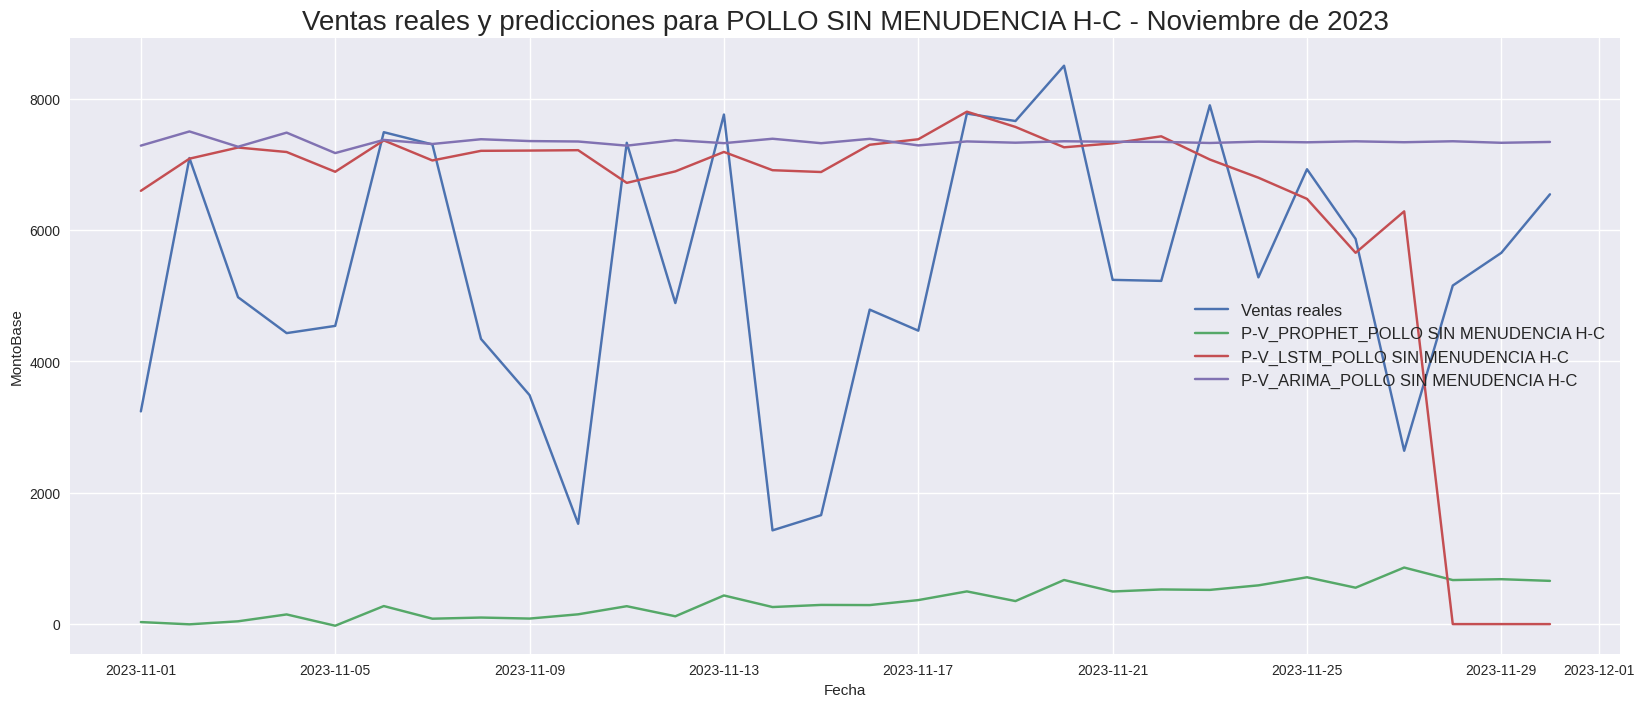

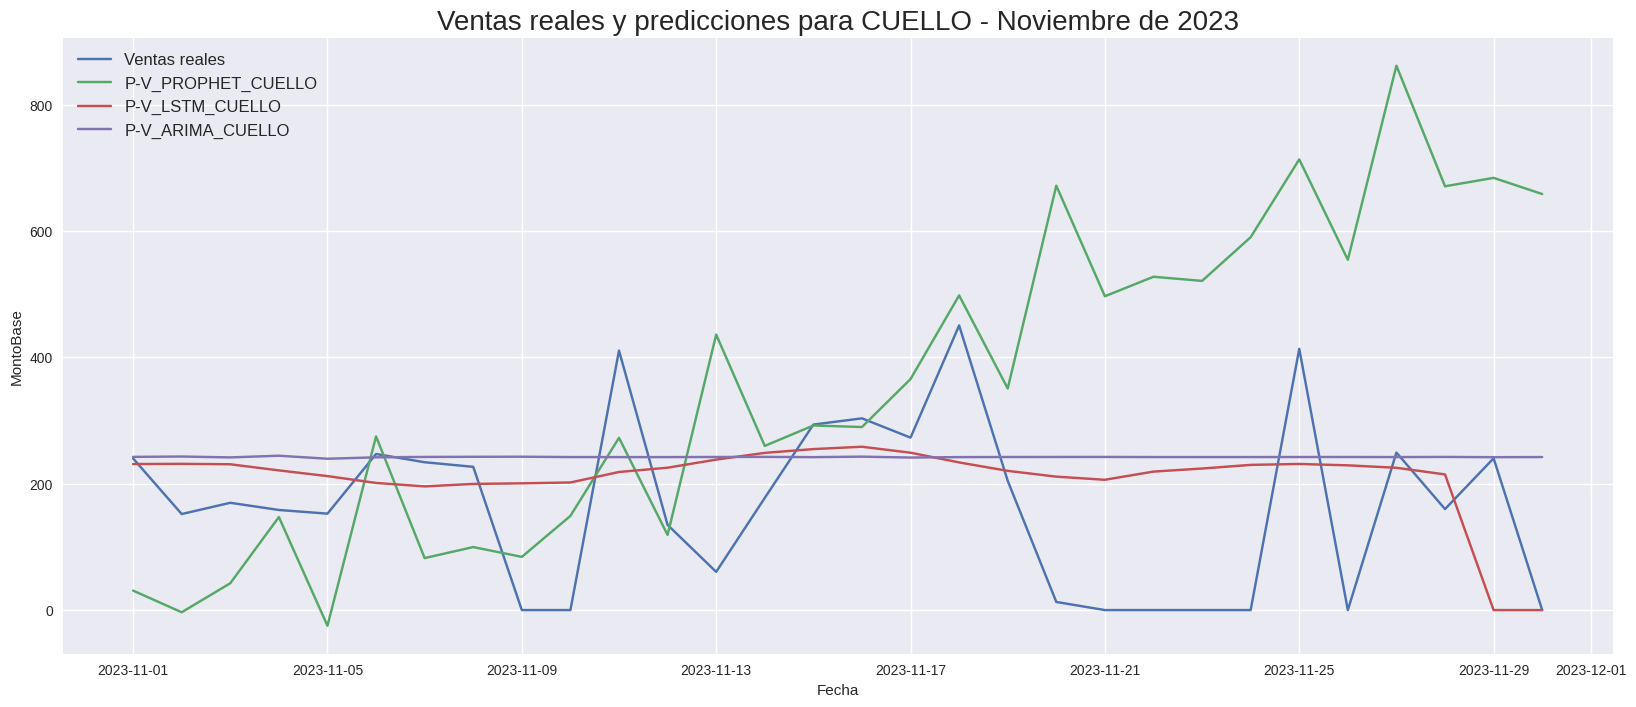

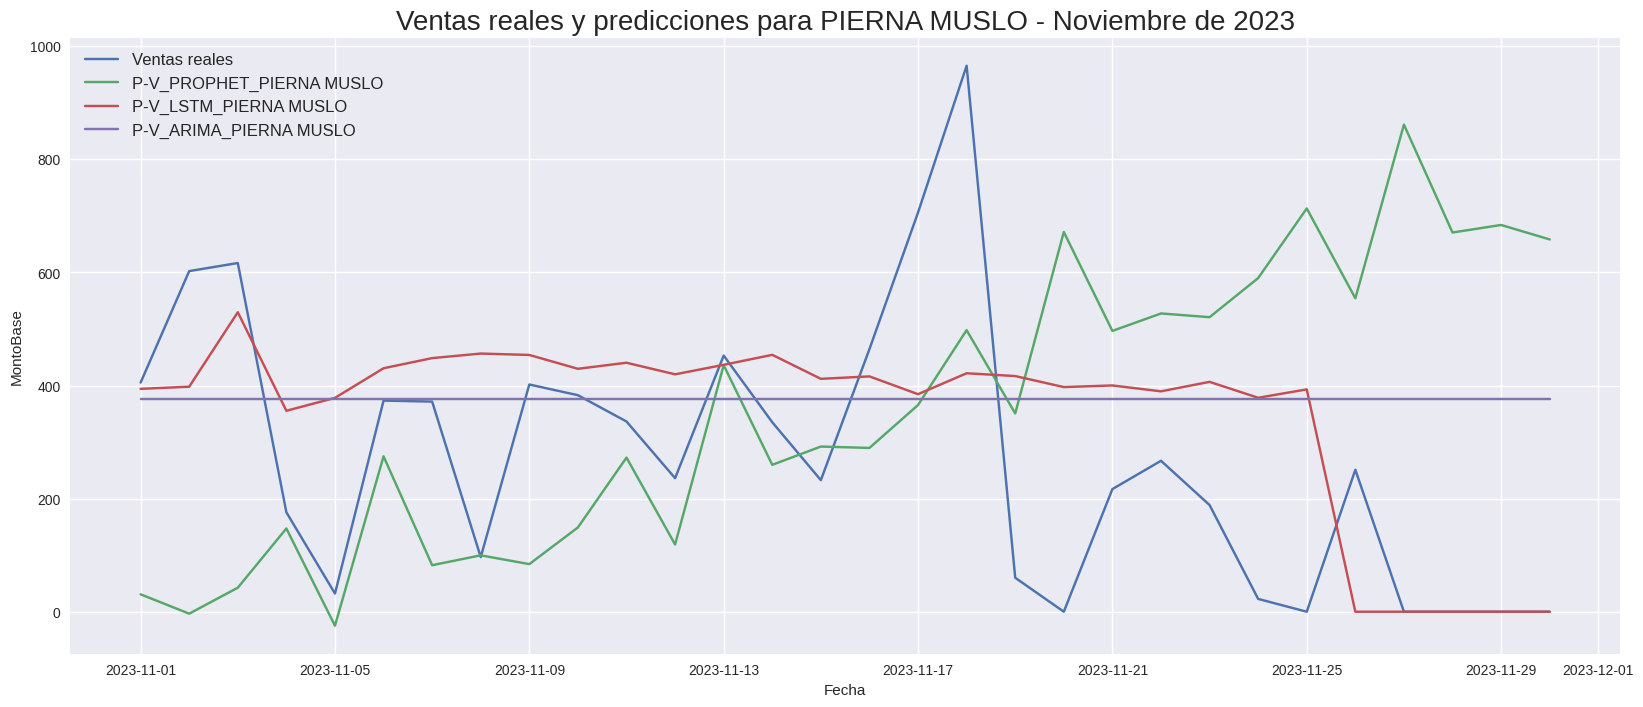

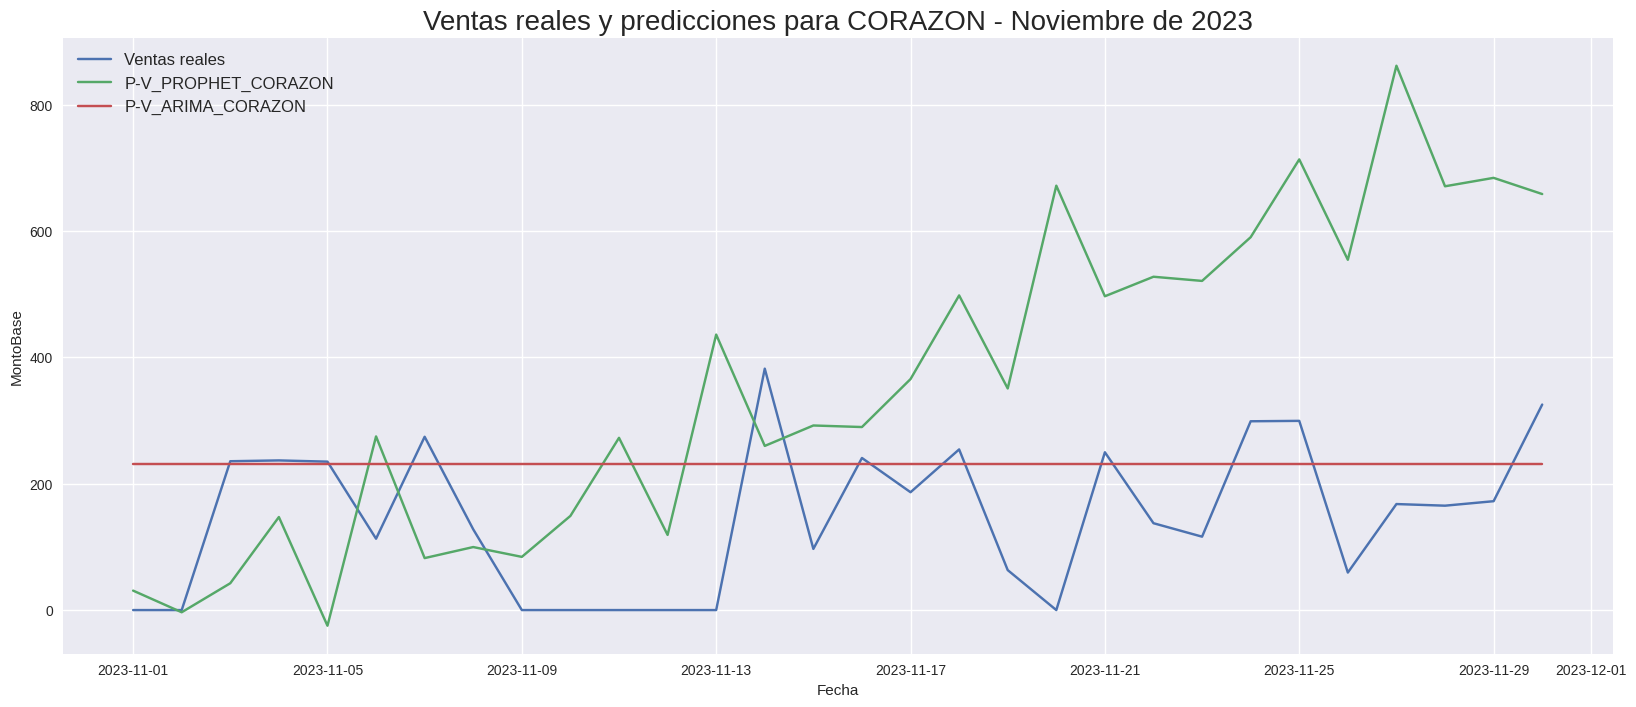

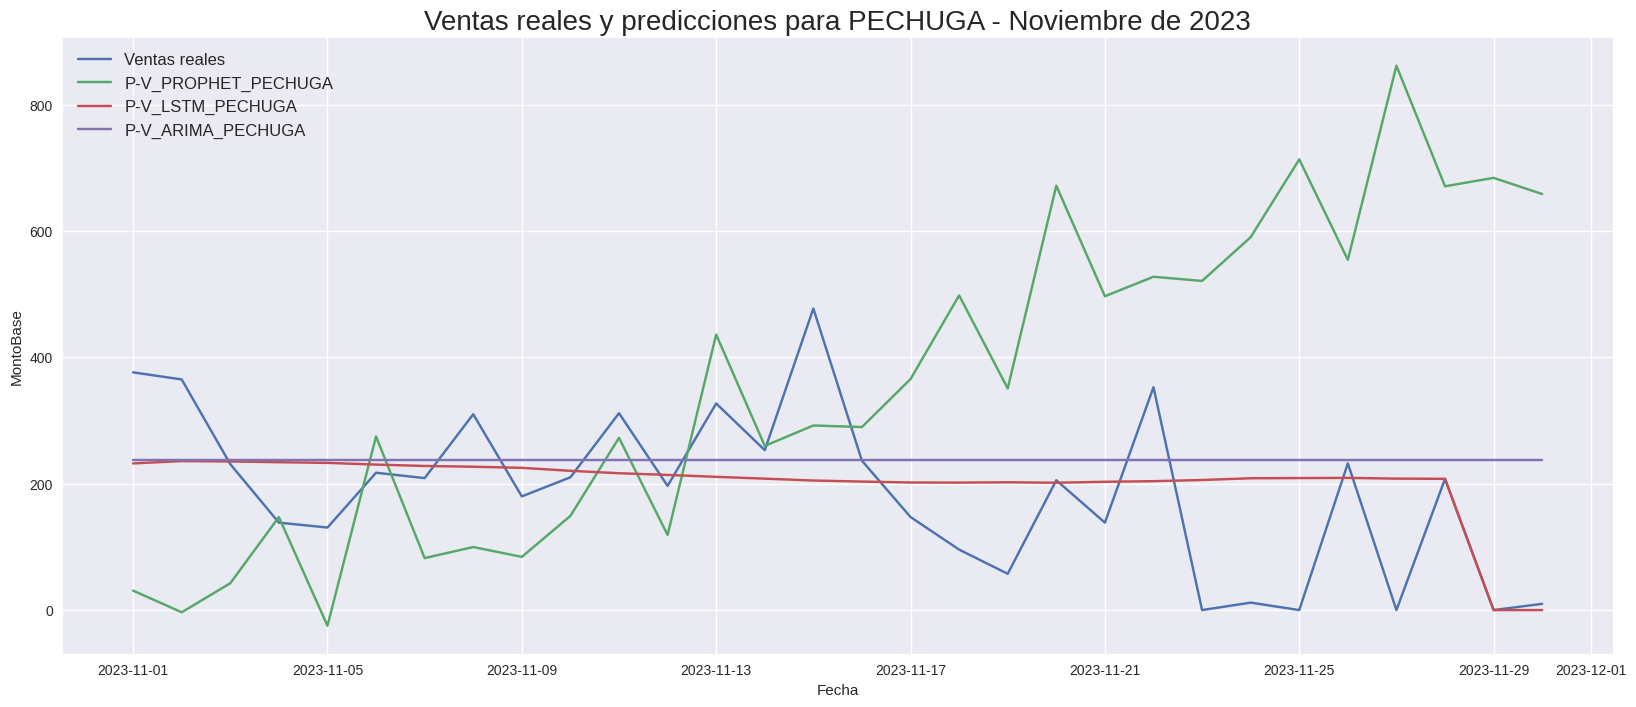

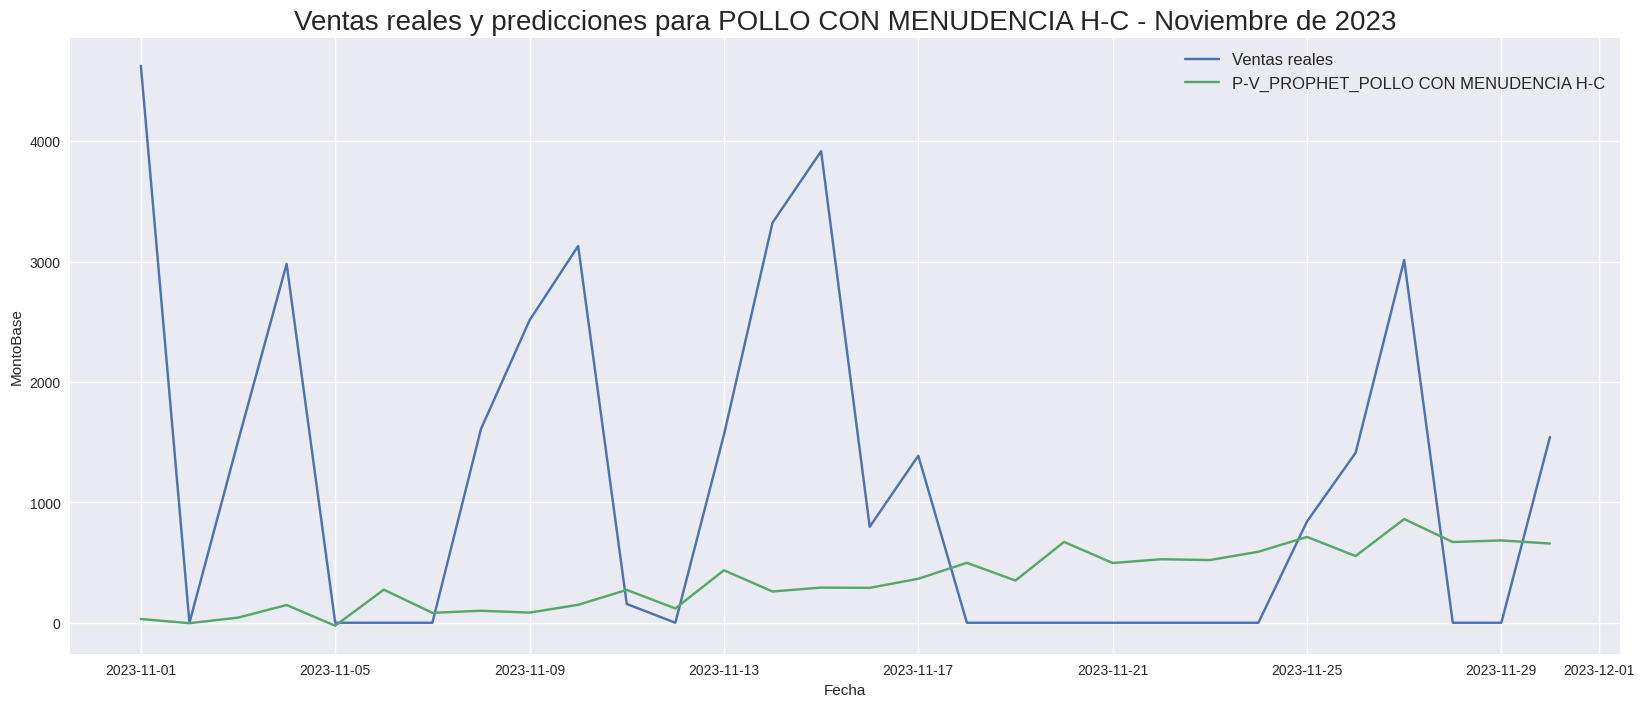

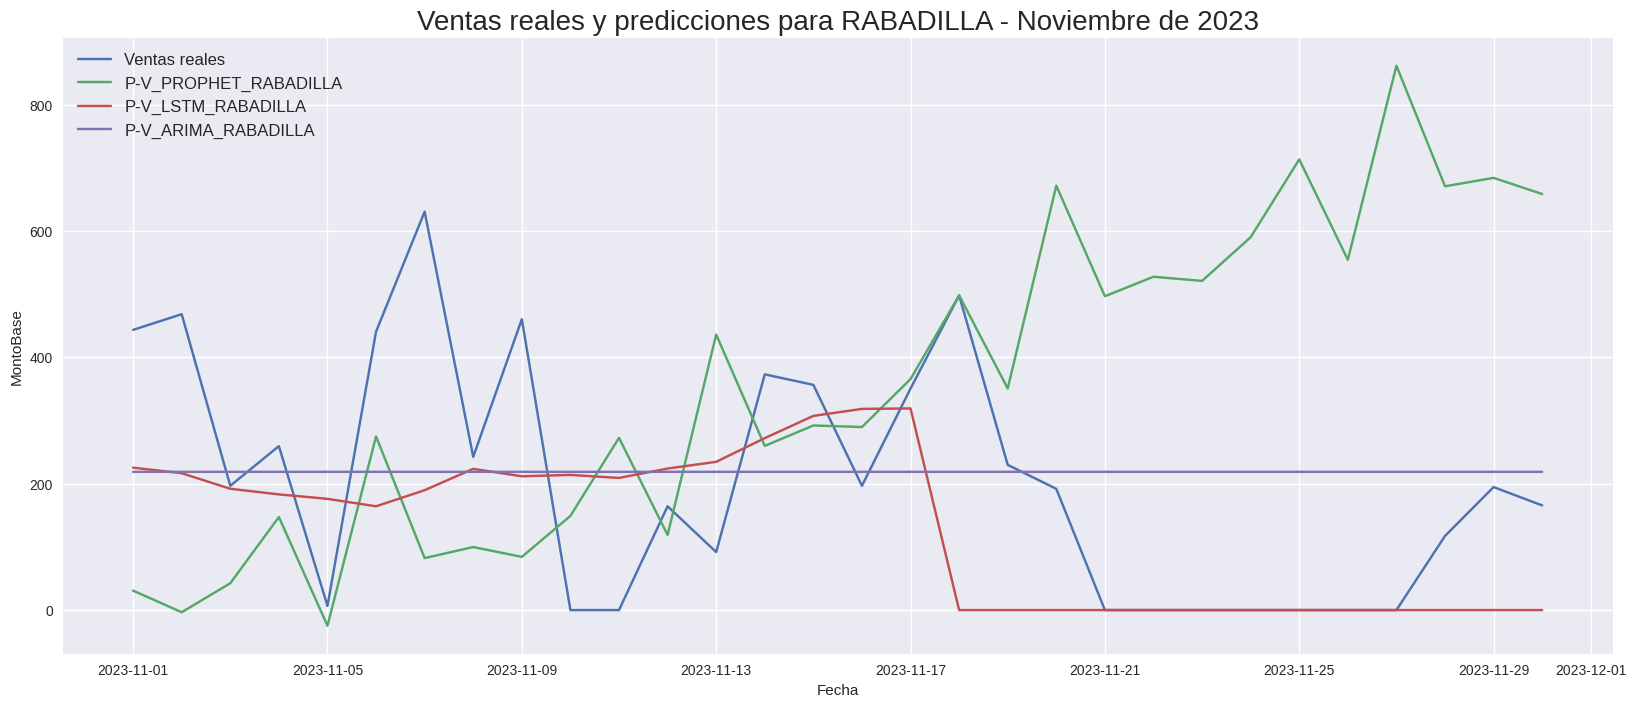

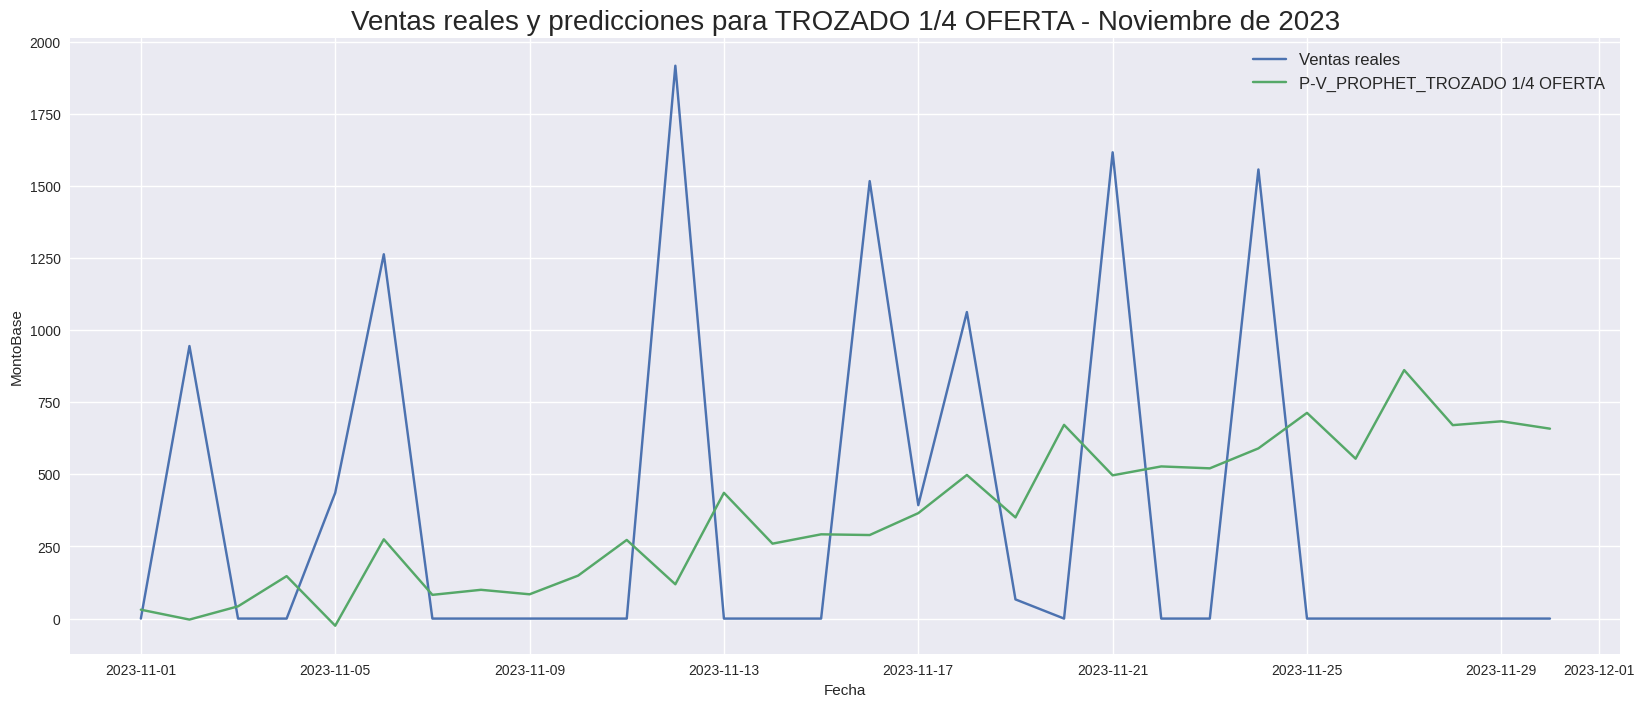

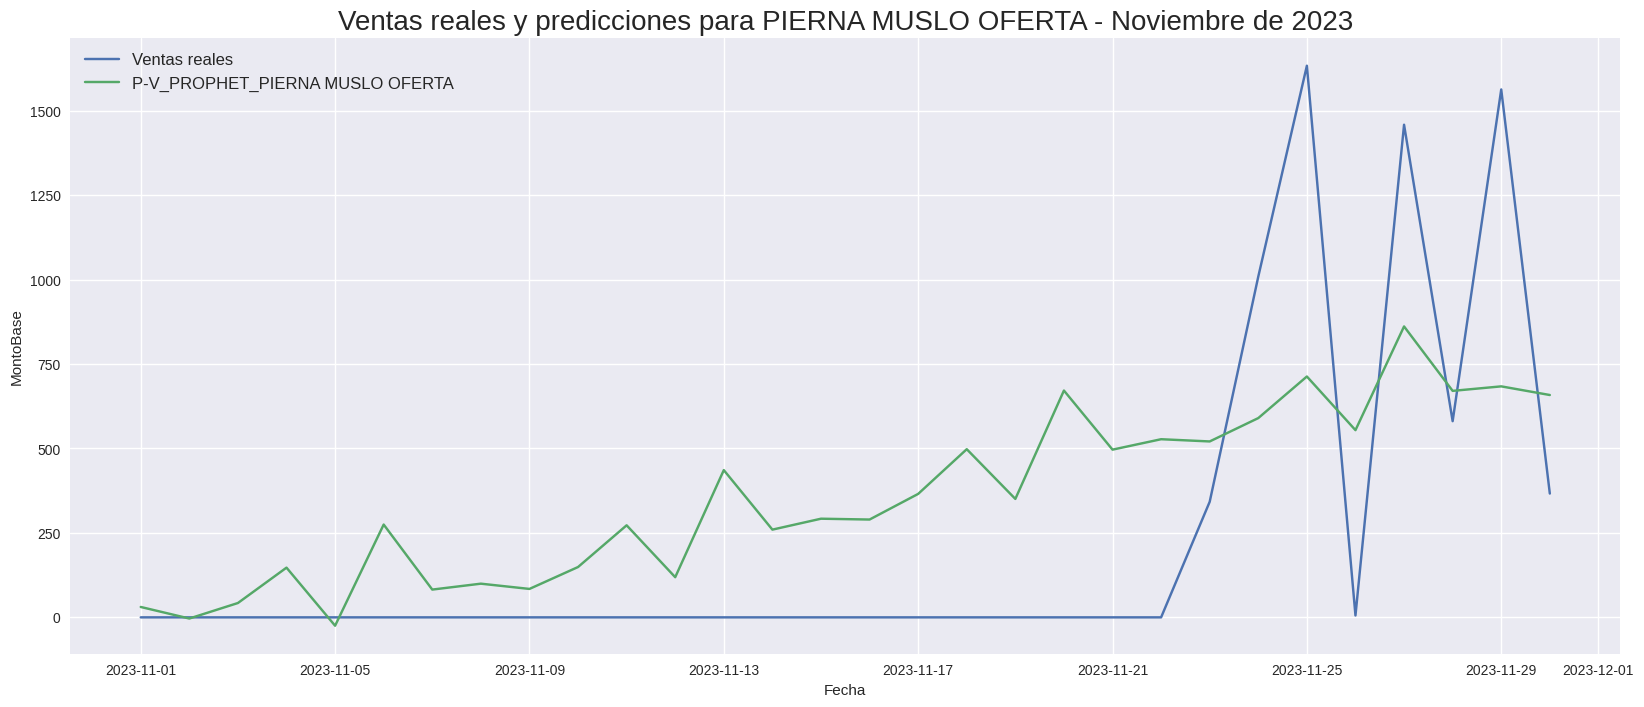

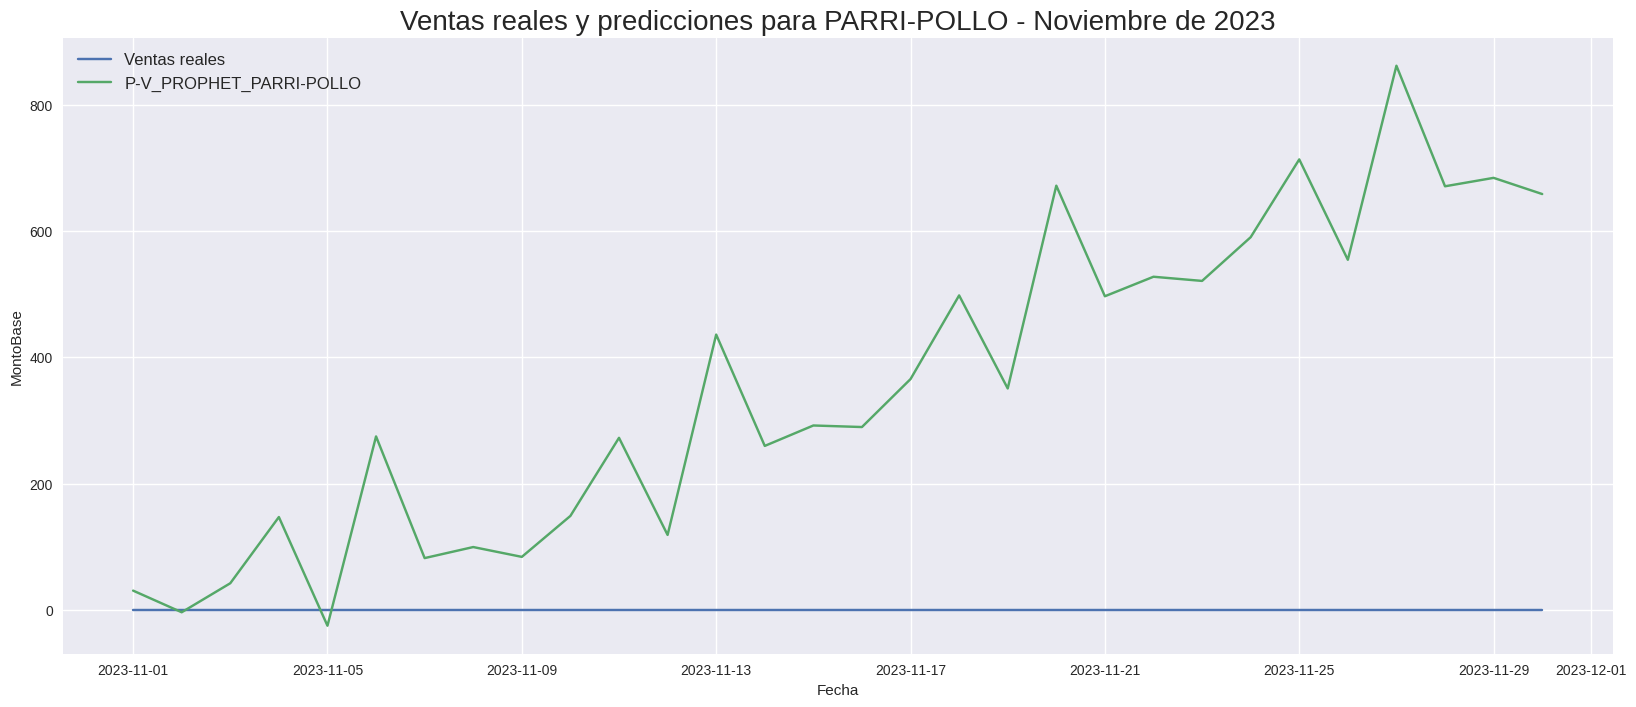

In [ ]:
# Obtener la lista de productos
productos = list(dfs_noviembre_sumados.keys())

# Configurar el gráfico
plt.style.use('seaborn')

# Iterar sobre los productos
for product in productos:
    # Obtener los datos del producto actual
    product_data = dfs_noviembre_sumados[product]

    # Verificar si hay predicciones disponibles para el producto
    predicciones_disponibles = [col for col in product_data.columns if 'P-V_' in col]

    if not predicciones_disponibles:
        # No hay predicciones disponibles para el producto, omitir el gráfico
        continue

    # Configurar el gráfico para el producto actual
    plt.figure(figsize=(20, 8))
    plt.plot(product_data['FechaMovimiento'], product_data['MontoBase'], label='Ventas reales')

    # Graficar todas las predicciones disponibles
    for pred in predicciones_disponibles:
        plt.plot(product_data['FechaMovimiento'], product_data[pred], label=pred)

    # Configurar etiquetas y leyenda
    plt.title(f'Ventas reales y predicciones para {product} - Noviembre de 2023', fontsize=20)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend(fontsize=12)
    plt.show()

In [ ]:
# Iterar sobre los productos
for product, product_df in dfs_noviembre_sumados.items():
    print(f'Evaluación del producto: {product}')

    # Verificar si hay predicciones disponibles para el producto
    predicciones_disponibles = [col for col in product_df.columns if 'P-V_' in col]

    if not predicciones_disponibles:
        # No hay predicciones disponibles para el producto
        print(f"No hay predicciones para {product}.")
        continue

    # Calcular métricas de evaluación para cada predicción disponible
    for pred in predicciones_disponibles:
        # Extraer el nombre del modelo de la columna de predicciones
        nombre_modelo = pred.split('_')[1]

        y_real = product_df['MontoBase']
        y_pred = product_df[pred]

        print(f'Modelo: {nombre_modelo}')
        evaluacion_metrica(y_real, y_pred)
        print()

Evaluación del producto: POLLO SIN MENUDENCIA H-C
Modelo: PROPHET
Evaluation metric results:-
MSE is : 28833206.681281224
MAE is : 5014.898869757964
R2 is : -6.453178456012579 %
------------------------------
RMSE is : 5369.656104563981
MAPE is : 92.35658371258742 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




Modelo: LSTM
Evaluation metric results:-
MSE is : 9657654.419696117
MAE is : 2412.690886067708
R2 is : -1.496434845147625 %
------------------------------
RMSE is : 3107.6766916293136
MAPE is : 75.74966050758148 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




Modelo: ARIMA
Evaluation metric results:-
MSE is : 7759576.507940633
MAE is : 2177.8331042119735
R2 is : -1.0057952310351408 %
------------------------------
RMSE is : 2785.6016420049427
MAPE is : 74.8